# **Diabetic Hospital Readmission Classification**

# Overview

Hospital readmission for diabetic patients is a significant business problem with implications for patient outcomes and healthcare costs. In this project, a classification model was developed to predict hospital readmission for diabetic patients. The model demonstrated improvement compared to a baseline dummy model, with an increase in F1 score from 0.00 to 0.4479 and an increase in ROC AUC score from 0.5000 to 0.5449. The analysis of feature importance highlighted num_lab_procedures, num_medications, and time_in_hospital as the top influential features. These features provide valuable insights into the factors contributing to readmission risk. Future investigations could focus on feature engineering, exploring different algorithms, addressing class imbalance, and considering multi-class classification and time series analysis. By leveraging these findings, healthcare providers can tailor their policies and methodologies to improve care coordination, reduce readmission rates, and optimize patient outcomes while effectively managing healthcare resource utilization.

# Business Problem

Hospital readmission for diabetic patients is a significant business problem with potential implications for patient outcomes and healthcare costs. 

1. Impact on Patient Health: Hospital readmission for diabetes is associated with worse long-term outcomes for patients. Poorly controlled diabetes during the initial hospitalization can lead to complications and disease progression, including cardiovascular events, kidney problems, infections, and diabetic ketoacidosis. Inadequate management and fragmented care transitions contribute to gaps in follow-up care, medication adherence, and lifestyle management, further impacting patient health and well-being.

2. Healthcare Resource Utilization: Hospital readmissions for diabetes impose a substantial burden on the healthcare system. Repeated hospitalizations increase healthcare utilization and costs, straining healthcare resources. Additionally, fragmented care and lack of continuity disrupt the establishment of consistent and effective care plans, hindering disease management and potentially leading to avoidable readmissions.

3. Need for Comprehensive Solutions: Addressing hospital readmission for diabetic patients requires comprehensive solutions. Improving care coordination, patient education, medication management, discharge planning, and post-discharge follow-up are essential components. By focusing on these areas, healthcare providers can promote continuity of care, reduce readmission rates, improve patient outcomes, and mitigate the financial impact on the healthcare system.

In summary, hospital readmission for diabetic patients presents a significant business problem due to its impact on patient health outcomes and healthcare resource utilization. A comprehensive approach that addresses care coordination and continuity is crucial for reducing readmission rates, improving patient outcomes, and optimizing healthcare costs.

The classification model created in this project will be able to shed light on specific features included in the model that have the highest effect on readmission which hospitals can use to streamline their policies and methodologies in care coordination.

# Data

The data set represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

1. It is an inpatient encounter (a hospital admission).
2. It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
3. The length of stay was at least 1 day and at most 14 days.
4. Laboratory tests were performed during the encounter.
5. Medications were administered during the encounter.

The target for this classification model was `readmission` and it originally started off as multiclass (no, >30, <30) but for this model, we focused on the binary problem.

There are information on the features in IDs_mapping.csv as well as the paper cited below. The IDs_mapping.csv is specifically used when binning the three features (admission_id, discharge_disposition_id, as well as admission_source).

(Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.)

# Methods

This project uses machine learning tools to make different types of models and gridsearch for hyperparameters to optimize the model.

The evaluation metric was the F1 score. The F1 score is a commonly used evaluation metric in classification tasks. It combines two important metrics: precision and recall.

Precision measures the model's ability to correctly identify positive cases (hospital readmissions) out of all instances predicted as positive. In the context of hospital readmission, precision represents the proportion of patients predicted as readmitted who are actually readmitted. A high precision indicates that when the model predicts a patient will be readmitted, it is likely to be correct.

Recall, on the other hand, measures the model's ability to correctly identify all positive cases (actual hospital readmissions) out of the total actual positive cases. In the context of hospital readmission, recall represents the proportion of actual readmissions that the model correctly identifies. A high recall indicates that the model is effective at capturing a significant portion of the readmissions.

The F1 score combines precision and recall into a single metric, providing a balanced measure of the model's performance. It considers both false positives and false negatives, which is important in healthcare applications where the consequences of misclassification can be significant. By optimizing for the F1 score, we aim to strike a balance between identifying as many true positives (correctly predicting readmissions) as possible while minimizing false positives and false negatives.

In summary, the F1 score is a useful evaluation metric in the context of hospital readmission prediction because it considers both precision and recall, providing a balanced assessment of the model's ability to identify readmissions while minimizing false predictions.

# Imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler, OrdinalEncoder

import statsmodels.api as sm  
import itertools

In [2]:
# setting the theme, palette, size for all plots made in this notebook
sns.set_theme(style="whitegrid")
sns.set_palette('colorblind')
sns.set(rc={'savefig.dpi':200})

In [3]:
# importing data
df = pd.read_csv('./data/diabetic_data.csv')
df

encounter_id  patient_nbr             race  gender      age weight  \
0            2278392      8222157        Caucasian  Female   [0-10)      ?   
1             149190     55629189        Caucasian  Female  [10-20)      ?   
2              64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3             500364     82442376        Caucasian    Male  [30-40)      ?   
4              16680     42519267        Caucasian    Male  [40-50)      ?   
...              ...          ...              ...     ...      ...    ...   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
101763     443854148     41088789        Caucasian    Male  [70-80)      ?   
101764     443857166     31693671        Caucasian  Female  [80-90)      ?   
101765     443867222    175429310        Caucasian    Male  [70-80)      ?   

        admission_type_id  discharge_disposition_id  admission_source_id  \
0                       6                        25                    1   
1                       1                         1                    7   
2                       1                         1                    7   
3                       1                         1                    7   
4                       1                         1                    7   
...                   ...                       ...                  ...   
101761                  1                         3                    7   
101762                  1                         4                    5   
101763                  1                         1                    7   
101764                  2                         3                    7   
101765                  1                         1                    7   

        time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                      1  ...          No      No                   No   
1                      3  ...          No      Up                   No   
2                      2  ...          No      No                   No   
3                      2  ...          No      Up                   No   
4                      1  ...          No  Steady                   No   
...                  ...  ...         ...     ...                  ...   
101761                 3  ...          No    Down                   No   
101762                 5  ...          No  Steady                   No   
101763                 1  ...          No    Down                   No   
101764                10  ...          No      Up                   No   
101765                 6  ...          No      No                   No   

        glipizide-metformin  glimepiride-pioglitazone  \
0                        No                        No   
1                        No                        No   
2                        No                        No   
3                        No                        No   
4                        No                        No   
...                     ...                       ...   
101761                   No                        No   
101762                   No                        No   
101763                   No                        No   
101764                   No                        No   
101765                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change diabetesMed  \
0                            No                      No      No          No   
1                            No                      No      Ch         Yes   
2                            No                      No      No         Yes   
3                            No                      No      Ch         Yes   
4                            No                      No      Ch         Yes   
...                         ...                     ...     ...         ...   
101761                       No

# EDA

In [4]:
display(df.shape)
display(df.info())
display(df.describe())

(101766, 50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

None

encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.000000          4.000000   
75%                    4.000000             7.000000          6.000000   
max                   28.000000            25.000000         14.000000   

       num_lab_procedures  num_procedures  num_medications  number_outpatient  \
count       101766.000000   101766.000000    101766.000000      101766.000000   
mean            43.095641        1.339730        16.021844           0.369357   
std             19.674362        1.705807         8.127566           1.267265   
min              1.000000        0.000000         1.000000           0.000000   
25%             31.000000        0.000000        10.000000           0.000000   
50%             44.000000        1.000000        15.000000           0.000000   
75%             57.000000        2.000000        20.000000           0.000000   
max            132.000000        6.000000        81.000000          42.000000   

       number_emergency  number_inpatient  number_diagnoses  
count     101766.000000     101766.000000     101766.000000  
mean           0.197836          0.635566          7.422607  
std            0.930472          1.262863          1.933600  
min            0.000000          0.000000          1.000000  
25%            0.000000          0.000000          6.000000  
50%            0.000000          0.000000          8.000000  
75%            0.000000          1.000000          9.000000  
max           76.000000         21.000000         16.000000

There are a total of 101766 data points and 50 different columns in this dataset. 101,766 encounters were identified to fulfill all of the above five inclusion criteria, stated in the 'Data' section, and were used in further analysis. Attribute/feature selection was performed by our clinical experts and only attributes that were potentially associated with the diabetic condition or management were retained. The 50 features describes the diabetic encounters, including demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information. All of these features describe the patients' current state and will be useful in classifying which patients will be readmitted. There seems be no null in this dataset, however, the paper cited in the 'Data' section mentions that the nulls are marked differently.

## Null Values

In [5]:
# In the dataset missing values are represented as '?' sign so isna will return that there are no nulls
# for the gender column missing values are logged in as unknown

missing_value_count = df.isin(['?', 'Unknown/Invalid']).sum()
print(missing_value_count)

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          3
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

There are eight features that have null values. I will go through each of them and handle the unknowns according to how many are missing and if it is data that can be filled in.

### Dropping Columns and taking care of null values

In [6]:
# Creating a copy of the DataFrame
df_clean = df.copy()

In [7]:
#dropping columns with large number of missing values
df_clean = df_clean.drop(['weight','payer_code','medical_specialty'], axis = 1)

In [8]:
#sanity check
df.shape, df_clean.shape

((101766, 50), (101766, 47))

In [9]:
# Dropping all the the null values (marked with ?) in diag_1,2,3
# It doesn't makes sense for me to fill it in with the most frequeent

drop_conditions = (
    (df_clean['diag_1'] == '?') |
    (df_clean['diag_2'] == '?') | 
    (df_clean['diag_3'] == '?') |
    (df_clean['race'] == '?') |
    (df_clean['gender'] == 'Unknown/Invalid')
)

drop_rows = set(df_clean[drop_conditions].index)
new_rows = list(set(df_clean.index) - drop_rows)
df_clean = df_clean.iloc[new_rows]

In [10]:
# re-checking for null values after dropping
df_clean.isin(['?', 'Unknown/Invalid']).sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol  

### Dropping deceased patients
Dropping patients that are deceased so that it will not bias the model.

In [11]:
# The definitions of the different numbers can be found in IDs_mapping.csv

discharge_codes_to_exclude = [11, 13, 14, 19, 20, 21]
df_clean = df_clean[~df_clean['discharge_disposition_id'].isin(discharge_codes_to_exclude)]

In [12]:
# sanity check
df_clean.shape

(95672, 47)

## Graphing all features

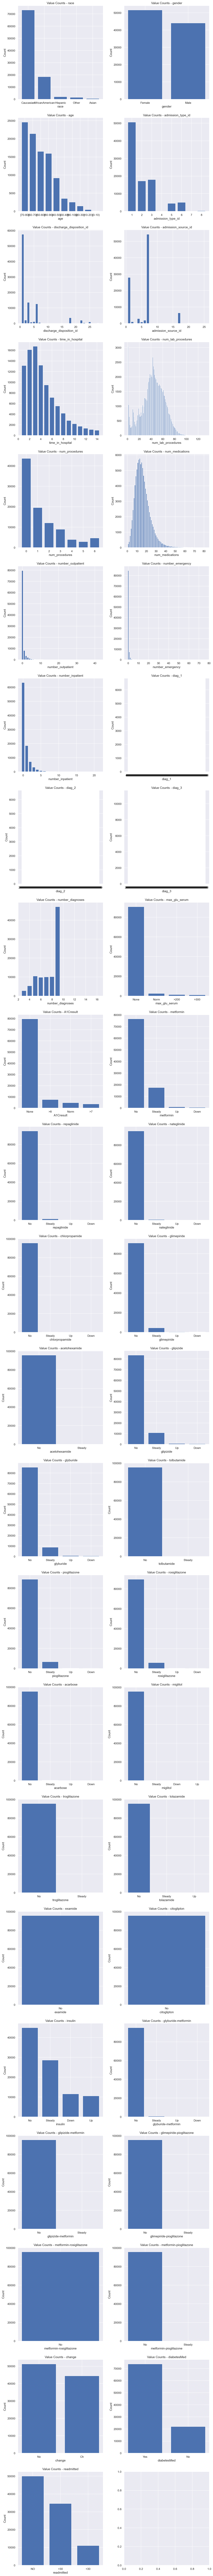

In [13]:
# Define the starting index for slicing the DataFrame columns
# I don't need to graph the encounter_id nor the patient_id
start_index = 2

# Calculate the number of columns to display on each row
columns_per_row = 2

# Calculate the total number of rows needed
total_rows = (len(df_clean.columns) - start_index) // columns_per_row + (
    (len(df_clean.columns) - start_index) % columns_per_row > 0)

# Create subplots
fig, axes = plt.subplots(total_rows, columns_per_row, 
                         figsize=(12, total_rows * 6), dpi=150)
fig.tight_layout(pad=4.0)

# Iterate over the columns in the DataFrame
for i, column in enumerate(df_clean.columns[start_index:]):
    # Calculate value counts for the column
    value_counts = df_clean[column].value_counts()

    # Calculate the subplot indices
    row_index, col_index = divmod(i, columns_per_row)

    # Create a bar plot for the value counts in the appropriate subplot
    axes[row_index, col_index].bar(value_counts.index, value_counts)
    axes[row_index, col_index].set_title(f'Value Counts - {column}')
    axes[row_index, col_index].set_xlabel(column)
    axes[row_index, col_index].set_ylabel('Count')

    # Hide any unused subplots
    if i + 1 >= total_rows * columns_per_row:
        break

# Display the subplots
plt.show()

### Explorationn of specific columns

In [14]:
# checking target group to see if there is a class inbalance
df_clean['readmitted'].value_counts()

NO     50043
>30    34606
<30    11023
Name: readmitted, dtype: int64

There are three groups: 
- No (not readmitted), 
- \>30 (readmitted but not within 30 days), 
- <30 (readmitte within 30 days)).

I will first make a model with biany yes or no readmission and another with multi-class in the future.

In [15]:
# checking for duplicated patients
display(df_clean['patient_nbr'].duplicated().sum())
display(df_clean['encounter_id'].duplicated().sum())

28544

0

Checked for duplicated entried but there are no duplicated entries since the encounter id are all different. This might come to be usefull when we want to focus on patients who were readmitted.

Since we do not want duplicated patients to bias towards those patients who had multiple encounters, I decided to use first encounters of patients with multiple encounters. This resulted in dataset being reduced to about 67,000 encounters:

In [16]:
df_clean = df_clean.drop_duplicates(subset= ['patient_nbr'], keep = 'first')

In [17]:
df_clean.shape

(67128, 47)

In [18]:
# drugs that have one category
df_clean['examide'].value_counts(), df_clean['citoglipton'].value_counts()

(No    67128
 Name: examide, dtype: int64,
 No    67128
 Name: citoglipton, dtype: int64)

Although examide, citoglipton, glimepiride-pioglitazone, and metformin-rosiglitazone don't have any patients that have these drugs in their regimen, I will keep these for future modeling use.

There could be patients that later switch onto these drugs, and so I will leave these columns for future data.

# Feature Engineering

## readmit_binary
Creating a binary column for readmission, which originally has three categories, for modeling.

In [19]:
# creating a column for binary target model
df_clean['readmit_binary'] = (df_clean['readmitted'] != 'NO').astype(int)

Class 0 means no record of readmission and 1 means yes readmission, whether it is within 30 days or not. 

In [20]:
df_clean['readmit_binary'].value_counts()

0    39401
1    27727
Name: readmit_binary, dtype: int64

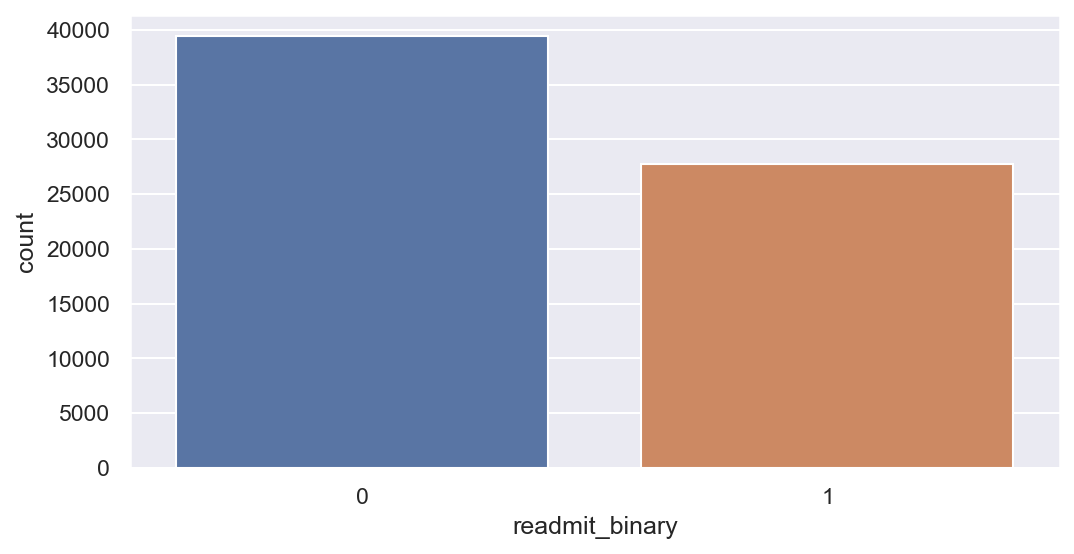

In [21]:
fig, axs = plt.subplots(figsize = (8, 4), dpi = 150)

sns.countplot(data = df_clean, x = "readmit_binary")
plt.show()

## num_change
There are a lot of drugs in this dataset and so I am making a column named 'num_change' to indicate how many timmes a patient's medication changes. The dataset contains 23 features for 23 drugs (or combos) which indicate for each of these, whether a change in that medication was made or not during the current hospital stay of patient. 

According to literature, medication change has been shown to be associated with lower readmission rates. I decided to count how many changes were made in total for each patient, and declared that a new feature. The reasoning here was to both simplify the model and possibly discover a relationship with number of changes regardless of which drug was changed.

In [22]:
# looking at one drug for categories
df_clean['metformin'].value_counts()

No        52837
Steady    13088
Up          789
Down        414
Name: metformin, dtype: int64

In [23]:
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 
        'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 
        'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 
        'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone', 
        'metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 
        'troglitazone', 'tolbutamide', 'acetohexamide',
        'examide', 'citoglipton'
       ]

In [24]:
# Create temporary columns and calculate 'numchange'
for col in drugs:
    colname = f'{col}_temp'
    df_clean[colname] = df_clean[col].map({'No': 0, 'Steady': 0, 'Up': 1, 'Down': 1})
df_clean['num_change'] = df_clean[[f'{col}_temp' for col in drugs]].sum(axis=1)

# Drop the temporary columns
df_clean.drop(columns=[f'{col}_temp' for col in drugs], inplace=True)

# Display the value counts of 'numchange'
df_clean['num_change'].value_counts()

0    50563
1    15596
2      893
3       73
4        3
Name: num_change, dtype: int64

In [25]:
# sanity check
df_clean.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'readmit_binary', 'num_change'],
      dtype='object')

In [26]:
df_clean.groupby('num_change')['readmit_binary'].value_counts().sort_values(ascending=False)

num_change  readmit_binary
0           0                 30256
            1                 20307
1           0                  8605
            1                  6991
2           0                   494
            1                   399
3           0                    43
            1                    30
4           0                     3
Name: readmit_binary, dtype: int64

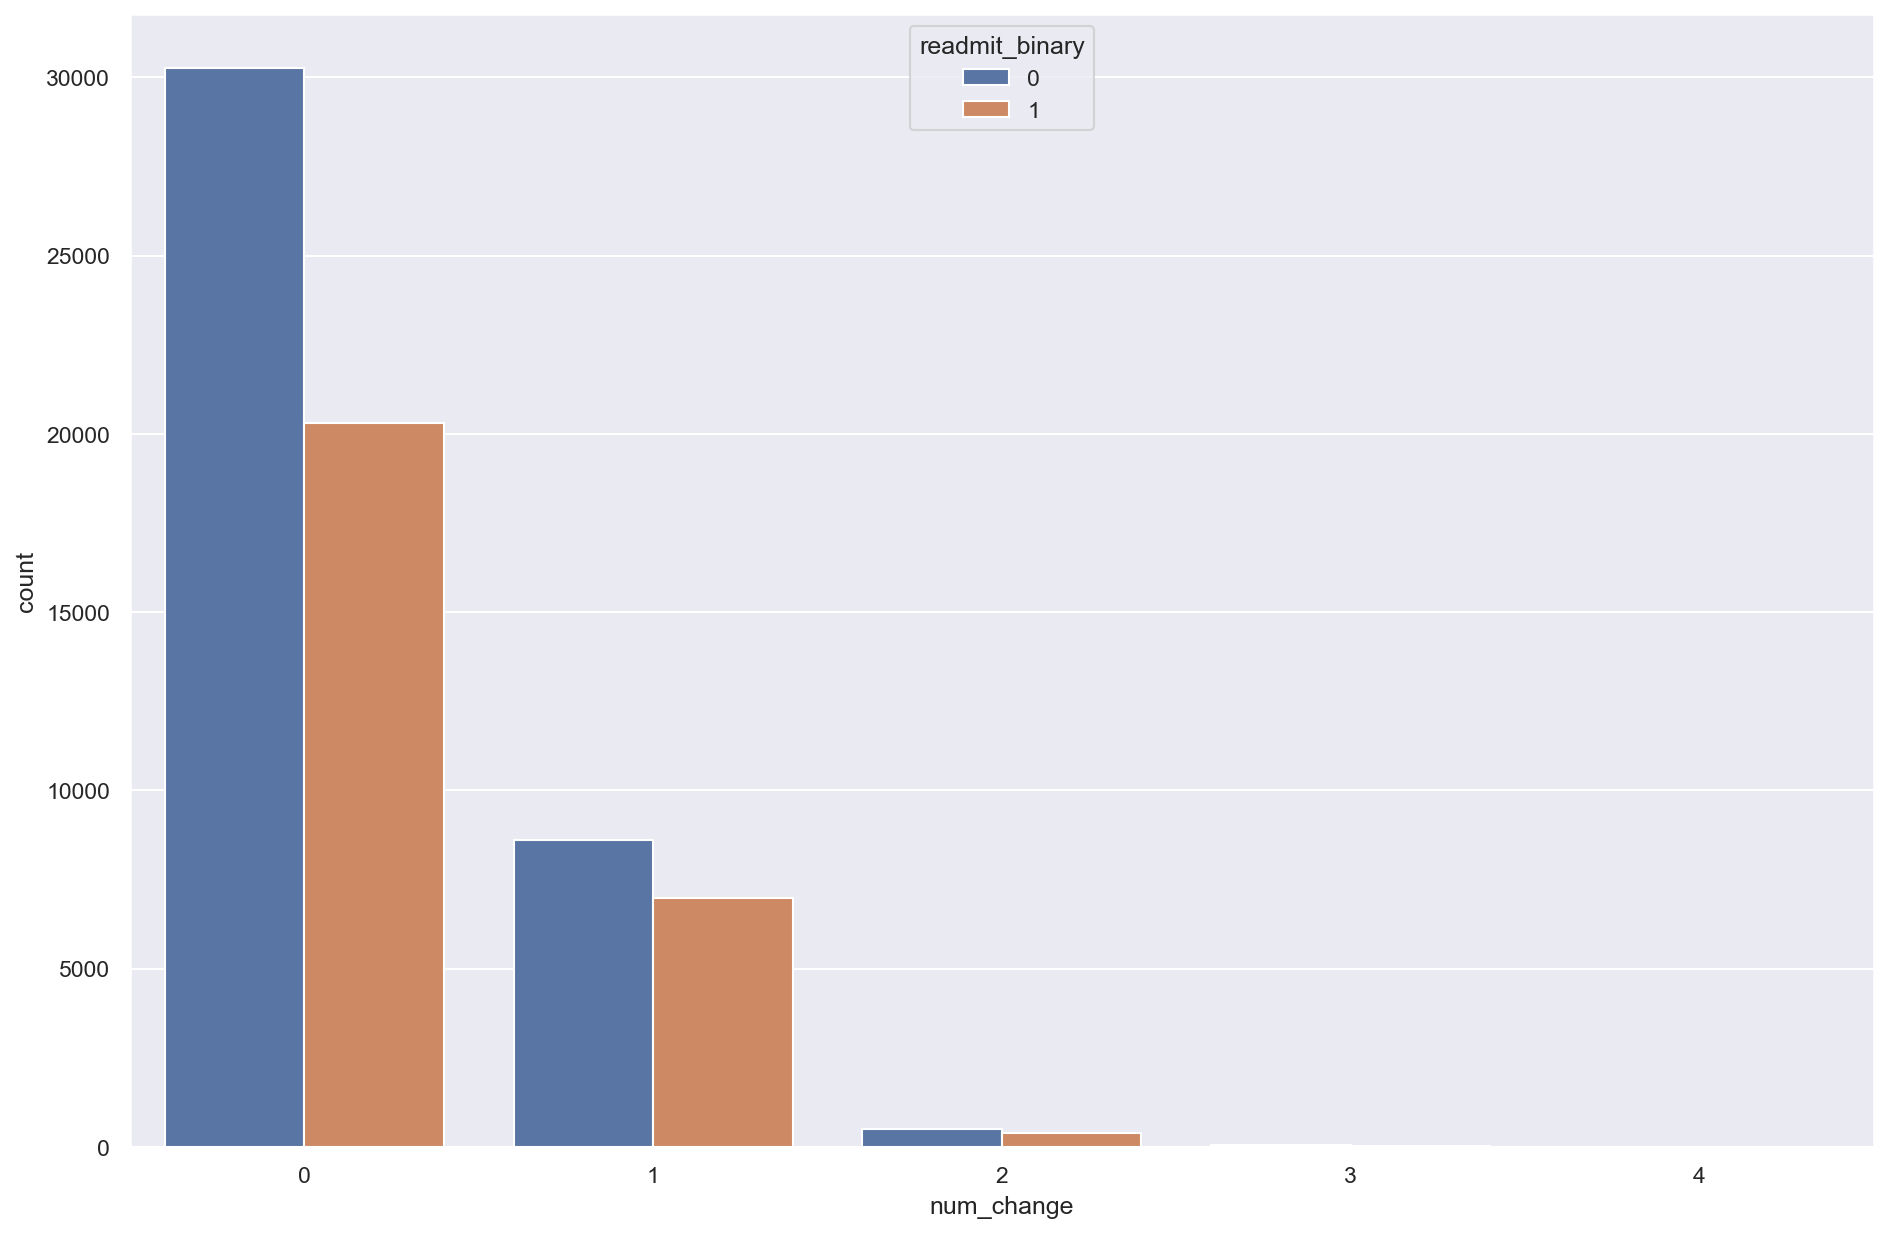

In [27]:
fig, axs = plt.subplots(figsize = (15, 10), dpi = 150)

sns.countplot(data = df_clean, x = "num_change", hue = "readmit_binary")
plt.show()

Seems like in this data, there are more patients who have been not readmitted with zero number of medication changes. This is what we expect according to literature. It is important to not that there seems to be more people who have not been readmitted in the other number of changes as well.

## num_meds

The total number of medications used by a patient could be another factor that potentially relates to their condition severity and the level of care required. To capture this information, I generated an additional feature by counting the medications used during each encounter. This feature was derived from the 'drugs' variable, which is a continuation from the previous code.

It is important to know that this is different from num_medications already in the dataframe since it means "Number of distinct generic names administered during the encounter" not number of medications that the patient is on.

In [28]:
# counting categories that are not no and adding them to num_meds
df_clean['num_meds'] = df_clean[drugs].apply(lambda x: (x != 'No').sum(), axis=1)

In [29]:
df_clean['num_meds'].value_counts()

1    29755
0    16125
2    14793
3     5425
4      977
5       49
6        4
Name: num_meds, dtype: int64

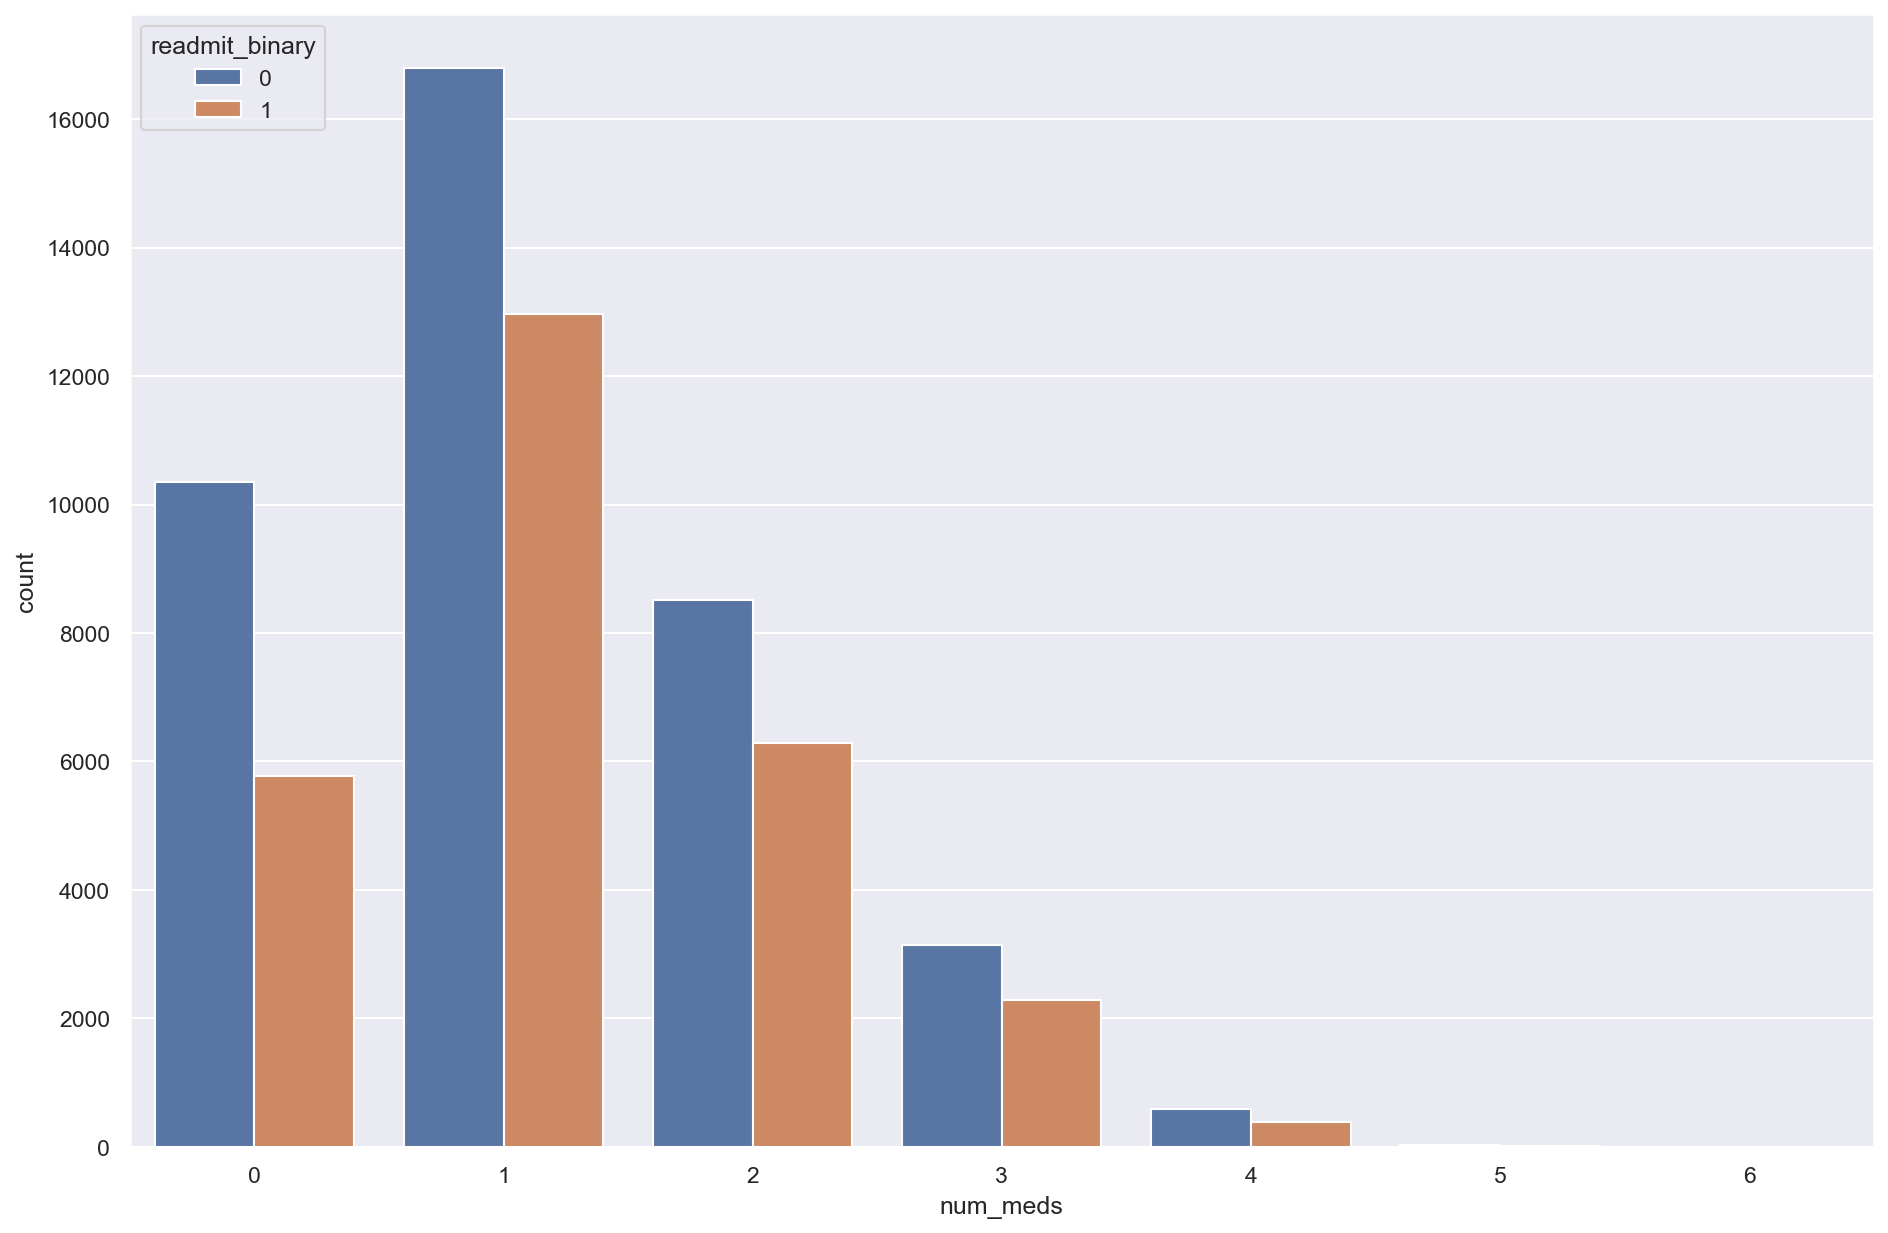

In [30]:
fig, axs = plt.subplots(figsize = (15, 10), dpi = 150)

sns.countplot(data = df_clean, x = "num_meds", hue = "readmit_binary")
plt.show()

Text(0.5, 1.0, 'Number of Medication VS. Readmission')

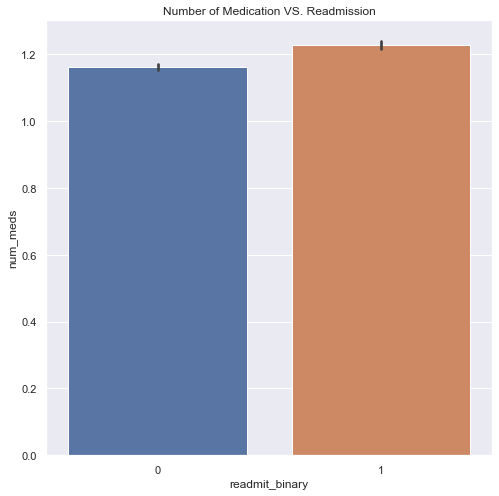

In [31]:
fig = plt.figure(figsize=(8,8))
sns.barplot( y = df_clean['num_meds'], 
            x = df_clean['readmit_binary']
           ).set_title('Number of Medication VS. Readmission')

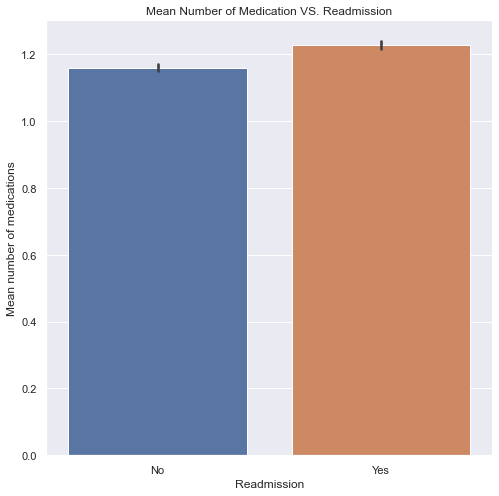

''

In [32]:
fig = plt.figure(figsize=(8, 8))
ax = sns.barplot(x=df_clean['readmit_binary'], y=df_clean['num_meds'])

# Set the x tick labels
ax.set_xticklabels(['No', 'Yes'])

# Set the axis labels
ax.set_xlabel('Readmission')
ax.set_ylabel('Mean number of medications')

# Set the title
ax.set_title("Mean Number of Medication VS. Readmission")

# save figure
plt.savefig('images/num_meds.png')


plt.show()
;

We can see that although for all the categories there are more patients that do not get readmitted, the second graph shows that the number of medication taken by the patients who are readmitted are higher than those who are not.

## num_service

The dataset includes variables that capture the count of inpatient admissions, emergency room visits, and outpatient visits for each patient over the course of the previous year. These variables serve as rough indicators of the extent to which a person utilized hospital and clinic services during that period. 

To explore the impact of these utilization measures on the results, I combined the three variables into a new composite variable called "num_service". I didn't assign specific weights to the three components of service utilization at this stage and opted for a straightforward approach to gauge their collective influence.

In [33]:
df_clean['num_service'] = df_clean[['number_outpatient', 'number_emergency', 'number_inpatient']].sum(axis=1)

In [34]:
df_clean['num_service'].value_counts()

0     49175
1      9382
2      3912
3      2036
4      1103
5       600
6       317
7       182
8       116
9        84
10       54
11       46
12       26
13       18
15       17
14       12
17        9
16        7
18        4
20        4
24        4
27        4
22        3
25        2
33        2
42        1
23        1
26        1
30        1
34        1
35        1
36        1
37        1
49        1
Name: num_service, dtype: int64

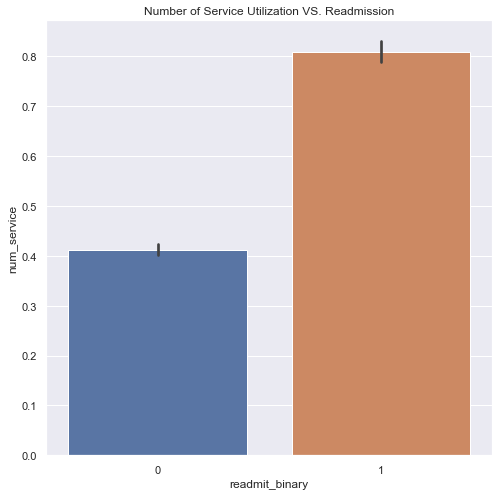

In [35]:
fig = plt.figure(figsize=(8,8))
sns.barplot( y = df_clean['num_service'], 
            x = df_clean['readmit_binary']
           ).set_title('Number of Service Utilization VS. Readmission');

This is the most drastic difference so far seen where there are more patients that have been readmitted. This shows that the patients who do get readmitted use more services during their visit than patients who do not get readmitted.

# Re-coding columns to make fewer categories

The original categories for the first three features can be found in IDs_mapping.csv in the 'Data' folder.

## Admission_source_id

Admission source id has a total of 26 categories and few of them can be re-coded into one category

In [36]:
admission_source_mapping = {1: "referral", 2: "referral", 3: "referral",
                            4: "transfer", 5: "transfer", 6: "transfer",
                            10: "transfer", 22: "transfer", 25: "transfer",
                            8: "unavailable", 14: "unavailable", 11: "unavailable",
                            13: "unavailable", 9: "unavailable", 15: "unavailable",
                            17: "unavailable", 20: "unavailable", 21: "unavailable",
                            7: "emergencyRoom"
                           }

df_clean['admission_source_id'] = df_clean['admission_source_id'].replace(admission_source_mapping)

In [37]:
df_clean['admission_source_id'].value_counts()

emergencyRoom    36138
referral         21767
unavailable       4891
transfer          4332
Name: admission_source_id, dtype: int64

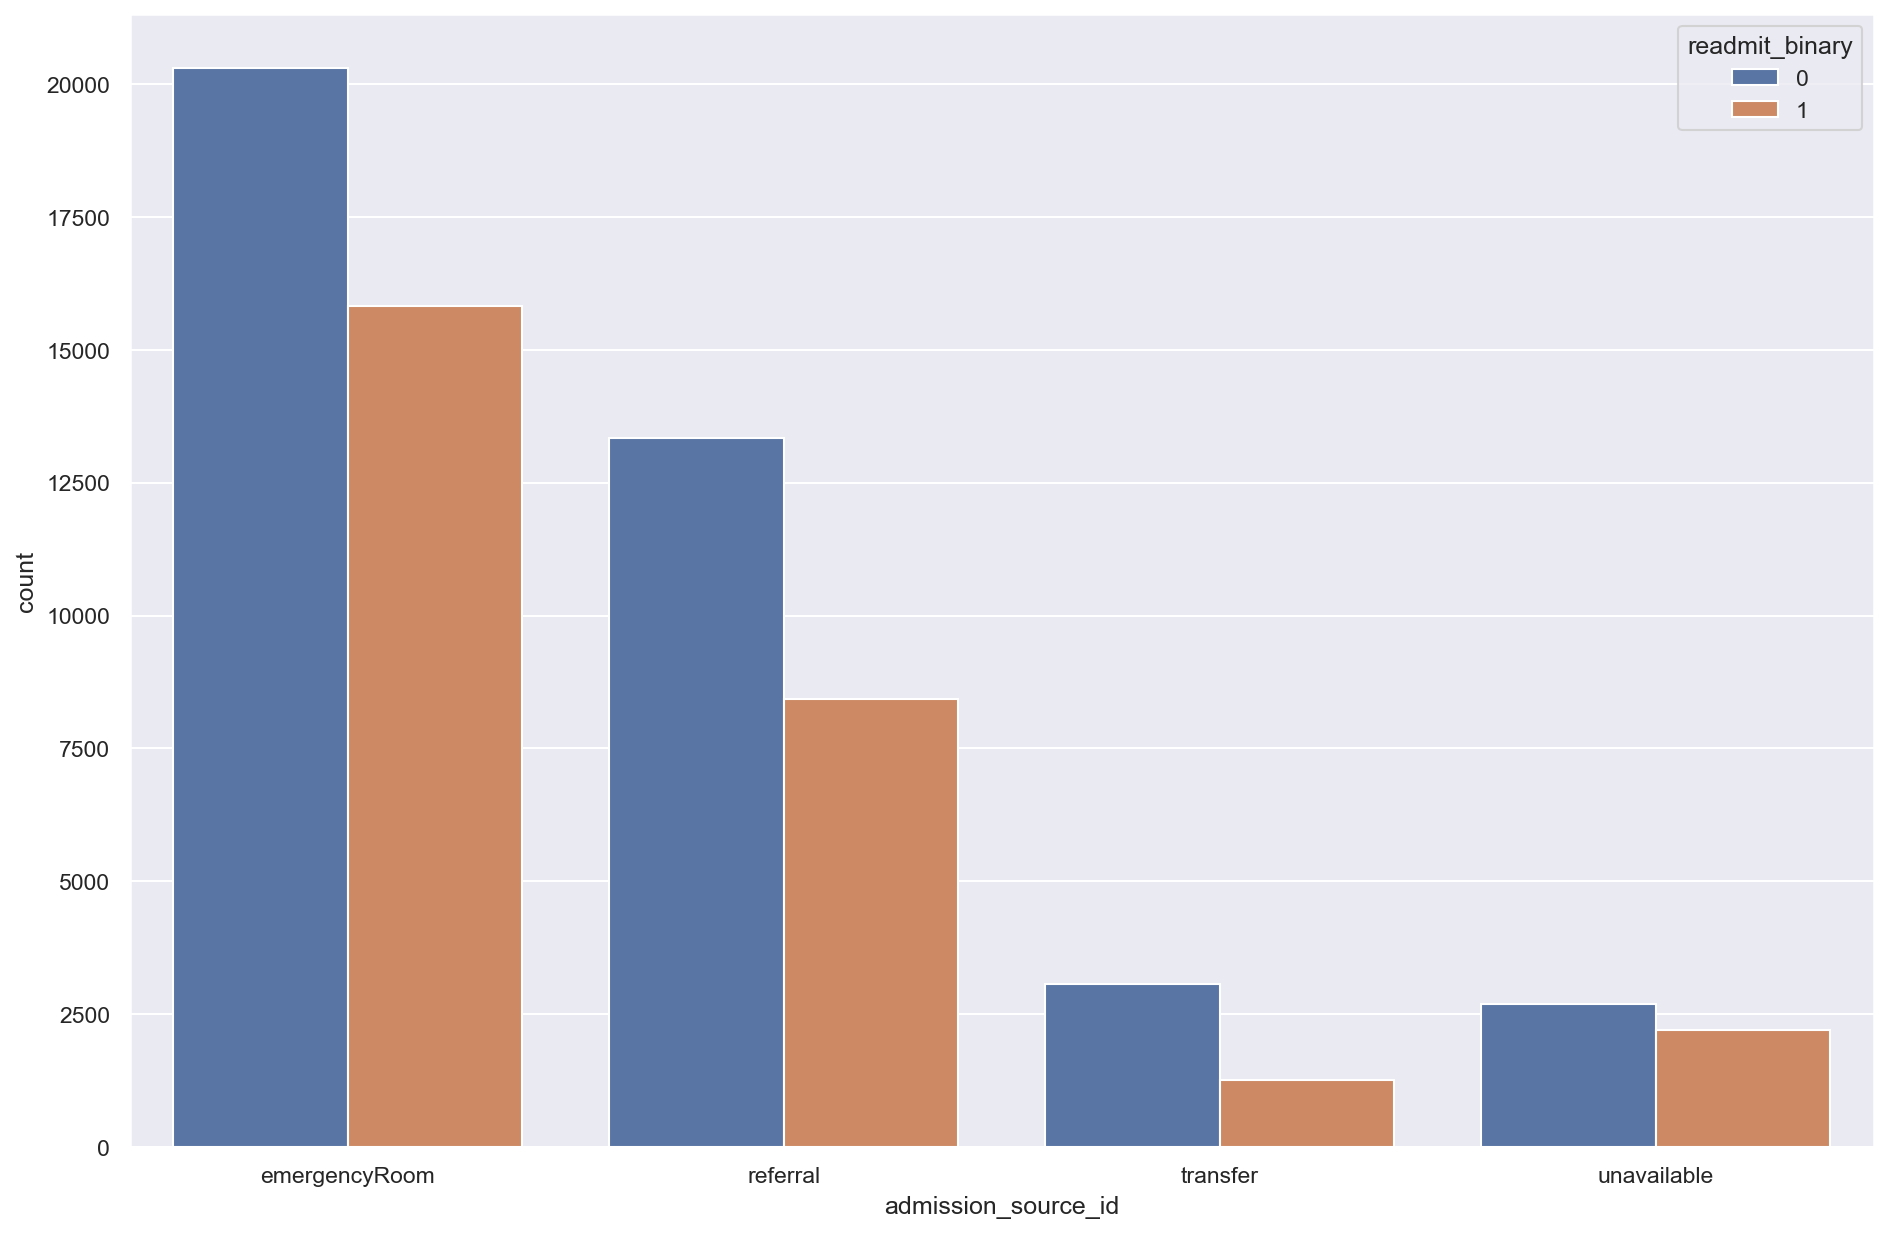

In [38]:
fig, axs = plt.subplots(figsize = (15, 10), dpi = 150)

sns.countplot(data = df_clean, x = "admission_source_id", hue = "readmit_binary")
plt.show()

## Admission_id

In [39]:
# Admission type has a total of eight categories and few of them can be re-coded into one category
admission_type_mapping = {2: 1, 7: 1, 6: 5, 8: 5}
df_clean.loc[:, 'admission_type_id'] = df_clean.loc[:, 
                                                    'admission_type_id'
                                                   ].replace(admission_type_mapping)

In [40]:
df_clean['admission_type_id'].value_counts()

1    46200
3    13269
5     7650
4        9
Name: admission_type_id, dtype: int64

In [41]:
admission_type_mapping = {1: "emergency", 3: "elective", 4: "newborn", 5: "not_available"}
df_clean.loc[:,'admission_type_id'] = df_clean.loc[:, 'admission_type_id'].replace(admission_type_mapping)

In [42]:
df_clean['admission_type_id'].value_counts()

emergency        46200
elective         13269
not_available     7650
newborn              9
Name: admission_type_id, dtype: int64

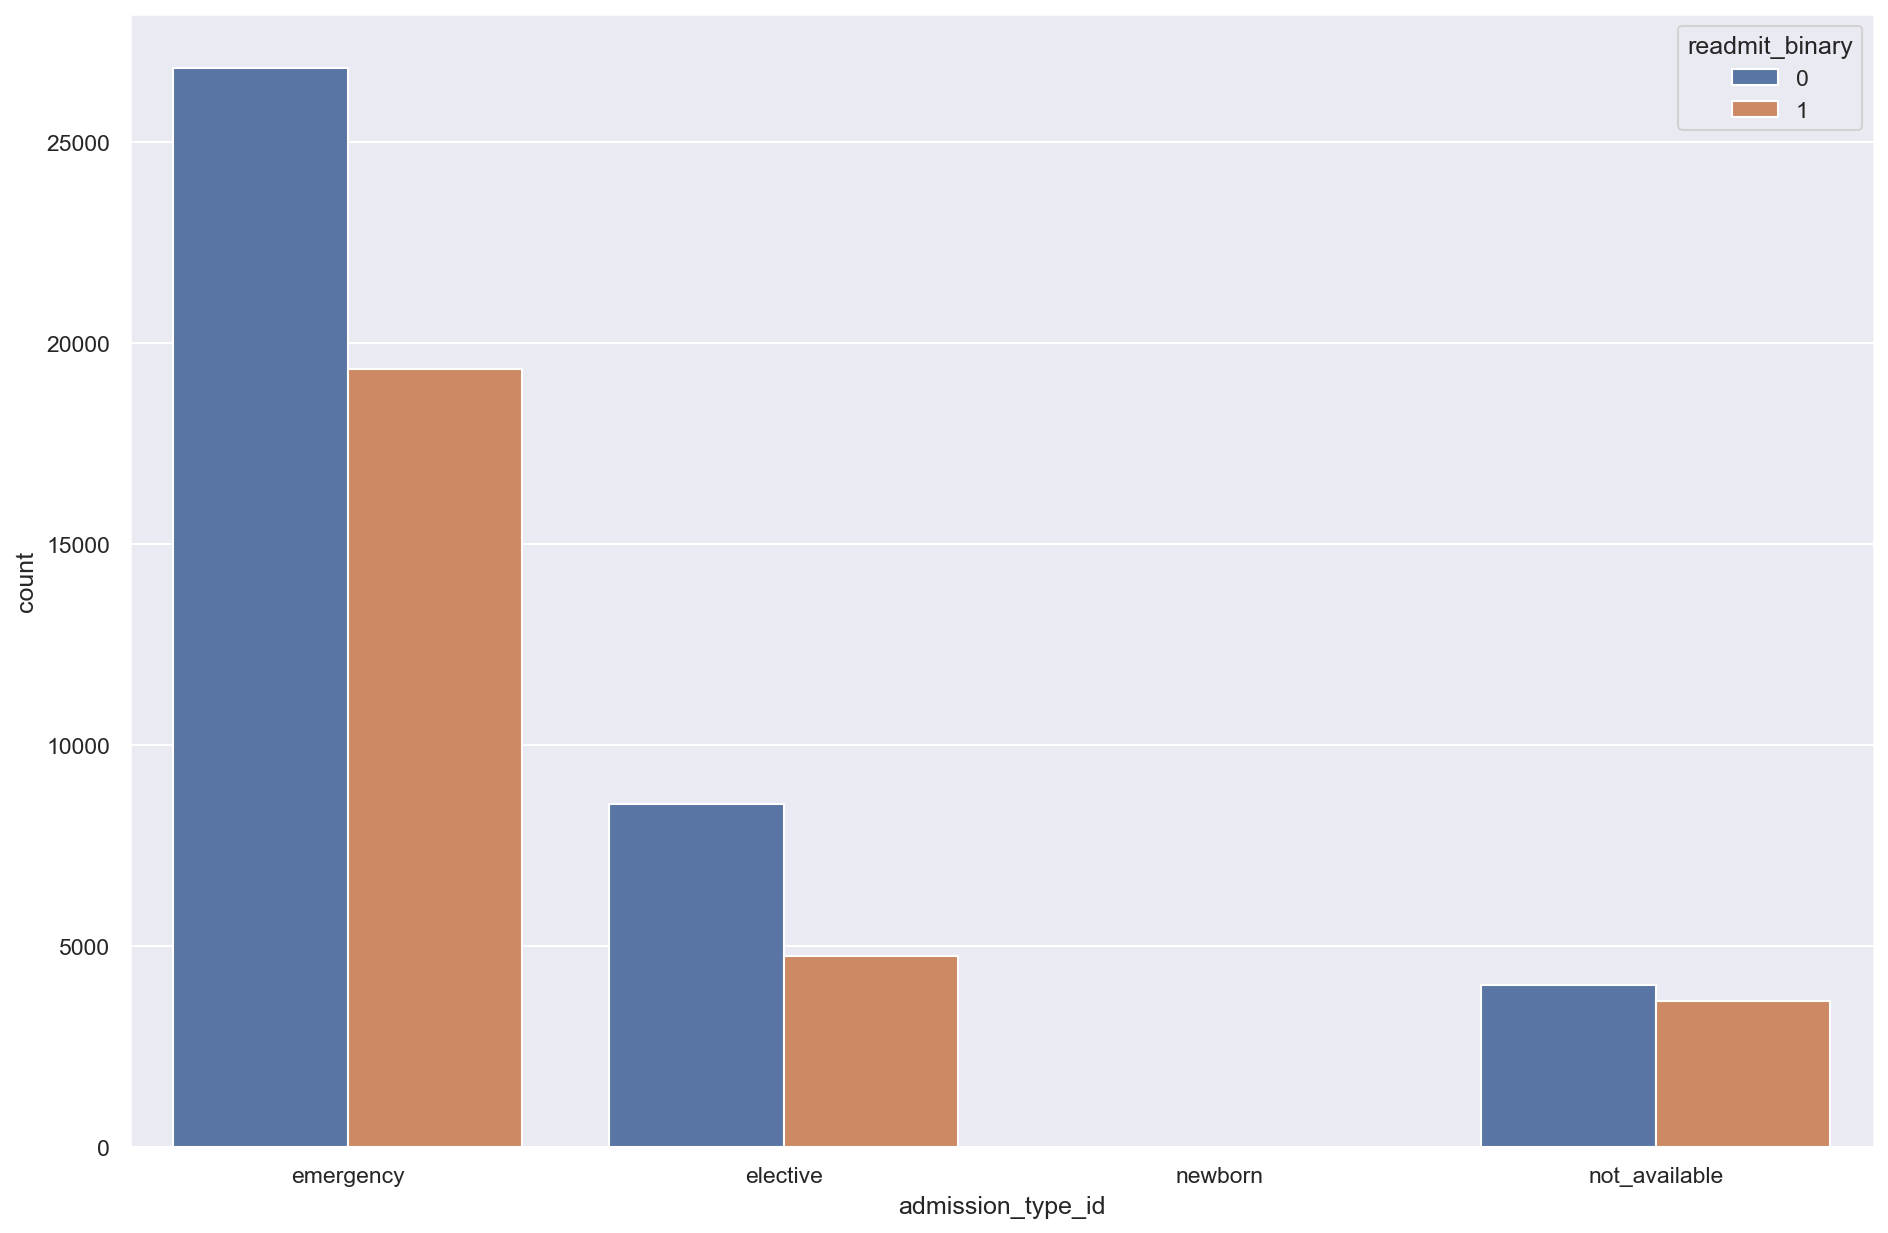

In [43]:
# Define the desired order of categories
admission_category_order = ['emergency', 'elective', 'newborn', 'not_available']

fig, axs = plt.subplots(figsize = (15, 10), dpi = 150)

sns.countplot(data = df_clean, x = "admission_type_id", hue = "readmit_binary", order = admission_category_order)
plt.show()

## Discharge_disposition_id

In [44]:
# re-coding categories into similar categories. 
# The definitions of the different numbers can be found in IDs_mapping.csv

discharge_mapping = {6: 1, 8: 1, 9: 1, 
                     3: 2, 4: 2, 5: 2, 22: 2, 23: 2, 24: 2, 27: 2, 28:2, 
                     10: 12, 15: 12, 16: 12, 17: 12, 
                     25: 18, 26: 18}

df_clean.loc[:, 'discharge_disposition_id'] = df_clean.loc[:, 
                                                           'discharge_disposition_id'
                                                          ].replace(discharge_mapping)

In [45]:
df_clean['discharge_disposition_id'].value_counts()

1     50398
2     13127
18     3158
7       386
12       59
Name: discharge_disposition_id, dtype: int64

In [46]:
discharge_type_mapping = {1: "home", 2: "transfered", 7: "left_AMA", 12: 
                          "outpatient", 18: "not_available"}
df_clean.loc[:, 'discharge_disposition_id'] = df_clean.loc[
    :, 'discharge_disposition_id'].replace(discharge_type_mapping)

In [47]:
df_clean['discharge_disposition_id'].value_counts()

home             50398
transfered       13127
not_available     3158
left_AMA           386
outpatient          59
Name: discharge_disposition_id, dtype: int64

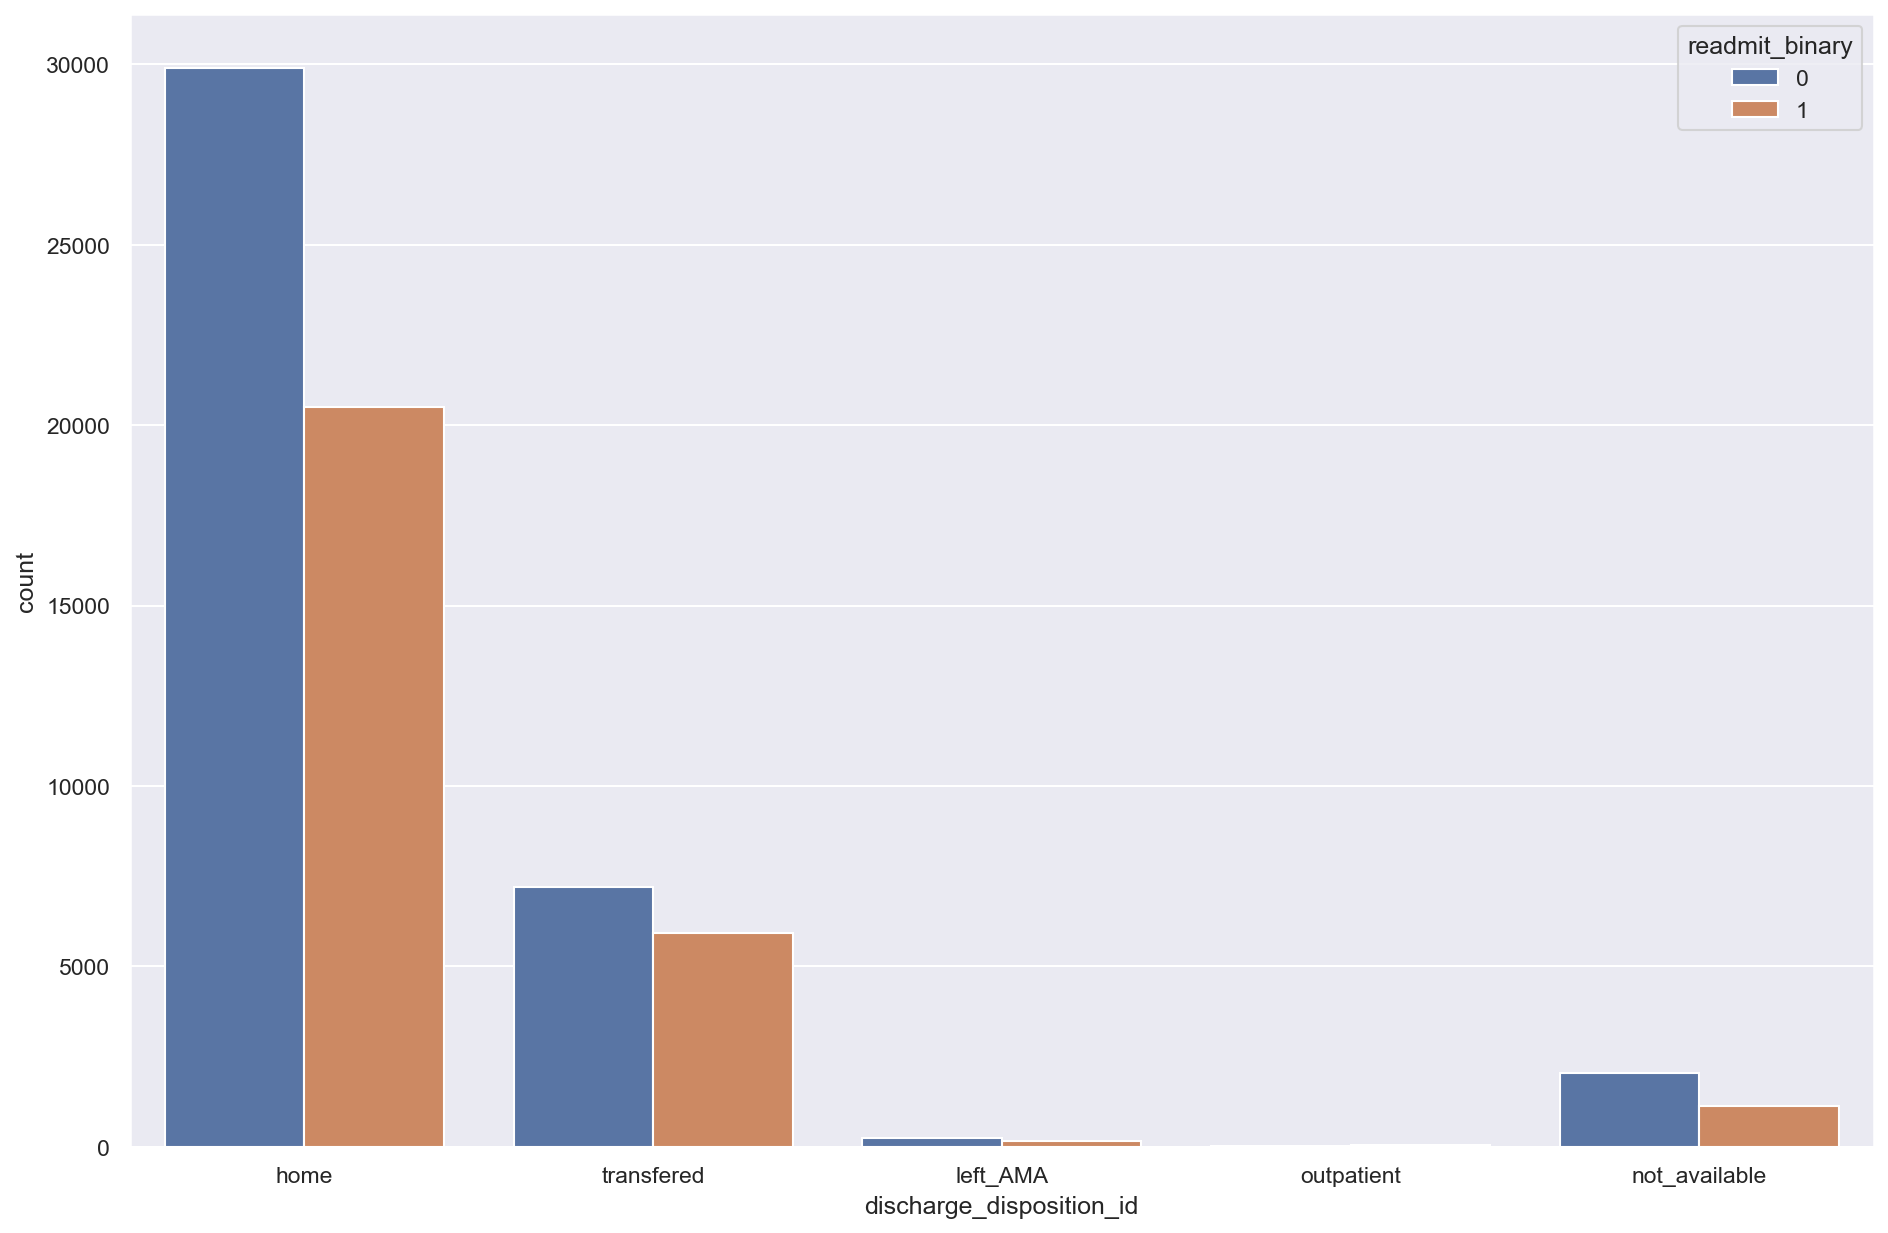

In [48]:
# Define the desired order of categories
discharge_category_order = ['home', 'transfered', 'left_AMA', 'outpatient', 'not_available']

# plotting column agaisnt target
fig, axs = plt.subplots(figsize = (15, 10), dpi = 150)

sns.countplot(data = df_clean, x = "discharge_disposition_id", hue = "readmit_binary", order=discharge_category_order)
plt.show()

## Diagnosis 1, 2, & 3

Diagnosis 1,2,& 3 shows the primary diagnosis (coded as first three digits of ICD9), secondary, and dditional secondary diagnosis.

I got the ICD-code categories from https://www.aapc.com/codes/icd9-codes-range/ since the columns contain the firs three numbers of the ICD-code. I mapped the data so that the numbers will be set as their assigned category.

In [49]:
listname = [('infections', 139),
            ('neoplasms', (239 - 139)),
            ('endocrine', (279 - 239)),
            ('blood', (289 - 279)),
            ('mental', (319 - 289)),
            ('nervous', (359 - 319)),
            ('sense', (389 - 359)),
            ('circulatory', (459-389)),
            ('respiratory', (519-459)),
            ('digestive', (579 - 519)),
            ('genitourinary', (629 - 579)),
            ('pregnancy', (679 - 629)),
            ('skin', (709 - 679)),
            ('musculoskeletal', (739 - 709)),
            ('congenital', (759 - 739)),
            ('perinatal', (779 - 759)),
            ('ill-defined', (799 - 779)),
            ('injury', (999 - 799))]

The `categorize_diagnosis` function is used to assign numerical values to specific categories. It takes in a numerical value and a list of categories, where each category is represented by a tuple containing a category name and a corresponding range value. The function attempts to convert the input value to a float and then iterates through the list of categories. It checks if the value falls within the range of each category and returns the corresponding category if it does. If the value is greater than the range for a category, it subtracts the range value and moves to the next category. If the value cannot be converted to a float or doesn't match any category, it returns 'unknown'.

The `replace_diag_values` function is used to transform diagnosis values. It takes in a value, typically a diagnosis code, and checks if the first character, converted to lowercase, is either 'v' or 'e'. If it matches, the function returns 'other'. Otherwise, it returns the original value. This function is often used in data preprocessing or feature engineering tasks to categorize or replace certain diagnosis codes with a more generalized category, such as 'other'.

In [50]:
def categorize_diagnosis(value, categories):
    try:
        value = float(value)  # Convert value to a float
        for category, range_value in categories:
            if value <= range_value:
                return category
            else:
                value -= range_value
    except ValueError:
        pass
    return 'unknown'

def replace_diag_values(value):
    if value[0].lower() in ['v', 'e']:
        return 'other'
    else:
        return value

In [51]:
columns_to_categorize = ['diag_1', 'diag_2', 'diag_3']

for column in columns_to_categorize:
    df_clean[column] = df_clean[column].apply(categorize_diagnosis, args=(listname,))
    df_clean[column] = df_clean[column].apply(replace_diag_values)

In [52]:
display(df_clean['diag_1'].value_counts())
display(df_clean['diag_2'].value_counts())
display(df_clean['diag_3'].value_counts())

circulatory        20696
other               6897
respiratory         6235
digestive           6099
ill-defined         5326
injury              4487
musculoskeletal     3872
genitourinary       3320
neoplasms           2435
skin                1710
infections          1632
mental              1455
unknown              892
blood                640
nervous              626
pregnancy            559
sense                207
congenital            40
Name: diag_1, dtype: int64

circulatory        21210
other              14303
respiratory         6286
genitourinary       4936
ill-defined         3064
digestive           2624
skin                2139
blood               2023
mental              1769
injury              1744
unknown             1731
neoplasms           1562
musculoskeletal     1254
infections          1188
nervous              744
pregnancy            351
sense                122
congenital            78
Name: diag_2, dtype: int64

circulatory        20127
other              18496
respiratory         4146
genitourinary       3691
unknown             3458
ill-defined         3003
digestive           2393
mental              2089
blood               1699
skin                1473
injury              1365
musculoskeletal     1327
infections          1202
neoplasms           1129
nervous              987
pregnancy            269
sense                203
congenital            71
Name: diag_3, dtype: int64

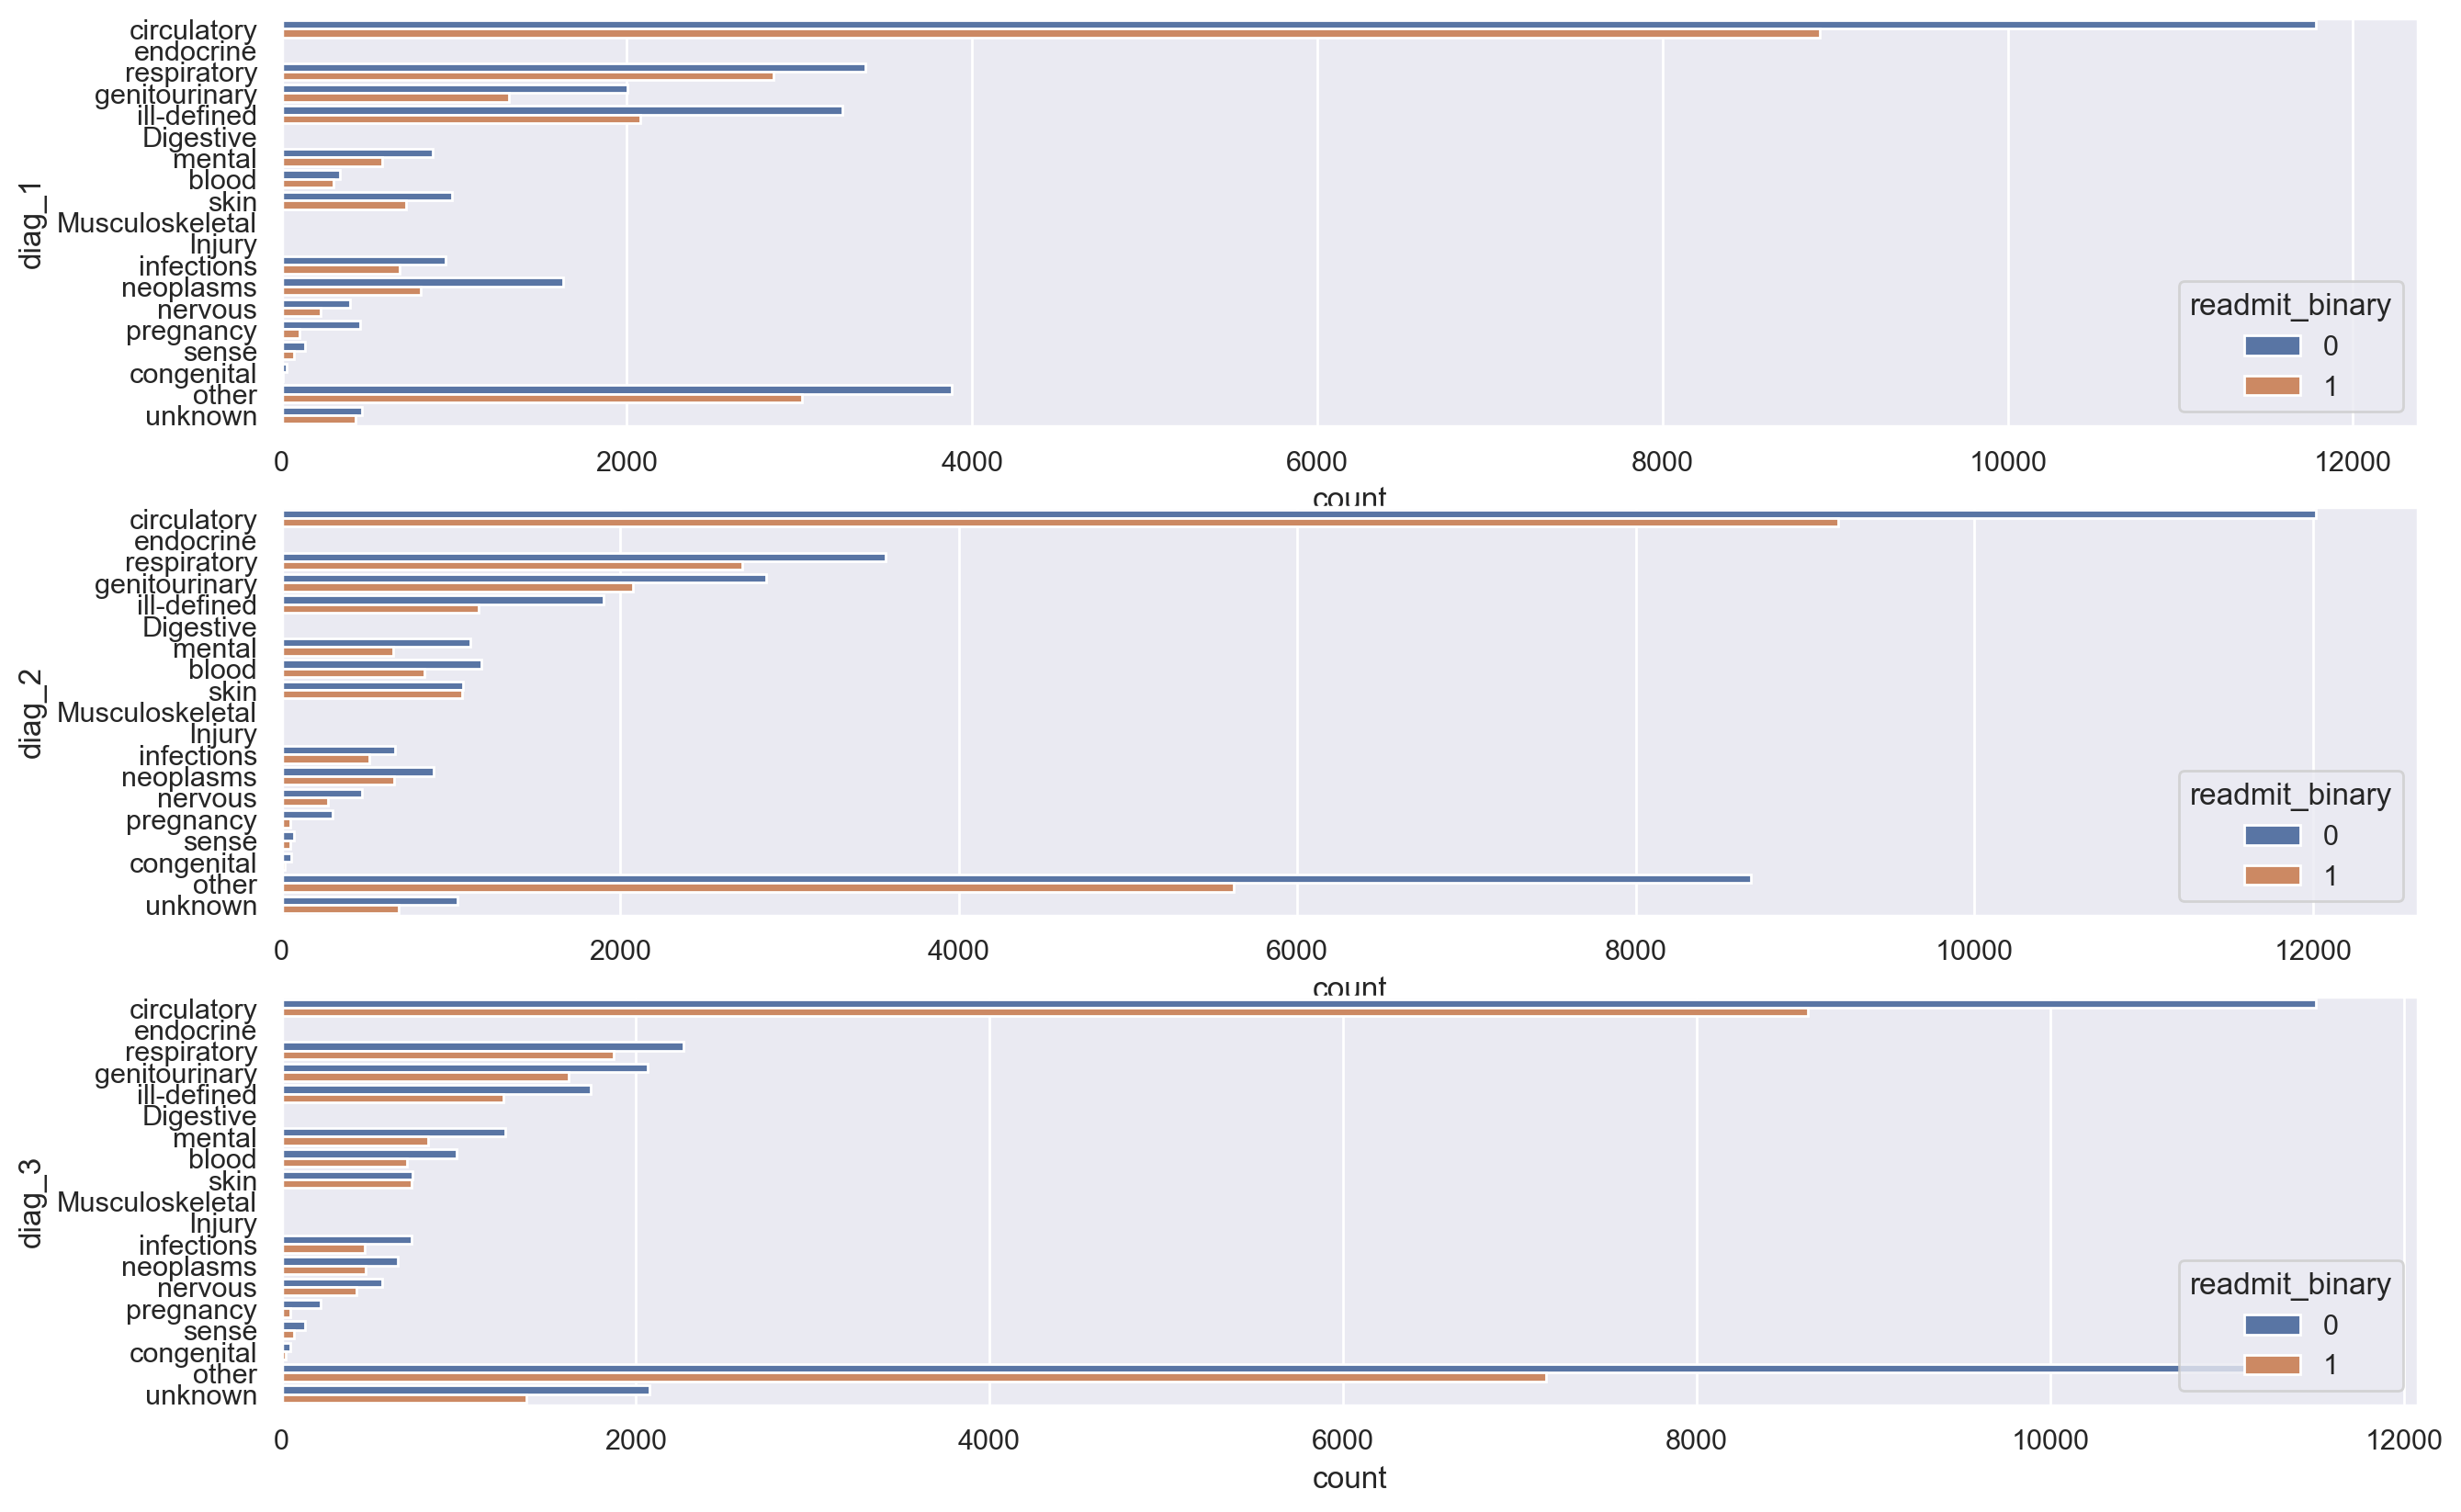

In [54]:
list_diag = ['circulatory', 'endocrine', 'respiratory', 'genitourinary', 
             'ill-defined', 'Digestive', 'mental', 'blood', 'skin', 
             'Musculoskeletal', 'Injury', 'infections', 'neoplasms', 'nervous', 
             'pregnancy', 'sense', 'congenital', 'other',  'unknown']

# graph
fig, axs = plt.subplots(3, 1, figsize = (15, 10), dpi=200)

sns.countplot(data = df_clean, y = "diag_1", hue = "readmit_binary", ax = axs[0], order = list_diag)
sns.countplot(data = df_clean, y = "diag_2", hue = "readmit_binary", ax = axs[1], order = list_diag)
sns.countplot(data = df_clean, y = "diag_3", hue = "readmit_binary", ax = axs[2], order = list_diag)
plt.show()

There doesn't seem to be a category that stands out for any of the diagnosis, but circulatory seems like the most common diagnosis for all three diagnosis.

# More EDA

In [55]:
df_clean['num_lab_procedures'].value_counts()

1      2167
43     1803
44     1564
45     1543
46     1455
       ... 
132       1
107       1
114       1
118       1
121       1
Name: num_lab_procedures, Length: 116, dtype: int64

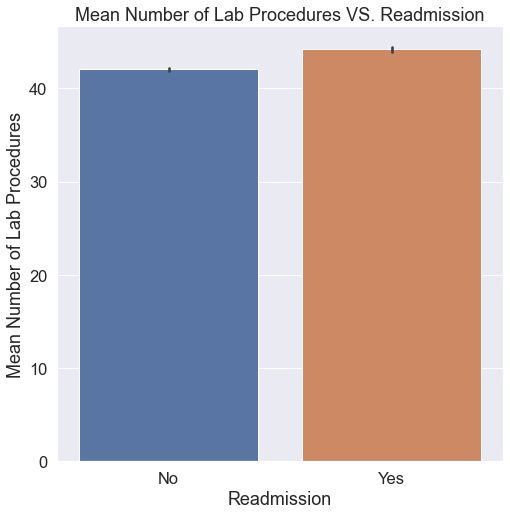

''

In [312]:
fig = plt.figure(figsize=(8, 8))
ax = sns.barplot(x=df_clean['readmit_binary'], y=df_clean['num_lab_procedures'])

# Set the x tick labels
ax.set_xticklabels(['No', 'Yes'])

# Set the axis labels
ax.set_xlabel('Readmission')
ax.set_ylabel('Mean Number of Lab Procedures')

# Set the title
ax.set_title("Mean Number of Lab Procedures VS. Readmission")

# save figure
plt.savefig('images/num_lab_procedures.png')

plt.show()
;

The readmitted patients have a higher mean of number of lab procedures.

In [57]:
df_clean['num_medications'].value_counts()

13    4121
12    4097
11    3866
15    3770
10    3719
      ... 
70       2
75       2
74       1
79       1
81       1
Name: num_medications, Length: 75, dtype: int64

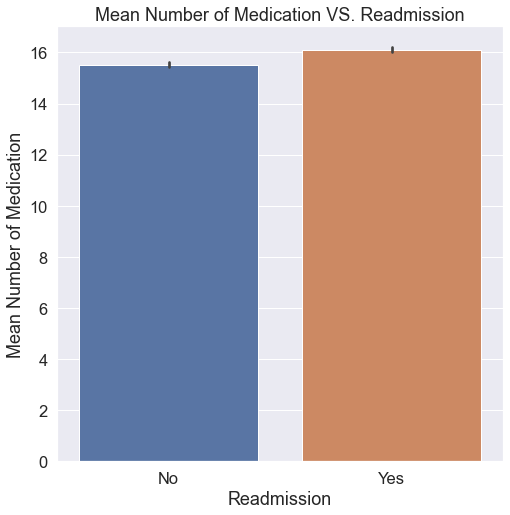

''

In [313]:
fig = plt.figure(figsize=(8, 8))
ax = sns.barplot(x=df_clean['readmit_binary'], y=df_clean['num_medications'])

# Set the x tick labels
ax.set_xticklabels(['No', 'Yes'])

# Set the axis labels
ax.set_xlabel('Readmission')
ax.set_ylabel('Mean Number of Medication')

# Set the title
ax.set_title("Mean Number of Medication VS. Readmission")

# save figure
plt.savefig('images/num_medications.png')

plt.show()
;

The readmitted patients have a higher mean of number of medications given during the visit.

In [59]:
df_clean['number_diagnoses'].value_counts()

9     30167
5      8267
6      7439
7      7327
8      7237
4      4317
3      2307
16       27
13       10
10        8
12        6
11        6
15        5
14        5
Name: number_diagnoses, dtype: int64

''

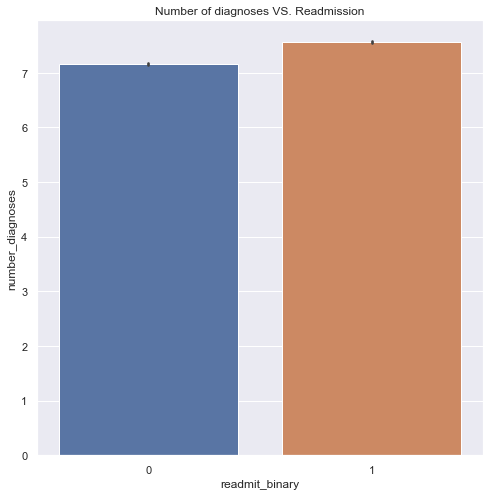

In [60]:
fig = plt.figure(figsize=(8,8))
sns.barplot(x = df_clean['readmit_binary'], 
            y = df_clean['number_diagnoses']
           ).set_title("Number of diagnoses VS. Readmission")
;

The readmitted patients have a higher mean of number of diagnoses entered to the system.

In [61]:
df_clean['max_glu_serum'].value_counts()

None    63875
Norm     1656
>200      906
>300      691
Name: max_glu_serum, dtype: int64

In [62]:
df_clean.groupby('max_glu_serum')['readmit_binary'].value_counts().sort_values(ascending=False)

max_glu_serum  readmit_binary
None           0                 37618
               1                 26257
Norm           0                   956
               1                   700
>200           0                   486
               1                   420
>300           1                   350
               0                   341
Name: readmit_binary, dtype: int64

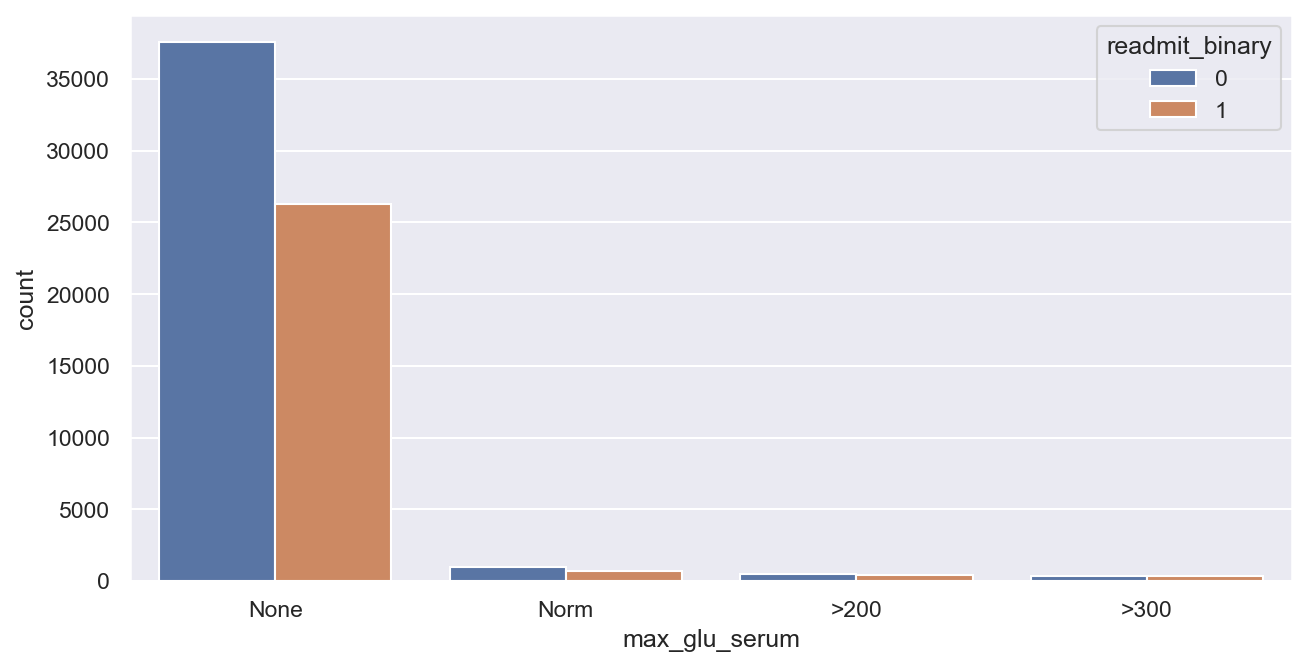

In [63]:
# Define the desired order of categories
glu_category_order = ['None', 'Norm', '>200', '>300']

fig, axs = plt.subplots(figsize = (10, 5), dpi = 150)

sns.countplot(data = df_clean, x = "max_glu_serum", hue = "readmit_binary", order=glu_category_order)
plt.show()

As the glucose serum levels get higher, there are more percentage out of total patients getting readmitted.

In [64]:
# The A1C test is a blood test that provides information about your average levels 
# of blood glucose, also called blood sugar, over the past 3 months.

df_clean['A1Cresult'].value_counts()

None    54985
>8       5730
Norm     3633
>7       2780
Name: A1Cresult, dtype: int64

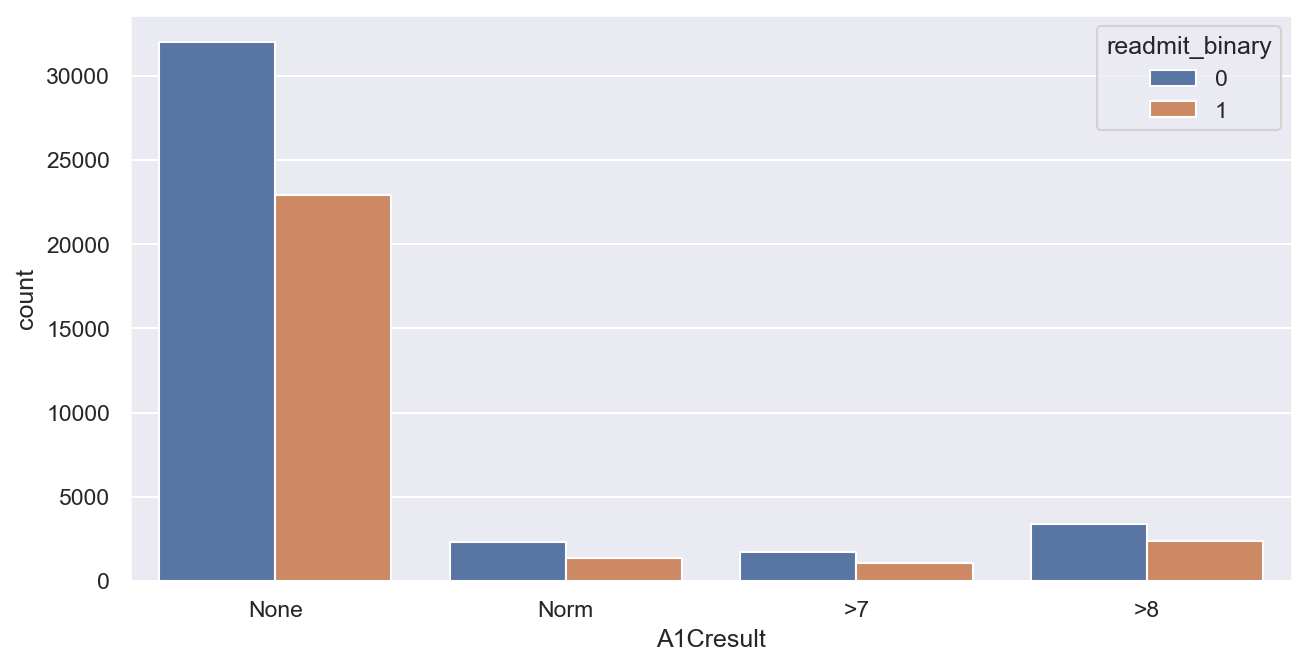

In [65]:
# Define the desired order of categories
A1C_category_order = ['None', 'Norm', '>7', '>8']

fig, axs = plt.subplots(figsize = (10, 5), dpi = 150)

sns.countplot(data = df_clean, x = "A1Cresult", hue = "readmit_binary", order=A1C_category_order)
plt.show()

In [66]:
df_clean['age'].value_counts()

[70-80)     17191
[60-70)     15150
[50-60)     11886
[80-90)     10773
[40-50)      6482
[30-40)      2519
[90-100)     1704
[20-30)      1003
[10-20)       357
[0-10)         63
Name: age, dtype: int64

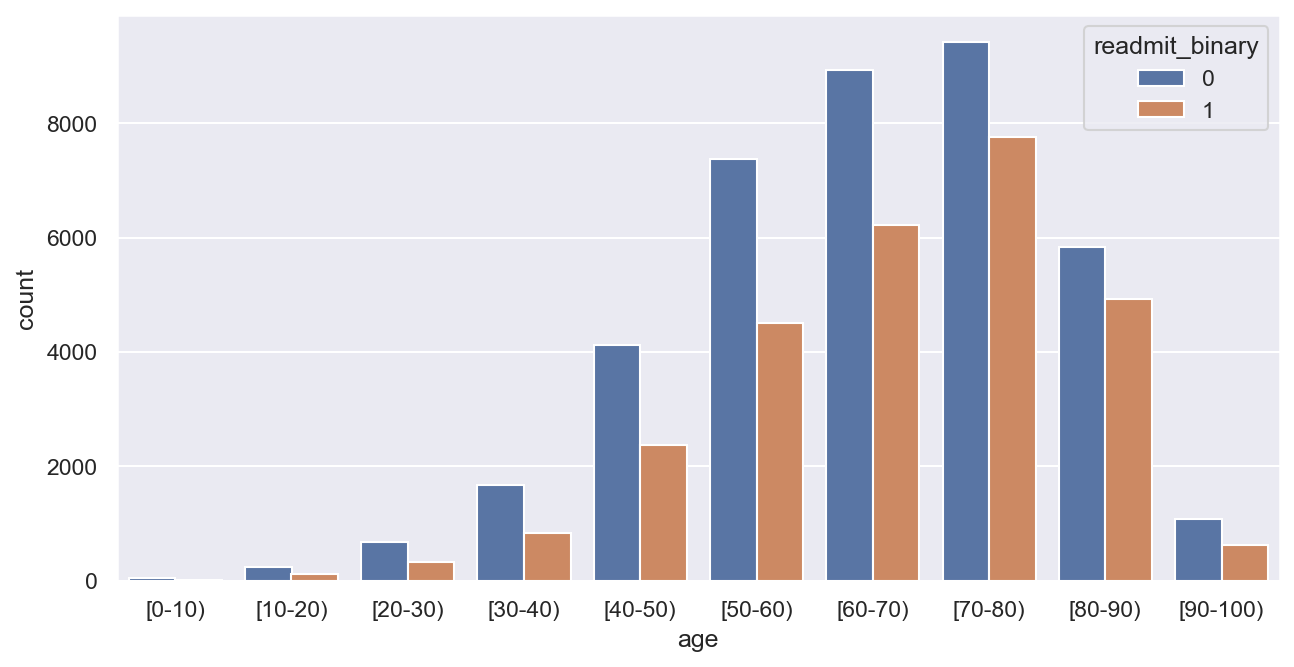

In [67]:
# Define the desired order of categories
age_category_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', 
                          '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']

fig, axs = plt.subplots(figsize = (10, 5), dpi = 150)

sns.countplot(data = df_clean, x = "age", hue = "readmit_binary", order=age_category_order)
plt.show()

Seems like the age of patients who get readmitted are generally higher than those who don't get readmitted.

In [68]:
df_clean['insulin'].value_counts()

No        33110
Steady    20469
Down       7065
Up         6484
Name: insulin, dtype: int64

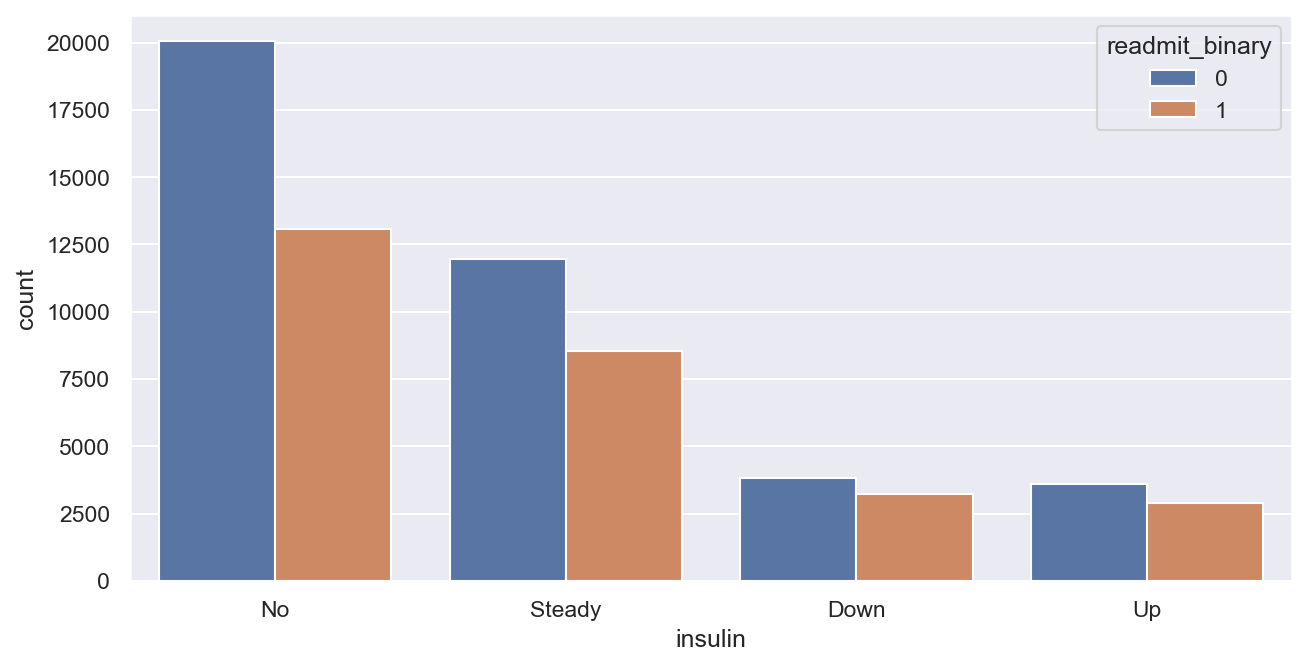

In [69]:
insulin_category_order = ['No', 'Steady', 'Down', 'Up']

fig, axs = plt.subplots(figsize = (10, 5), dpi = 150)

sns.countplot(data = df_clean, x = "insulin", hue = "readmit_binary", order=insulin_category_order)
plt.show()

In [70]:
df_clean['diabetesMed'].value_counts()

Yes    51003
No     16125
Name: diabetesMed, dtype: int64

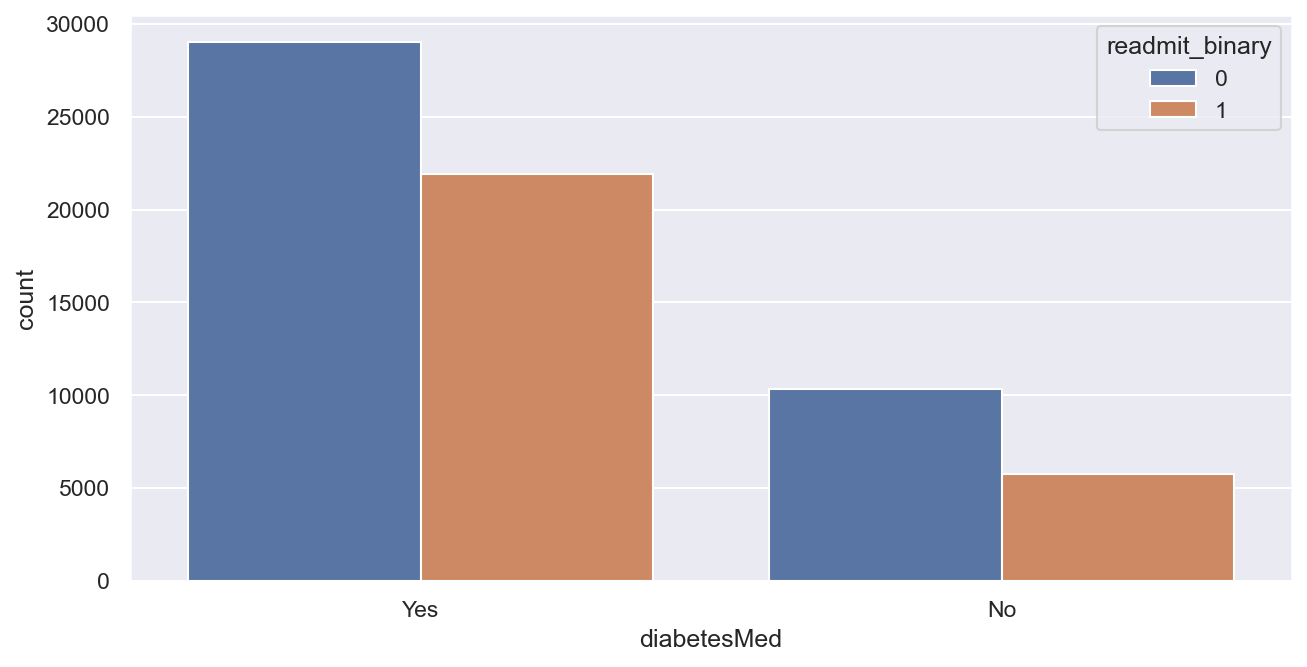

In [71]:
fig, axs = plt.subplots(figsize = (10, 5), dpi = 150)

sns.countplot(data = df_clean, x = "diabetesMed", hue = "readmit_binary")
plt.show()

Interesting that the patients not on diabetes med still have more that are not readmitted than those who are.

In [72]:
df_clean['race'].value_counts()

Caucasian          51653
AfricanAmerican    12405
Hispanic            1461
Other               1132
Asian                477
Name: race, dtype: int64

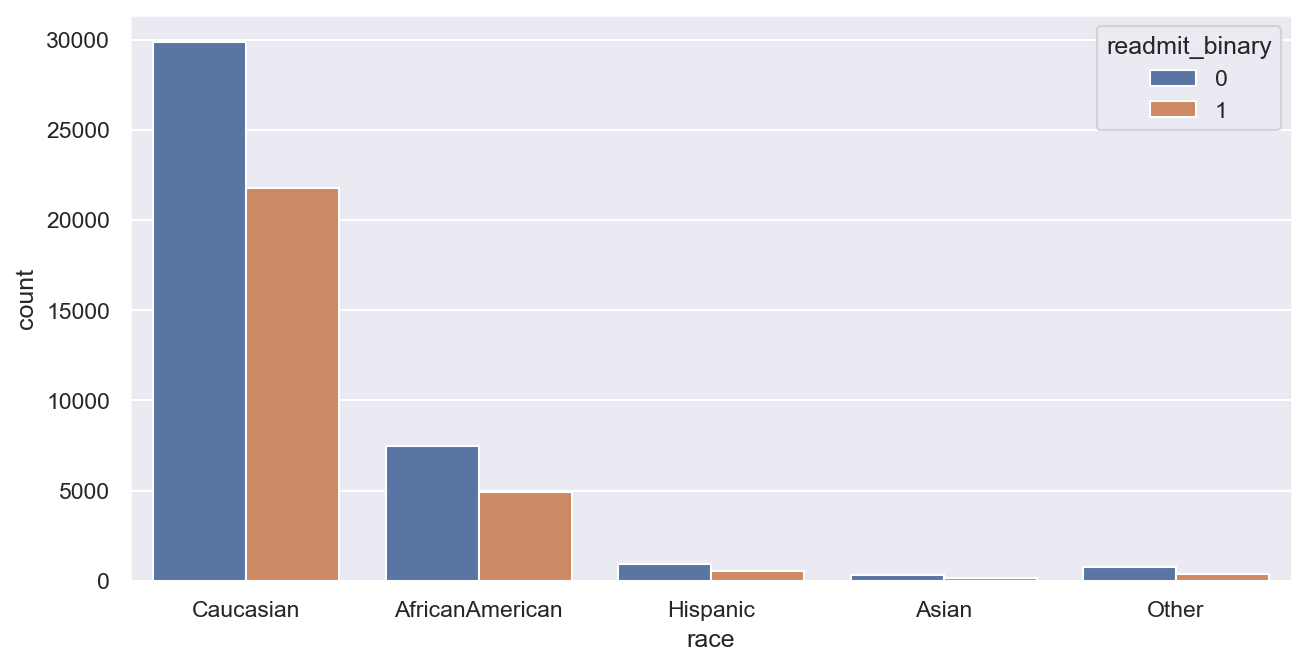

In [73]:
# Define the desired order of categories
race_category_order = ['Caucasian', 'AfricanAmerican', 'Hispanic', 'Asian', 'Other']

fig, axs = plt.subplots(figsize = (10, 5), dpi = 150)

sns.countplot(data = df_clean, x = "race", hue = "readmit_binary", order=race_category_order)
plt.show()

In [74]:
df_clean['gender'].value_counts()

Female    35808
Male      31320
Name: gender, dtype: int64

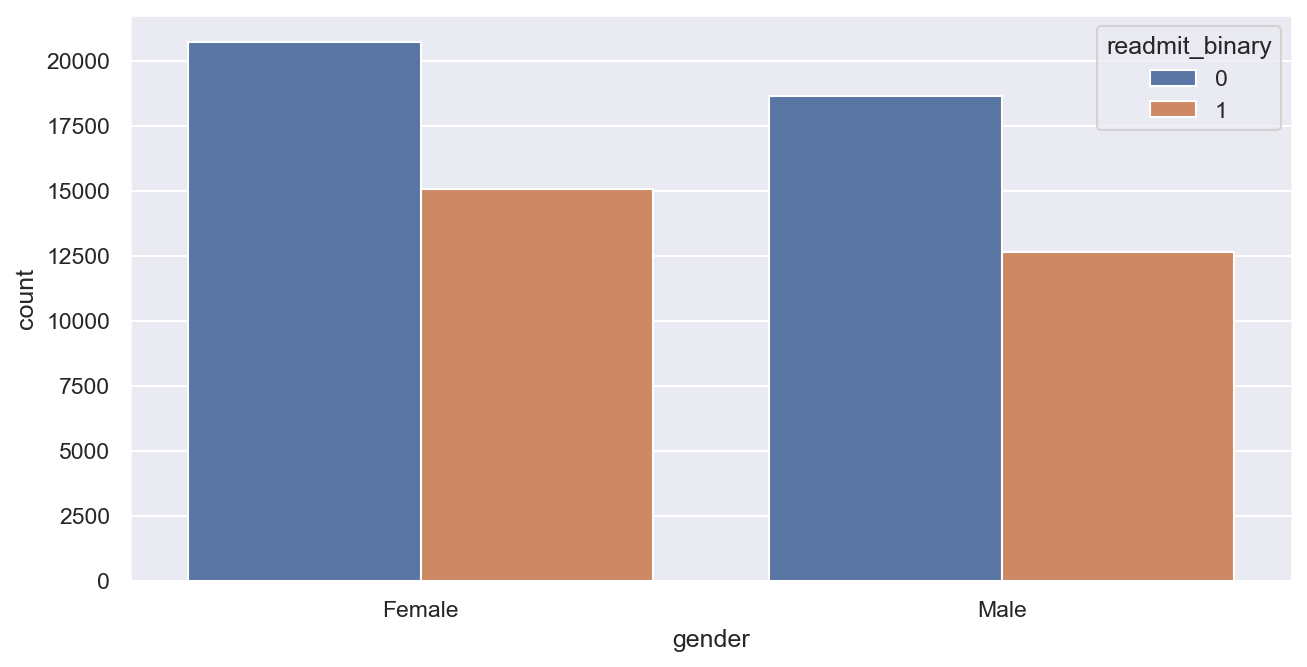

In [75]:
fig, axs = plt.subplots(figsize = (10, 5), dpi = 150)

sns.countplot(data = df_clean, x = "gender", hue = "readmit_binary")
plt.show()

In [76]:
df_clean['number_emergency'].value_counts()

0     62100
1      3825
2       779
3       240
4        94
5        31
6        25
8         9
7         8
10        5
9         4
11        2
37        1
13        1
16        1
20        1
25        1
42        1
Name: number_emergency, dtype: int64

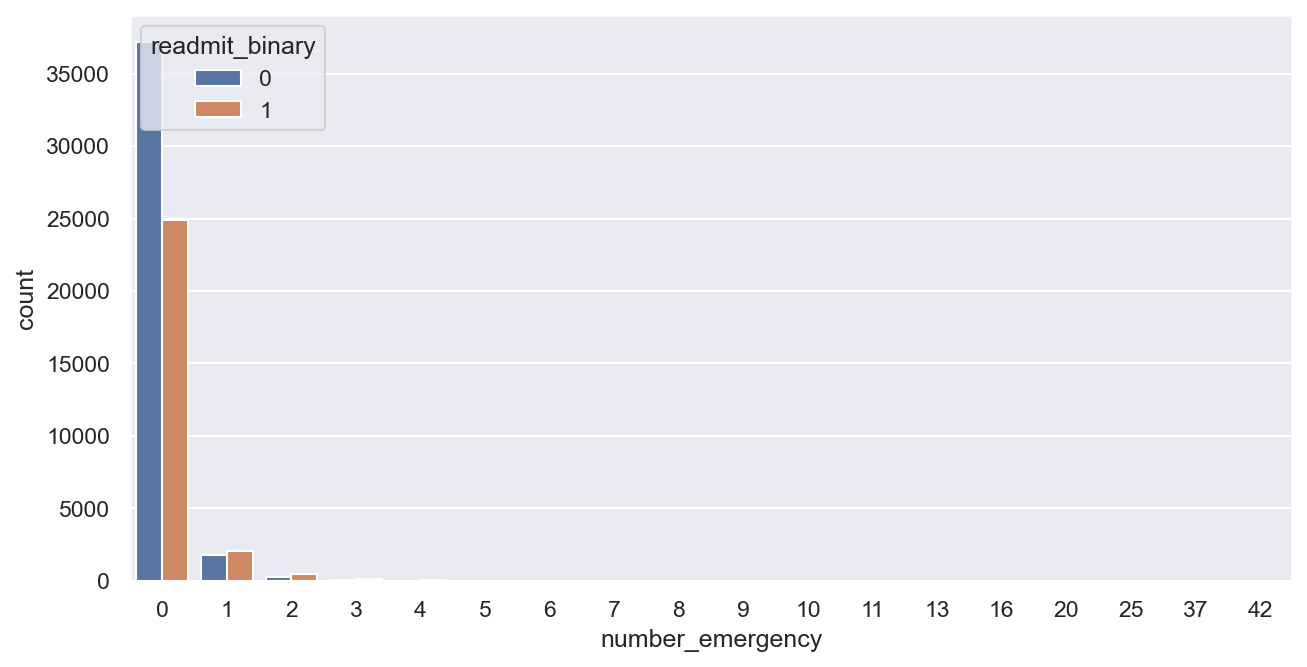

In [77]:
fig, axs = plt.subplots(figsize = (10, 5), dpi = 150)

sns.countplot(data = df_clean, x = "number_emergency", hue = "readmit_binary")
plt.show()

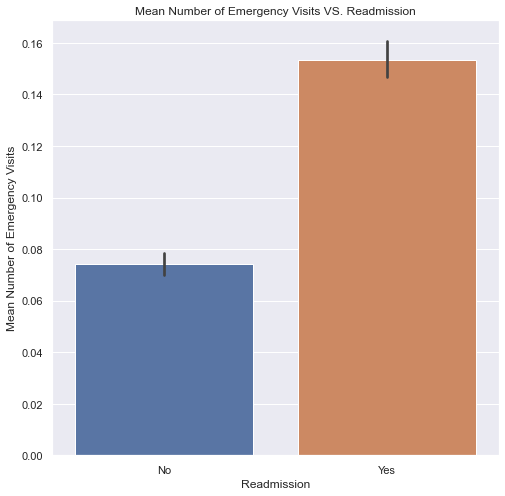

''

In [78]:
fig = plt.figure(figsize=(8, 8))
ax = sns.barplot(x=df_clean['readmit_binary'], y=df_clean['number_emergency'])

# Set the x tick labels
ax.set_xticklabels(['No', 'Yes'])

# Set the axis labels
ax.set_xlabel('Readmission')
ax.set_ylabel('Mean Number of Emergency Visits')

# Set the title
ax.set_title("Mean Number of Emergency Visits VS. Readmission")

# save figure
#plt.savefig('images/number_emergency.png')

plt.show()
;

# Checking for Skewness and Kurtosis (for logistic regression)

**Skewness and kurtosis** are statistical measures used to assess the shape and distribution of a variable. They can provide insights into the symmetry, tail heaviness, and presence of outliers in the data.

Skewness: Skewness measures the asymmetry of the distribution. It indicates whether the data is skewed to the left (negative skew) or to the right (positive skew), or if it is approximately symmetric (skewness close to zero). Skewness values greater than +1 or less than -1 suggest significant skewness.

- Positive skewness: The tail is longer on the right side, indicating a concentration of values on the left side.
- Negative skewness: The tail is longer on the left side, indicating a concentration of values on the right side.
- Skewness close to zero: The distribution is approximately symmetric.


Kurtosis: Kurtosis measures the heaviness of the tails and the presence of outliers. It tells us whether the data has heavy tails (leptokurtic) or light tails (platykurtic) compared to a normal distribution.

- Leptokurtic: Positive kurtosis indicates heavy tails, meaning the distribution has more outliers and extreme values.
- Platykurtic: Negative kurtosis indicates light tails, meaning the distribution has fewer outliers and extreme values.
- Mesokurtic: Kurtosis close to zero indicates a normal distribution with tails similar to a normal distribution.

In [79]:
# Get the list of the numerical variable  
num_features = list(set(list(df_clean._get_numeric_data().columns))- {'encounter_id', 'patient_nbr', 
                                                                      'readmitted'})
num_features

['num_change',
 'num_lab_procedures',
 'num_meds',
 'num_procedures',
 'number_outpatient',
 'readmit_binary',
 'number_inpatient',
 'num_service',
 'number_diagnoses',
 'num_medications',
 'number_emergency',
 'time_in_hospital']

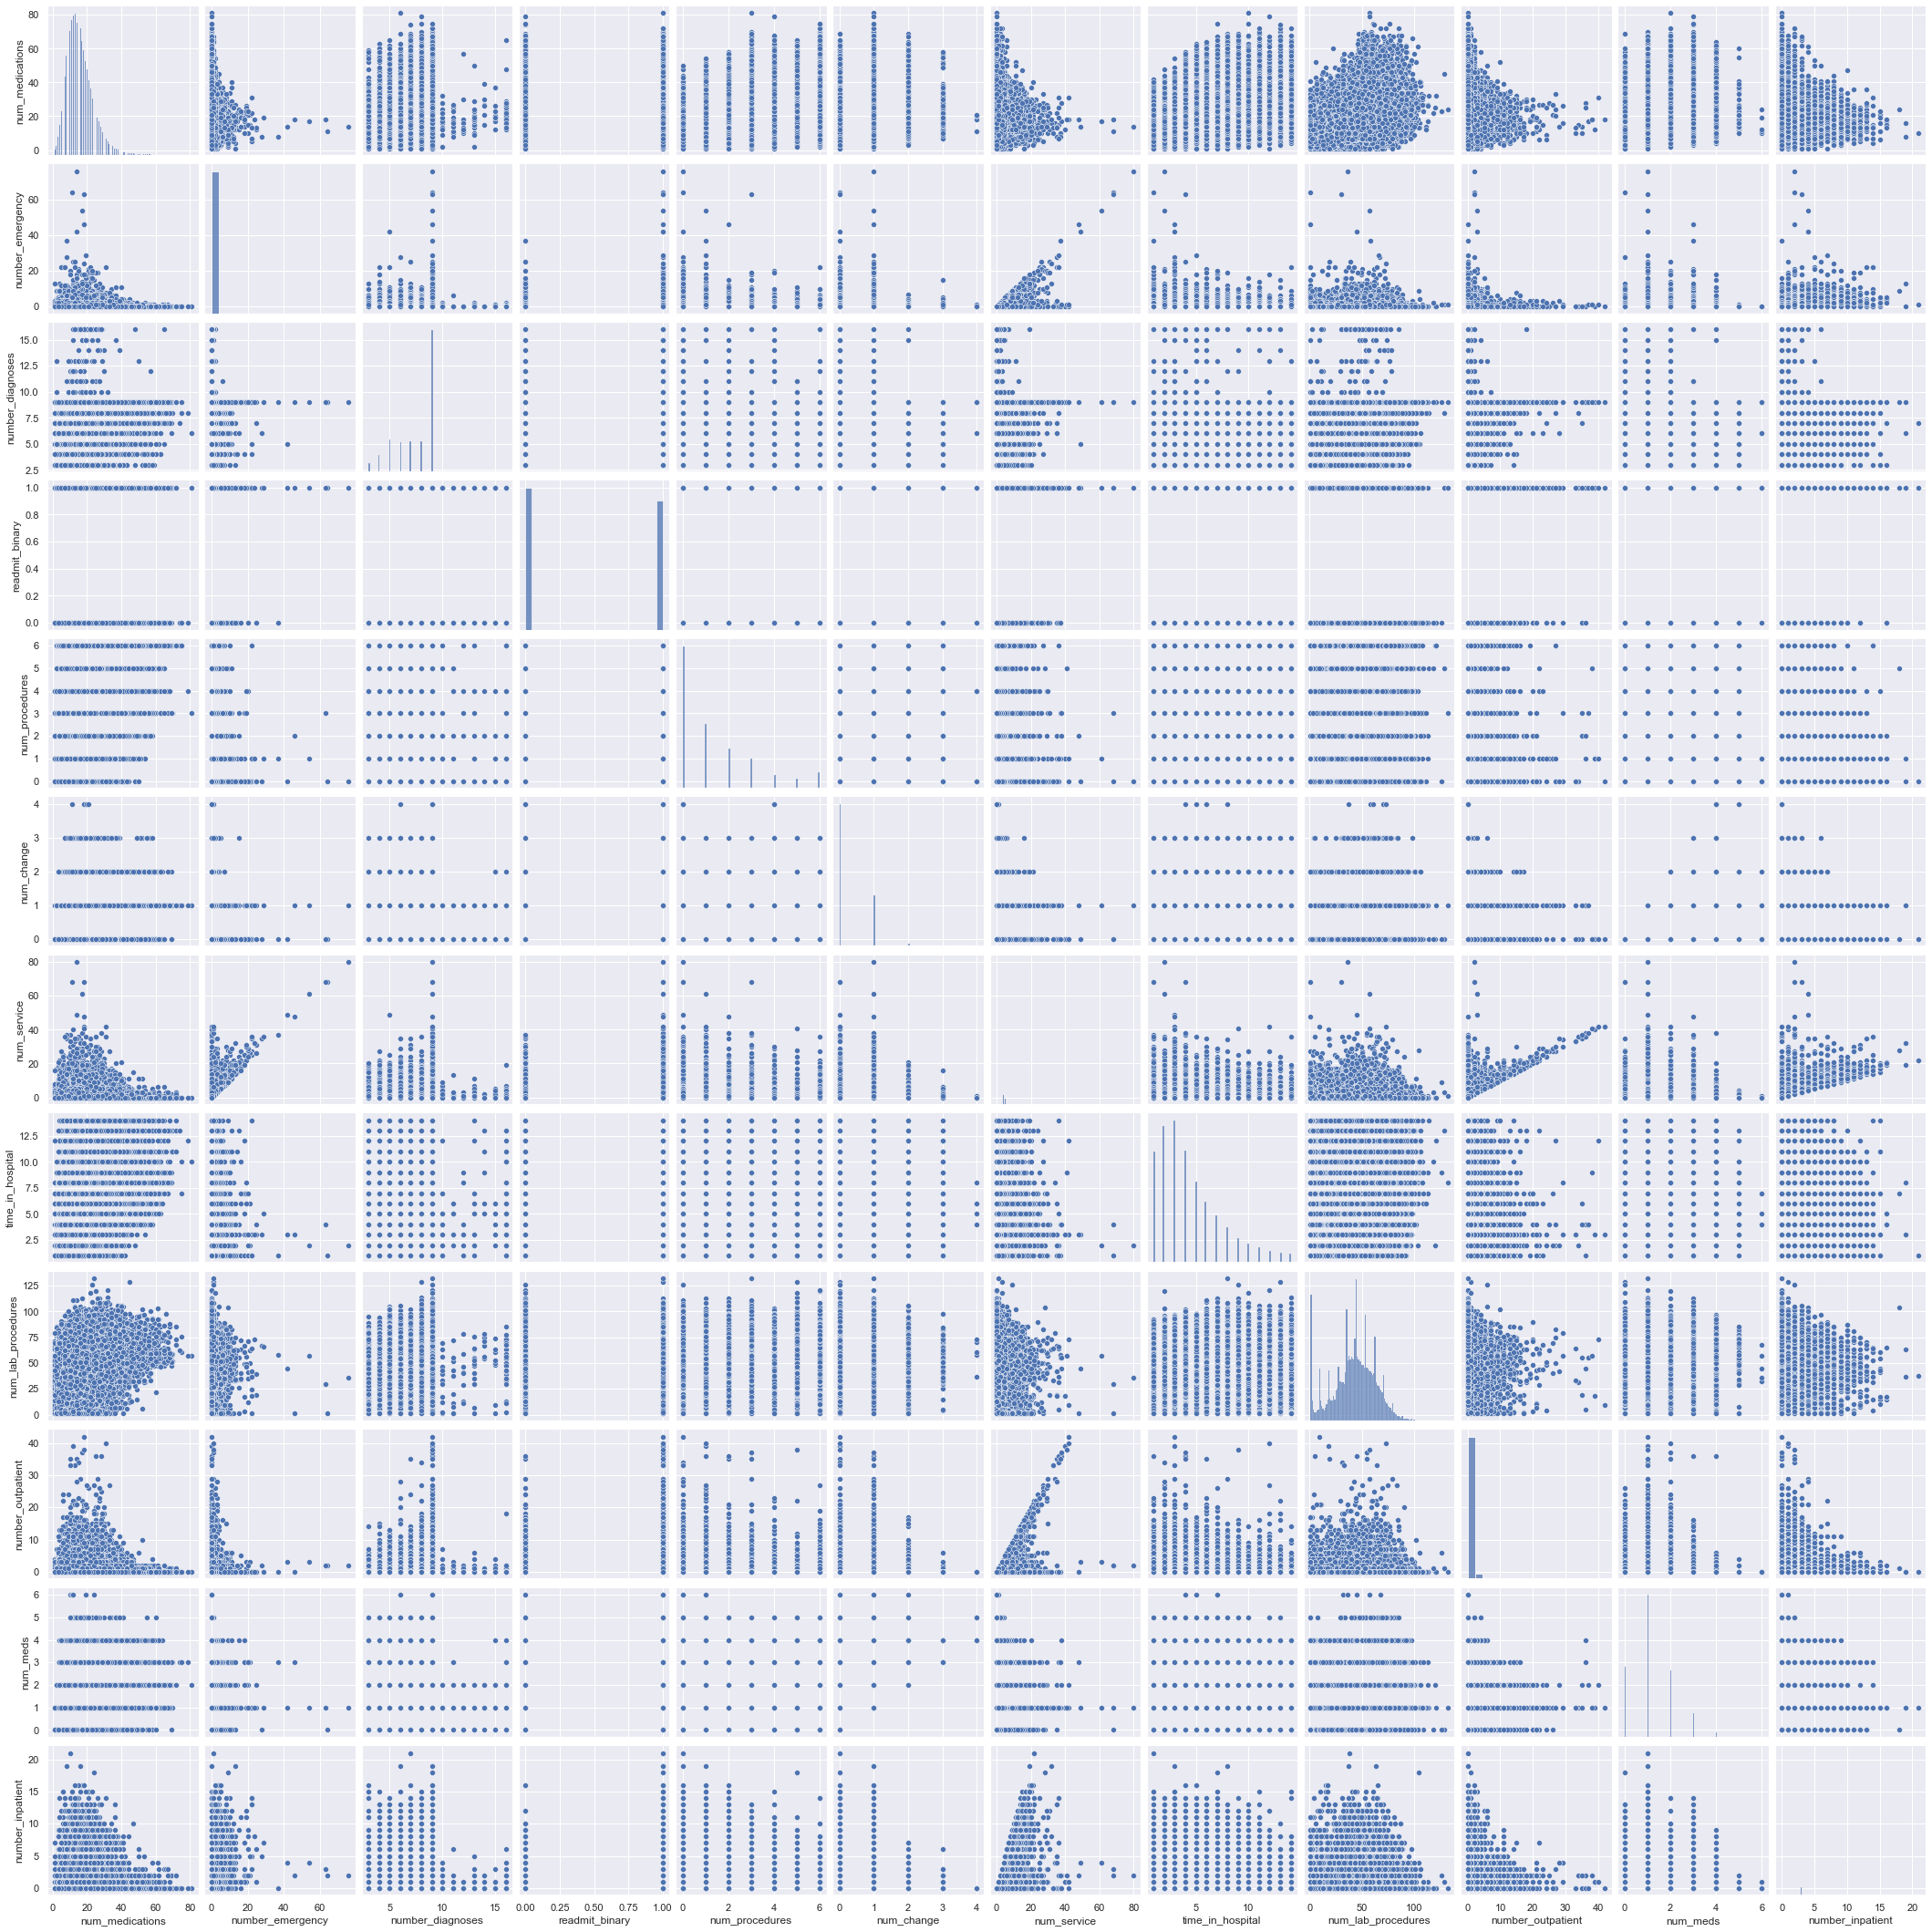

In [65]:
# Plot the pair scatter plot to check the distribution 
sns.set()
cols = num_features
sns.pairplot(df_clean[cols], height = 2.5)
plt.show();

In [80]:
from scipy import stats
i=['number_emergency',
 'num_lab_procedures',
 'time_in_hospital',
 'number_diagnoses',
 'num_meds',
 'num_service',
 'num_procedures',
 'num_change',
 'num_medications',
 'number_outpatient',
 'number_inpatient']
print('**SKEW**')
print(df_clean[i].skew())
print("------------------------------------")
print('**KURT**')
print(df_clean[i].kurt())

**SKEW**
number_emergency      21.069631
num_lab_procedures    -0.218263
time_in_hospital       1.165989
number_diagnoses      -0.657276
num_meds               0.666642
num_service            6.623027
num_procedures         1.212419
num_change             1.607394
num_medications        1.443192
number_outpatient      9.614917
number_inpatient       5.423964
dtype: float64
------------------------------------
**KURT**
number_emergency      1185.125073
num_lab_procedures      -0.302810
time_in_hospital         0.970077
number_diagnoses        -0.638480
num_meds                 0.190318
num_service             96.275706
num_procedures           0.521346
num_change               2.103247
num_medications          3.894295
number_outpatient      181.321453
number_inpatient        44.404141
dtype: float64


Using the threshold=+-1 as skewness and kurtosis with a threhold=3 for normal distribution, I identified the features that need transformations. 

The variables that need to be transformed are: 1. number_emergency 2. time_in_hospital 3. num_service 4. num_procedures 5. num_change 6. num_medications 7. num_outpatient 8. num_inpatient

In [81]:
# log transforamtion for the skewed numerical variables 
key_log = ['number_emergency', 'time_in_hospital', 'num_service',
           'num_procedures', 'num_change', 'num_medications', 
           'number_outpatient', 'number_inpatient']

# make a new dataframe for transformed data
df_transformed = df_clean.copy()

for col in key_log:
    # Check if the absolute skewness of the column is greater than or equal to 1
    if abs(df_transformed[col].skew()) >= 1:
        # Create a new column name by appending "_log" to the original column name
        new_col_name = col + "_log"
        # Apply log transformation using np.log1p to the values in the column
        transformed_values = np.log1p(df_transformed[col])
        # Assign the transformed values to the new column in the dataframe
        df_transformed[new_col_name] = transformed_values
        # Print the column name and its skewness after the transformation
        print([new_col_name], df_transformed[new_col_name].skew())

['number_emergency_log'] 4.1998733304883995
['time_in_hospital_log'] 0.12488420267147667
['num_service_log'] 1.869059781848163
['num_procedures_log'] 0.43596779989273254
['num_change_log'] 1.2999115432824588
['num_medications_log'] -0.4227694429677328
['number_outpatient_log'] 3.113032860677628
['number_inpatient_log'] 3.0472947110987327


In [82]:
df_transformed

encounter_id  patient_nbr             race  gender      age  \
1             149190     55629189        Caucasian  Female  [10-20)   
2              64410     86047875  AfricanAmerican  Female  [20-30)   
3             500364     82442376        Caucasian    Male  [30-40)   
4              16680     42519267        Caucasian    Male  [40-50)   
5              35754     82637451        Caucasian    Male  [50-60)   
...              ...          ...              ...     ...      ...   
101754     443842016    183087545        Caucasian  Female  [70-80)   
101755     443842022    188574944            Other  Female  [40-50)   
101756     443842070    140199494            Other  Female  [60-70)   
101758     443842340    120975314        Caucasian  Female  [80-90)   
101765     443867222    175429310        Caucasian    Male  [70-80)   

       admission_type_id discharge_disposition_id admission_source_id  \
1              emergency                     home       emergencyRoom   
2              emergency                     home       emergencyRoom   
3              emergency                     home       emergencyRoom   
4              emergency                     home       emergencyRoom   
5              emergency                     home            referral   
...                  ...                      ...                 ...   
101754         emergency                     home       emergencyRoom   
101755         emergency                     home       emergencyRoom   
101756         emergency                     home       emergencyRoom   
101758         emergency                     home       emergencyRoom   
101765         emergency                     home       emergencyRoom   

        time_in_hospital  num_lab_procedures  ...  num_meds  num_service  \
1                      3                  59  ...         1            0   
2                      2                  11  ...         1            3   
3                      2                  44  ...         1            0   
4                      1                  51  ...         2            0   
5                      3                  31  ...         1            0   
...                  ...                 ...  ...       ...          ...   
101754                 9                  50  ...         2            0   
101755                14                  73  ...         2            1   
101756                 2                  46  ...         1            3   
101758                 5                  76  ...         1            1   
101765                 6                  13  ...         0            0   

        number_emergency_log  time_in_hospital_log  num_service_log  \
1                   0.000000              1.386294         0.000000   
2                   0.000000              1.098612         1.386294   
3                   0.000000              1.098612         0.000000   
4                   0.000000              0.693147         0.000000   
5                   0.000000              1.386294         0.000000   
...                      ...                   ...              ...   
101754              0.000000              2.302585         0.000000   
101755              0.693147              2.708050         0.693147   
101756              0.693147              1.098612         1.386294   
101758              0.693147              1.791759         0.693147   
101765              0.000000              1.945910         0.000000   

       num_procedures_log num_change_log num_medications_log  \
1                0.000000       0.693147            2.944439   
2                1.791759       0.000000            2.639057   
3                0.693147       0.693147            2.833213   
4                0.000000       0.000000            2.197225   
5                1.945910       0.000000            2.833213   
...                   ...            ...                 ...   
101754           1.098612       0.693147            3.526361   


# Correlation

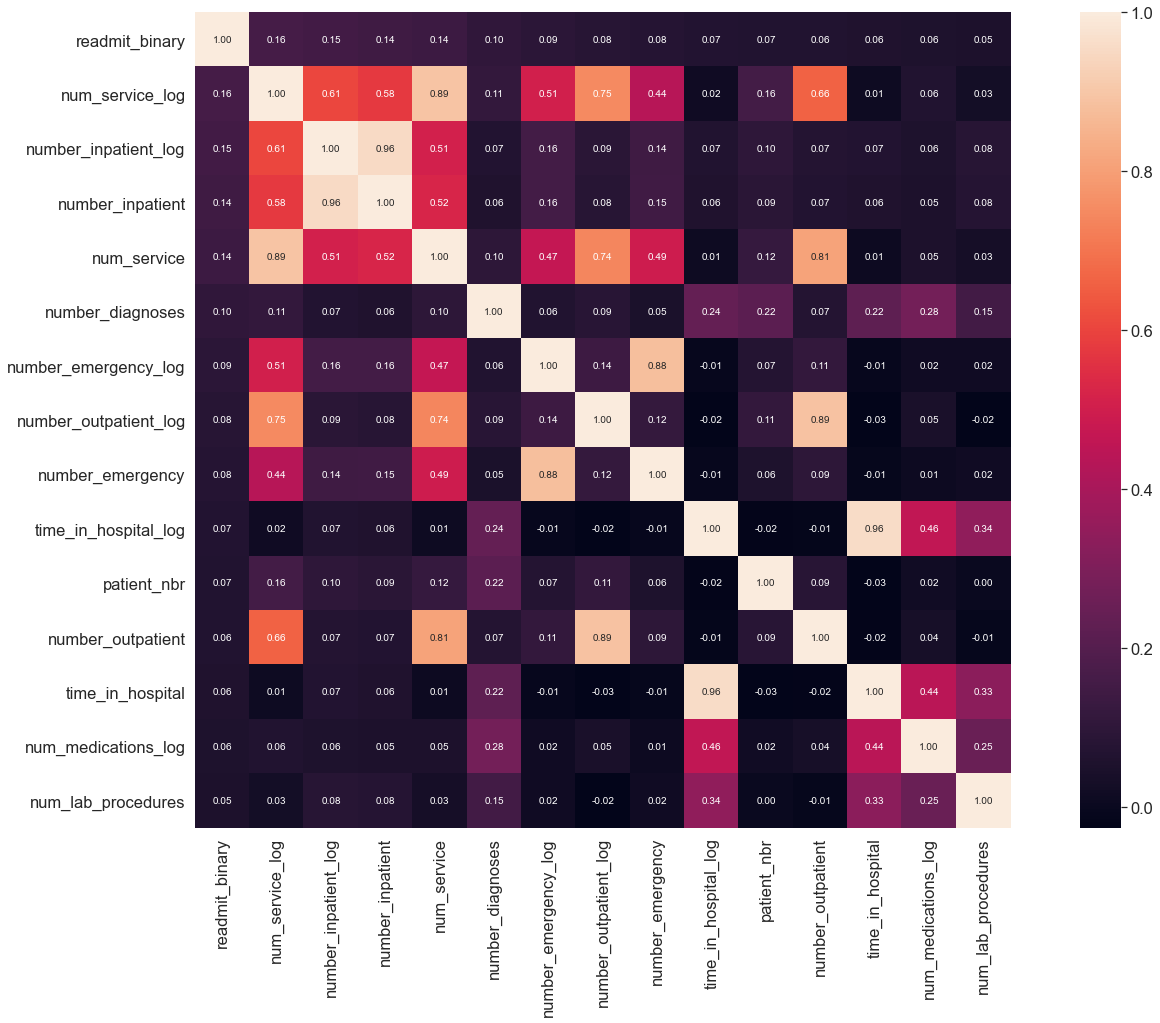

In [83]:
# find the top 15 correlated variables 

train_col = df_transformed.corr()
k = 15
cols = train_col.nlargest(k,'readmit_binary')['readmit_binary'].index
cm = np.corrcoef(df_transformed[cols].values.T)

sns.set(font_scale=1.5)
hm = plt.subplots(figsize=(25, 15))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)

plt.show();

# Train-Test-Split

In [84]:
X = df_transformed.drop(['encounter_id', 'patient_nbr', 'readmit_binary', 'readmitted'], axis=1)
y = df_transformed['readmit_binary']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Making differnt x and y train/test for log transformation and normal

In [86]:
X_train.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'num_change',
       'num_meds', 'num_service', 'number_emergency_log',
       'time_in_hospital_log', 'num_service_log', 'num_procedures_log',
       'num_change_log', 'num_medications_log

In [87]:
def log_normal(data, columns_to_drop):
    transformed_data = data.drop(columns=columns_to_drop)
    return transformed_data

In [88]:
log_col = ['number_emergency_log', 'time_in_hospital_log', 'num_service_log', 
                                     'num_procedures_log', 'num_change_log', 'num_medications_log', 
                                     'number_outpatient_log', 'number_inpatient_log']
X_train_norm = log_normal(X_train, log_col)

In [89]:
X_train_norm.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'num_change',
       'num_meds', 'num_service'],
      dtype='object')

In [90]:
X_train_log = log_normal(X_train, key_log)

In [91]:
X_train_log.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'num_lab_procedures',
       'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'num_meds',
       'number_emergency_log', 'time_in_hospital_log', 'num_service_log',
       'num_procedures_log', 'num_change_log', 'num_medications_log',
       'number_outpatient_log', 'number_inpatient_log'],
      dtype='object')

In [92]:
X_train_log.shape, X_train_norm.shape, X_train.shape

((46989, 47), (46989, 47), (46989, 55))

In [93]:
X_test_norm = log_normal(X_test, log_col)

X_test_log = log_normal(X_test, key_log)

In [94]:
# sanity check
X_test_log.shape, X_test_norm.shape, X_test.shape

((20139, 47), (20139, 47), (20139, 55))

## Data Processing

I will transform data to handle the different features so that it is ready for modeling.

In [95]:
X.dtypes

race                         object
gender                       object
age                          object
admission_type_id            object
discharge_disposition_id     object
admission_source_id          object
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                       object
diag_2                       object
diag_3                       object
number_diagnoses              int64
max_glu_serum                object
A1Cresult                    object
metformin                    object
repaglinide                  object
nateglinide                  object
chlorpropamide               object
glimepiride                  object
acetohexamide                object
glipizide                    object
glyburide                    object
tolbutamide                 

In [96]:
# numerical features
numerical_features = pd.Index(X.columns[X.dtypes != 'object'].values)
print(numerical_features)

numerical_features_norm = numerical_features.drop(log_col)
print(numerical_features_norm)

numerical_features_log = numerical_features.drop(key_log)
print(numerical_features_log)

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'num_change', 'num_meds',
       'num_service', 'number_emergency_log', 'time_in_hospital_log',
       'num_service_log', 'num_procedures_log', 'num_change_log',
       'num_medications_log', 'number_outpatient_log', 'number_inpatient_log'],
      dtype='object')
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'num_change', 'num_meds',
       'num_service'],
      dtype='object')
Index(['num_lab_procedures', 'number_diagnoses', 'num_meds',
       'number_emergency_log', 'time_in_hospital_log', 'num_service_log',
       'num_procedures_log', 'num_change_log', 'num_medications_log',
       'number_outpatient_log', 'number_inpatient_log'],
      dtype='object')


In [181]:
# object features
categorical_features = pd.Index(X_train.columns[X.dtypes == 'object'].values)
print(categorical_features)

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'diag_1', 'diag_2',
       'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed'],
      dtype='object')


In [98]:
# Looping over each numeric feature and printing its unique values
for feature in numerical_features:
    print(feature)
    print(X[feature].unique())

time_in_hospital
[ 3  2  1  4  5 13 12  9  7 10 11  6  8 14]
num_lab_procedures
[ 59  11  44  51  31  70  73  68  33  47  62  60  55  49  75  45  29  35
  42  19  64  25  53  52  87  27  37  41  28  36  48  10   2  65  67  40
  58  57  32  83  34  39  69  38  22  96  46  72  78  56  61  88  66  43
  50   1  18  82  54   9  63  24  71  77  81  76  90  93   3 103  13  80
  85  16  15  12  30  23  17  21  79  26  95  97  84  14  74 105  86  98
  20   5   6   8   7  89  91  94  92   4 101 102  99 100 114 111 107 108
 106 104 109 120 113 132 121 118]
num_procedures
[0 5 1 6 2 3 4]
num_medications
[18 13 16  8 21 12 28 17 11 15 31  2 23 19  7 20 14 10 22  9 25 32  6 26
 24  4 33  5 27 39  3 30 29 61  1 40 46 41 36 34 35 50 43 42 37 51 38 45
 54 52 49 47 44 57 48 53 62 56 59 63 55 58 70 67 64 60 69 65 66 68 81 79
 75 72 74]
number_outpatient
[ 0  2  1  5  7  3  8  4 12  9 11  6 20 15 10 13 14 16 21 35 29 18 19 27
 22 24 42 36 26 33 17 25 23]
number_emergency
[ 0  1  4  2  9  7  3  6  8 13  5 

In [161]:
# Looping over each object feature and printing its unique values
for feature in categorical_features:
    print(feature)
    print(X[feature].unique())

race
['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male']
age
['[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)'
 '[80-90)' '[90-100)' '[0-10)']
admission_type_id
['emergency' 'elective' 'not_available' 'newborn']
discharge_disposition_id
['home' 'transfered' 'left_AMA' 'not_available' 'outpatient']
admission_source_id
['emergencyRoom' 'referral' 'transfer' 'unavailable']
diag_1
['other' 'pregnancy' 'infections' 'neoplasms' 'circulatory' 'respiratory'
 'injury' 'skin' 'unknown' 'ill-defined' 'genitourinary' 'mental'
 'musculoskeletal' 'digestive' 'nervous' 'blood' 'sense' 'congenital']
diag_2
['other' 'neoplasms' 'circulatory' 'respiratory' 'blood' 'injury'
 'musculoskeletal' 'genitourinary' 'infections' 'digestive' 'skin'
 'unknown' 'nervous' 'ill-defined' 'mental' 'pregnancy' 'congenital'
 'sense']
diag_3
['other' 'unknown' 'circulatory' 'infections' 'respiratory' 'injury'
 'neoplasms' 'genitourinary' 'ill-defined' 'digestive' 'skin'

In [162]:
# ordinal and nominal categorical features
ordinal_col = pd.Index(['age'])

nominal_col = np.array(categorical_features)
nominal_col = pd.Index(nominal_col[nominal_col != 'age']).values

### Data Preprocessing Function: `SS_scaler`
The `SS_scaler` function is designed to scale the input data using `StandardScaler`. It takes in both the training data, `X_train`, and testing data, `X_test`, and applies the `fit_transform` method on the training data to learn the scaling parameters and transform the data accordingly. For the testing data, it only applies the `transform` method to maintain consistency with the scaling parameters learned from the training data. The function returns the scaled versions of both the training and testing data.

Using functions like `preprocess_data` and `SS_scaler` provides several advantages over hard coding the preprocessing steps for both training and testing data. It promotes code modularity and reusability, allowing you to easily apply the same preprocessing steps to new datasets. Additionally, it enhances code readability and maintainability, as the preprocessing steps are encapsulated within functions with descriptive names, making it easier to understand and modify the code as needed.

In [103]:
def SS_scaler(X_train, X_test, numerical_cols):
    # Create a copy of the input dataframes
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Scale the numerical columns using StandardScaler
    scaler = StandardScaler()
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
    
    return X_train_scaled, X_test_scaled

In [287]:
# Define the categories and their corresponding labels for the 'age' column
age_categories = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', 
                  '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
age_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a copy of the training and testing dataframes
X_train_processed = X_train_norm.copy()
X_test_processed = X_test_norm.copy()

# Perform ordinal encoding on the 'age' column of the training data
ordinal_encoder = OrdinalEncoder(categories=[age_categories])
X_train_p_norm['age'] = ordinal_encoder.fit_transform(X_train_processed['age'].values.reshape(-1, 1))

# Perform ordinal encoding on the 'age' column of the testing data
X_test_p_norm['age'] = ordinal_encoder.transform(X_test_processed['age'].values.reshape(-1, 1))

In [290]:
# Define the categories and their corresponding labels for the 'age' column
age_categories = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', 
                  '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
age_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a copy of the training and testing dataframes
X_train_processed_log = X_train_log.copy()
X_test_processed_log = X_test_log.copy()

# Perform ordinal encoding on the 'age' column of the training data
ordinal_encoder = OrdinalEncoder(categories=[age_categories])
X_train_p_log['age'] = ordinal_encoder.fit_transform(X_train_processed_log['age'].values.reshape(-1, 1))

# Perform ordinal encoding on the 'age' column of the testing data
X_test_p_log['age'] = ordinal_encoder.transform(X_test_processed_log['age'].values.reshape(-1, 1))

In [289]:
# sanity check
X_test_p_norm['age'], X_test['age']

(30328    6.0
 12531    7.0
 24628    8.0
 24245    7.0
 38372    8.0
         ... 
 53506    7.0
 20222    9.0
 5857     7.0
 25967    4.0
 70923    7.0
 Name: age, Length: 20139, dtype: float64,
 30328     [60-70)
 12531     [70-80)
 24628     [80-90)
 24245     [70-80)
 38372     [80-90)
            ...   
 53506     [70-80)
 20222    [90-100)
 5857      [70-80)
 25967     [40-50)
 70923     [70-80)
 Name: age, Length: 20139, dtype: object)

In [291]:
# only the data for log needs scaling
X_train_sc_log , X_test_sc_log = SS_scaler(X_train_p_log, X_test_p_log, numerical_features_log)

In [292]:
# sanity check
X_train_sc_log

race  gender  age admission_type_id  \
82191        Caucasian  Female  7.0         emergency   
39533        Caucasian  Female  6.0         emergency   
31892        Caucasian  Female  5.0          elective   
25701        Caucasian    Male  8.0         emergency   
73635  AfricanAmerican    Male  2.0         emergency   
...                ...     ...  ...               ...   
52295        Caucasian  Female  7.0          elective   
8161   AfricanAmerican    Male  7.0         emergency   
80859        Caucasian  Female  8.0         emergency   
997          Caucasian    Male  6.0         emergency   
22456        Caucasian  Female  5.0         emergency   

      discharge_disposition_id admission_source_id  num_lab_procedures  \
82191               transfered       emergencyRoom            1.962425   
39533               transfered       emergencyRoom           -1.000343   
31892                     home            transfer           -0.146664   
25701               transfered            transfer            0.305284   
73635                     home       emergencyRoom            0.707015   
...                        ...                 ...                 ...   
52295                     home            referral           -0.096448   
8161                      home       emergencyRoom            0.606582   
80859               transfered       emergencyRoom            0.455933   
997                       home       emergencyRoom            1.008313   
22456                     home       emergencyRoom            0.255067   

              diag_1         diag_2       diag_3  ...  diabetesMed  num_meds  \
82191         injury  genitourinary  circulatory  ...          Yes -0.200505   
39533    circulatory    circulatory      nervous  ...          Yes  0.859048   
31892    circulatory    respiratory  circulatory  ...           No -1.260059   
25701  genitourinary    ill-defined        other  ...           No -1.260059   
73635          other         mental        other  ...           No -1.260059   
...              ...            ...          ...  ...          ...       ...   
52295         injury      digestive    digestive  ...          Yes -0.200505   
8161     circulatory      neoplasms        other  ...           No -1.260059   
80859    respiratory    ill-defined  circulatory  ...          Yes -0.200505   
997      circulatory    circulatory  circulatory  ...          Yes  0.859048   
22456      digestive           skin        blood  ...          Yes  0.859048   

      number_emergency_log time_in_hospital_log num_service_log  \
82191            -0.266537             0.502849       -0.542024   
39533            -0.266537            -0.257452       -0.542024   
31892            -0.266537             0.502849       -0.542024   
25701            -0.266537             0.502849        0.817010   
73635            -0.266537             1.042292       -0.542024   
...                    ...                  ...             ...   
52295            -0.266537             1.639435       -0.542024   
8161             -0.266537            -0.796895       -0.542024   
80859            -0.266537            -0.257452        1.611994   
997              -0.266537             1.802593       -0.542024   
22456             2.721950             0.502849        0.817010   

      num_procedures_log num_change_log num_medications_log  \
82191           0.663422      -0.564718            0.013223   
39533          -0.988643      -0.564718           -0.274823   
31892          -0.988643      -0.564718            0.380216   
25701          -0.988643      -0.564718           -1.015012   
73635          -0.988643      -0.564718           -1.831168   
...                  ...            ...                 ...   
52295           0.663422       1.641621            1.884275   
8161           -0.988643      -0.564718           -1.015012   
80859          -0.988643      -0.564718           -0.435940   
997            -0.988643      -0.564718         

### get_dummies
OneHotEncoding out the catagorical columns execpt for 'age' using get_dummies. Making sure that the same number of columns will be returned for the testing data even though it might be missing the category by filling in with columns of 0.

#### Encoding log transformed and scaled data

In [293]:
# Get dummy variables for the training data
X_train_encoded = pd.get_dummies(X_train_sc_log, columns=nominal_col, drop_first=True)

# Get dummy variables for the testing data
X_test_encoded = pd.get_dummies(X_test_sc_log, columns=nominal_col, drop_first=True)

# Get the columns in the training data after one-hot encoding
train_encoded_columns = X_train_encoded.columns

# Add any missing columns in the testing data with zeros as placeholders
missing_columns = set(train_encoded_columns) - set(X_test_encoded.columns)
for column in missing_columns:
    X_test_encoded[column] = 0

# Reorder the columns in the testing data to match the order in the training data
X_test_encoded = X_test_encoded[train_encoded_columns]

In [294]:
# sanity check
display(X_train_encoded.head())
print(X_train_encoded.shape, X_test_encoded.shape)

age  num_lab_procedures  number_diagnoses  num_meds  \
82191  7.0            1.962425          0.886160 -0.200505   
39533  6.0           -1.000343          0.886160  0.859048   
31892  5.0           -0.146664         -0.697844 -1.260059   
25701  8.0            0.305284         -1.225846 -1.260059   
73635  2.0            0.707015         -0.169843 -1.260059   

       number_emergency_log  time_in_hospital_log  num_service_log  \
82191             -0.266537              0.502849        -0.542024   
39533             -0.266537             -0.257452        -0.542024   
31892             -0.266537              0.502849        -0.542024   
25701             -0.266537              0.502849         0.817010   
73635             -0.266537              1.042292        -0.542024   

       num_procedures_log  num_change_log  num_medications_log  ...  \
82191            0.663422       -0.564718             0.013223  ...   
39533           -0.988643       -0.564718            -0.274823  ...   
31892           -0.988643       -0.564718             0.380216  ...   
25701           -0.988643       -0.564718            -1.015012  ...   
73635           -0.988643       -0.564718            -1.831168  ...   

       insulin_No  insulin_Steady  insulin_Up  glyburide-metformin_No  \
82191           0               1           0                       1   
39533           0               1           0                       1   
31892           1               0           0                       1   
25701           1               0           0                       1   
73635           1               0           0                       1   

       glyburide-metformin_Steady  glyburide-metformin_Up  \
82191                           0                       0   
39533                           0                       0   
31892                           0                       0   
25701                           0                       0   
73635                           0                       0   

       glipizide-metformin_Steady  metformin-pioglitazone_Steady  change_No  \
82191                           0                              0          1   
39533                           0                              0          0   
31892                           0                              0          1   
25701                           0                              0          1   
73635                           0                              0          1   

       diabetesMed_Yes  
82191                1  
39533                1  
31892                0  
25701                0  
73635                0  

[5 rows x 130 columns]

(46989, 130) (20139, 130)


#### Encoding the not log transformed data

In [295]:
# Get dummy variables for the training data
X_train_enc_norm = pd.get_dummies(X_train_p_norm, columns=nominal_col, drop_first=True)

# Get dummy variables for the testing data
X_test_enc_norm = pd.get_dummies(X_test_p_norm, columns=nominal_col, drop_first=True)

# Get the columns in the training data after one-hot encoding
train_enc_columns = X_train_enc_norm.columns

# Add any missing columns in the testing data with zeros as placeholders
missing_columns = set(train_enc_columns) - set(X_test_enc_norm.columns)
for column in missing_columns:
    X_test_enc_norm[column] = 0

# Reorder the columns in the testing data to match the order in the training data
X_test_enc_norm = X_test_enc_norm[train_enc_columns]

In [296]:
# sanity check
display(X_test_enc_norm.head())
print(X_train_enc_norm.shape, X_test_enc_norm.shape)

age  time_in_hospital  num_lab_procedures  num_procedures  \
30328  6.0                 2                  54               0   
12531  7.0                 1                  67               3   
24628  8.0                10                  25               0   
24245  7.0                 3                  47               0   
38372  8.0                 7                  47               5   

       num_medications  number_outpatient  number_emergency  number_inpatient  \
30328                7                  0                 0                 0   
12531               14                  2                 0                 0   
24628               19                  0                 0                 0   
24245               23                  0                 0                 0   
38372               28                  0                 0                 0   

       number_diagnoses  num_change  ...  insulin_No  insulin_Steady  \
30328                 5           0  ...           1               0   
12531                 6           0  ...           1               0   
24628                 9           1  ...           0               0   
24245                 7           1  ...           0               0   
38372                 9           0  ...           0               1   

       insulin_Up  glyburide-metformin_No  glyburide-metformin_Steady  \
30328           0                       0                           0   
12531           0                       0                           0   
24628           1                       0                           0   
24245           1                       0                           0   
38372           0                       0                           0   

       glyburide-metformin_Up  glipizide-metformin_Steady  \
30328                       0                           0   
12531                       0                           0   
24628                       0                           0   
24245                       0                           0   
38372                       0                           0   

       metformin-pioglitazone_Steady  change_No  diabetesMed_Yes  
30328                              0          1                0  
12531                              0          1                1  
24628                              0          0                1  
24245                              0          0                1  
38372                              0          0                1  

[5 rows x 130 columns]

(46989, 130) (20139, 130)


# Modeling

In [169]:
# imports for modeling
from collections import Counter

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier 
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, \
    learning_curve, cross_validate, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, \
    precision_recall_curve, classification_report

## Functions for modeling

### fit_model
The `fit_model` function is a utility function that measures the time taken to fit a machine learning model on a given training dataset. The function takes three parameters: `model`, which represents the machine learning model to be fitted, `X_train`, which represents the training data features, and `y_train`, which represents the corresponding target labels. 

Inside the function, the current time is recorded using `time.time()` at the beginning (`start_time`) and after the model fitting is completed (`end_time`). The difference between `end_time` and `start_time` gives the elapsed time taken to fit the model. This elapsed time is then returned by the function.

This function can be useful for evaluating the efficiency of different machine learning models or comparing the training times of different algorithms. By measuring the time taken for model training, it provides insights into the computational complexity and efficiency of the chosen algorithm.

In [171]:
import time

def fit_model(model, X_train, y_train):
    start_time = time.time()
    
    # Fitting the model
    model.fit(X_train, y_train)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return elapsed_time

### model_evaluation function

The `model_evaluation` function performs evaluation and visualization of a classification model. It takes as input the model to be evaluated (`model`), the input features (`X`), the target variable (`y`), and an optional parameter for the number of cross-validation folds (`cv`).

The function starts by setting up the plots for visualizing the receiver operating characteristic (ROC) curves and the confusion matrix. It then calculates the ROC curve and area under the curve (AUC) for each fold of cross-validation. The mean ROC curve and mean AUC are also calculated and plotted.

Next, the function computes various evaluation metrics such as accuracy, precision, recall, F1 score, and AUC score for the model's predictions on the entire dataset. It also calculates the mean cross-validation scores for these metrics.

The function then computes the confusion matrix for the model's predictions using cross-validation. The confusion matrix is plotted as a heatmap.

Finally, the function prints the evaluation metrics, mean cross-validation scores, and the confusion matrix.

This function provides a comprehensive evaluation of the classification model, including visualizations of the ROC curve, evaluation metrics, cross-validation scores, and the confusion matrix. It is useful for understanding the model's performance and identifying any potential issues or areas of improvement.

In [175]:
def model_evaluation(model, X, y, cv=5):
    #Setting up plots
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # ROC Curves
    ax1.set_title(f'{model} Receiver Operating Characteristic', fontsize=14)
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black')

    y_scores = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]

    for i in range(cv):
        fpr, tpr, _ = roc_curve(y, y_scores)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(roc_auc)

    ax1.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='blue', lw=2, 
             label='Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))

    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.legend(loc="lower right")
    
    
    # Evaluation Metrics
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc_score = roc_auc_score(y, y_scores)

    # Mean Cross Validation Scores
    cv_results = cross_validate(model, X, y, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
    mean_cv_accuracy = np.mean(cv_results['test_accuracy'])
    mean_cv_precision = np.mean(cv_results['test_precision'])
    mean_cv_recall = np.mean(cv_results['test_recall'])
    mean_cv_f1 = np.mean(cv_results['test_f1'])
    mean_cv_auc = np.mean(cv_results['test_roc_auc'])

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)

    # Print Evaluation Metrics
    print("The accuracy score is: %.2f%%" % (accuracy * 100))
    print("The precision score is: %.2f%%" % (precision * 100))
    print("The recall score is: %.2f%%" % (recall * 100))
    print("The F1 score is: %.2f%%" % (f1 * 100))
    print("The AUC score is: %.2f%%" % (auc_score * 100))

    print("\nThe mean cross validation accuracy score is: %.4f" % mean_cv_accuracy)
    print("The mean cross validation precision score is: %.4f" % mean_cv_precision)
    print("The mean cross validation recall score is: %.4f" % mean_cv_recall)
    print("The mean cross validation F1 score is: %.4f" % mean_cv_f1)
    print("The mean cross validation AUC score is: %.4f" % mean_cv_auc)

    print("\nConfusion Matrix:")
    print(cm)
    

    # Confusion Matrix
    cm_sum = np.zeros((2, 2))
    y_pred = cross_val_predict(model, X, y, cv=cv)

    for i in range(cv):
        cm = confusion_matrix(y, y_pred)
        cm_sum += cm

    ax2.set_title('Cross-Validation Confusion Matrix', fontsize=14)
    sns.heatmap(cm_sum, annot=True, fmt='.0f', cmap='viridis', ax=ax2)
    ax2.set_xlabel('Predicted', fontsize=12)
    ax2.set_ylabel('True', fontsize=12)

    plt.tight_layout()
    plt.show()

## Dummy model

A dummy model is important in the modeling process as it establishes a baseline performance level, allows for sanity checks, aids in model selection, and facilitates effective communication of model performance. It serves as a starting point for model development and helps in assessing the value and effectiveness of more complex models.

This dummy model will always guess the most frequent which is 'No Readmission'.

In [170]:
y_train.value_counts(normalize=True)

0    0.586733
1    0.413267
Name: readmit_binary, dtype: float64

There is very little class imbalance so I will not be using any data augmentation to balance out the target variable classes.

In [217]:
# dummy model that always chooses the readmission (positive)
dummy_model = DummyClassifier(strategy="most_frequent")

# fitting the model on training data
dummy_model.fit(X_train_enc_norm, y_train)

# fit_time
fit_time = fit_model(dummy_model, X_train_enc_norm, y_train)
print(f"Model fitted in {fit_time:.4f} seconds")

# predicting
y_pred_dummy = dummy_model.predict(X_train_enc_norm)

Model fitted in 0.0018 seconds


### Evaluation Metrics for Classification Modeling:

- Accuracy: Measures the proportion of correctly predicted instances out of the total number of instances. Provides an overall assessment of model correctness.

- Precision: Measures the proportion of correctly predicted positive instances out of all instances predicted as positive. Focuses on the accuracy of positive predictions, indicating how well the model avoids false positives.

- Recall: Measures the proportion of correctly predicted positive instances out of all actual positive instances. Emphasizes the model's ability to find all positive instances and avoid false negatives.

- F1 Score: The harmonic mean of precision and recall. Provides a balanced measure of model accuracy, especially useful for imbalanced datasets.

- ROC AUC Score: Evaluates the model's ability to distinguish between classes. Calculates the area under the ROC curve, representing the trade-off between true positive rate and false positive rate. Higher score indicates better performance.

Interpretation: Higher values of accuracy, precision, recall, and F1 score indicate better model performance. A higher ROC AUC score suggests better discrimination between classes. Consider the specific goals and requirements of the classification problem when evaluating these metrics.

### F1 score as main evlauation metric
In the context of my business problem of predicting hospital readmission for diabetic patients, the F1 score is a valuable evaluation metric that helps me identify which patients to prioritize for contact and follow-up to prevent readmissions.

The F1 score takes into account both precision and recall. Precision represents the proportion of patients predicted as readmitted who are actually readmitted. For my problem, a high precision means that when the model predicts a patient will be readmitted, there is a high likelihood that the patient will indeed be readmitted. By focusing on patients with a high probability of readmission, I can allocate my resources and interventions effectively, ensuring that those who are most at risk receive the necessary support.

Recall measures the model's ability to correctly identify all actual readmissions among diabetic patients. A high recall means that the model is effective at capturing a significant portion of the readmissions. By considering recall in conjunction with precision, the F1 score provides a balanced measure of the model's performance. It ensures that while identifying as many true positives (actual readmissions) as possible, I also minimize the chances of missing any patients who may require intervention.

By optimizing for the F1 score, I can determine a threshold that balances precision and recall according to my business priorities. This threshold helps me identify a subset of patients who are predicted to be at high risk of readmission and require proactive intervention. By focusing my resources on these patients, such as providing personalized care plans, medication management, or additional support, I can effectively reduce the likelihood of their readmission, ultimately improving patient outcomes and reducing healthcare costs.

In summary, the F1 score, specific to my business problem of hospital readmission for diabetic patients, guides me in prioritizing my efforts by identifying patients who are most likely to be readmitted. By considering both precision and recall, the F1 score helps me target my resources and interventions towards those individuals who require additional support, reducing the likelihood of readmission and improving patient care.

/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alisonpark/opt/

The accuracy score is: 58.67%
The precision score is: 0.00%
The recall score is: 0.00%
The F1 score is: 0.00%
The AUC score is: 50.00%

The mean cross validation accuracy score is: 0.5867
The mean cross validation precision score is: 0.0000
The mean cross validation recall score is: 0.0000
The mean cross validation F1 score is: 0.0000
The mean cross validation AUC score is: 0.5000

Confusion Matrix:
[[27570     0]
 [19419     0]]


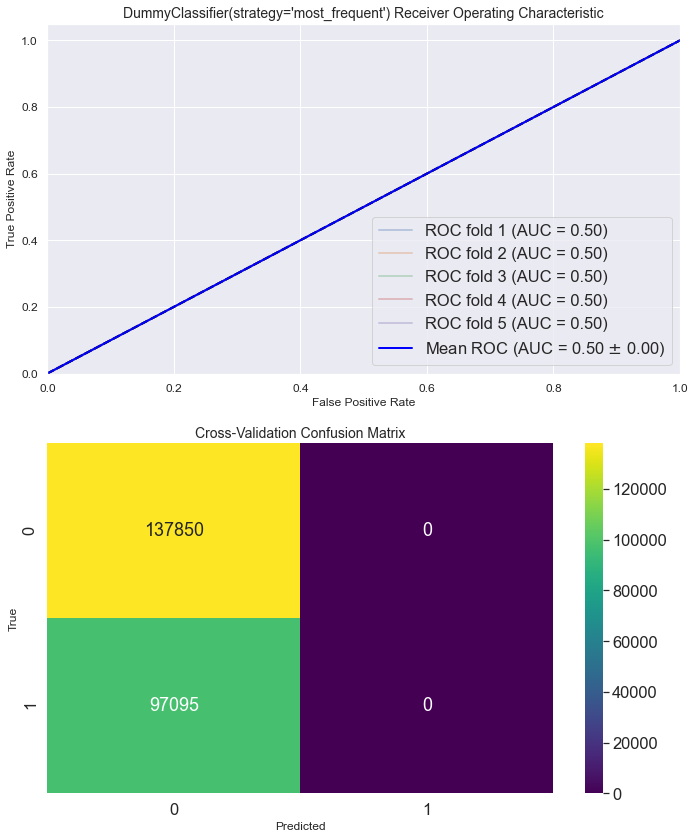

In [218]:
dummy_model_eval = model_evaluation(dummy_model, X_train_enc_norm, y_train, cv=5)

The dummy model, which always predicts "No readmission," achieves an accuracy score of 58.67%, slightly above random guessing. However, it fails to identify any positive cases, resulting in precision, recall, and F1 scores of 0.00%. The AUC score of 50.00% indicates that the model cannot distinguish between positive and negative instances. The mean cross-validation scores confirm the model's consistent poor performance across different folds. The confusion matrix shows that the model correctly predicts non-readmissions (true negatives) but fails to identify any readmissions (false negatives). Overall, the dummy model lacks the ability to effectively predict hospital readmissions for diabetic patients.

## Base Logistic Regression

**Logistic Regression** is a widely used statistical model for binary classification tasks. Despite its name, it is a classification algorithm rather than a regression algorithm. Logistic regression models the relationship between a dependent variable and one or more independent variables by estimating the probability of the dependent variable belonging to a specific class. It is based on the logistic function, also known as the sigmoid function, which maps any real-valued input to a value between 0 and 1. The logistic regression algorithm learns the optimal weights for the independent variables to maximize the likelihood of the observed data. These learned weights are used to predict the probabilities of the classes, and a threshold is applied to assign instances to a specific class. Logistic regression is popular due to its simplicity, interpretability, and effectiveness in various domains, making it a fundamental tool in the field of machine learning and predictive analytics.

In [192]:
# Initializing
lr_base = LogisticRegression(random_state=42)
lr_base = Pipeline(steps=[
    ('lr',LogisticRegression(n_jobs=-1))
])

# Training
lr_base.fit(X_train_encoded, y_train)

# fit_time
fit_time = fit_model(lr_base, X_train_encoded, y_train)
print(f"Model fitted in {fit_time:.4f} seconds")

# Predicting
y_pred_lr_base = lr_base.predict(X_train_encoded)

Model fitted in 12.8381 seconds


The accuracy score is: 62.69%
The precision score is: 59.50%
The recall score is: 30.45%
The F1 score is: 40.28%
The AUC score is: 63.87%

The mean cross validation accuracy score is: 0.6243
The mean cross validation precision score is: 0.5882
The mean cross validation recall score is: 0.3031
The mean cross validation F1 score is: 0.4000
The mean cross validation AUC score is: 0.6387

Confusion Matrix:
[[23546  4024]
 [13506  5913]]


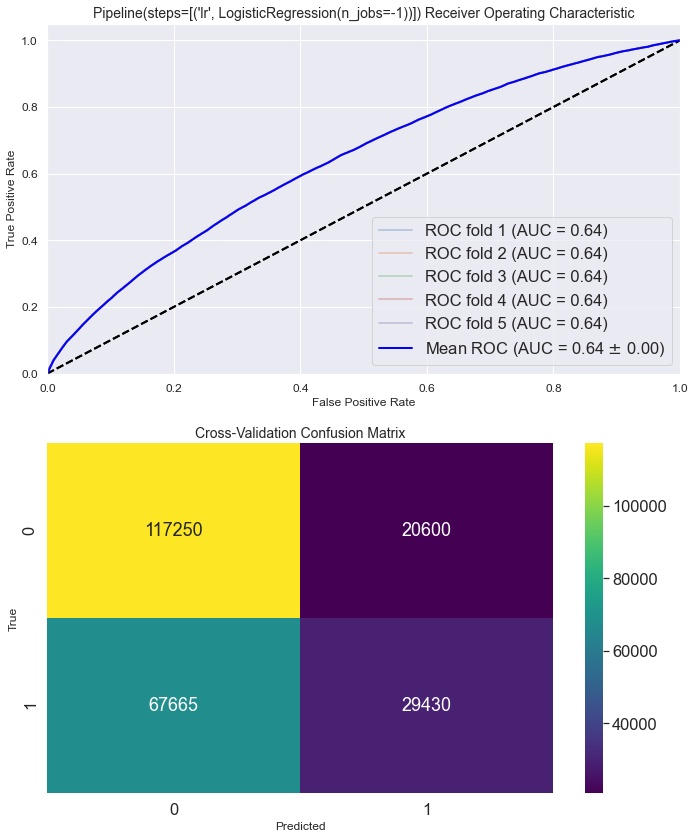

In [193]:
lr_base_eval = model_evaluation(lr_base, X_train_encoded, y_train, cv=5)

The base logistic regression model shows moderate performance in predicting hospital readmission for diabetic patients. It achieves an accuracy score of 62.69%, indicating that it correctly predicts the readmission class approximately 62.69% of the time. The precision score is 59.50%, suggesting that when it predicts readmission, it is correct around 59.50% of the time. The recall score is 30.45%, indicating that the model captures only about 30.45% of the actual readmissions.

The F1 score, which combines precision and recall, is 40.28%. This score represents the overall balanced performance of the model in terms of both precision and recall. The AUC score is 63.87%, suggesting that the model performs better than random guessing.

The mean cross-validation scores provide an estimate of the model's performance across multiple folds of the data. The mean cross-validation accuracy score is 0.6243, similar to the accuracy score obtained on the test data. The mean cross-validation precision score is 0.5882, the mean cross-validation recall score is 0.3031, and the mean cross-validation F1 score is 0.4000. These scores suggest that the model's performance is consistent across different folds of the data.

The confusion matrix shows that the model correctly predicts 23,546 instances of non-readmission (true negatives) and 5,913 instances of readmission (true positives). However, it also misclassifies 4,024 instances of non-readmission as readmission (false positives) and fails to identify 13,506 instances of readmission (false negatives). These results indicate room for improvement in the model's ability to accurately predict readmissions.

## Base Decision Tree

**Decision trees** are a type of parametric model that recursively partitions the feature space into smaller and smaller regions based on the most informative features. The partitioning process stops when a stopping criterion is met, such as when all data points in a region belong to the same class or when a maximum depth is reached. Decision trees can work well when the decision boundary is nonlinear and can handle both continuous and categorical data. They are often used as standalone models or as part of an ensemble model, such as a random forest.

In [194]:
# Initializing
dt_base = DecisionTreeClassifier(random_state=42)

# Training
dt_base.fit(X_train_enc_norm, y_train)

# fit_time
fit_time = fit_model(dt_base, X_train_enc_norm, y_train)
print(f"Model fitted in {fit_time:.4f} seconds")

# Predicting
y_pred_dt_base = dt_base.predict(X_train_enc_norm)

Model fitted in 1.2544 seconds


The accuracy score is: 100.00%
The precision score is: 100.00%
The recall score is: 100.00%
The F1 score is: 100.00%
The AUC score is: 53.70%

The mean cross validation accuracy score is: 0.5499
The mean cross validation precision score is: 0.4560
The mean cross validation recall score is: 0.4626
The mean cross validation F1 score is: 0.4593
The mean cross validation AUC score is: 0.5370

Confusion Matrix:
[[27570     0]
 [    0 19419]]


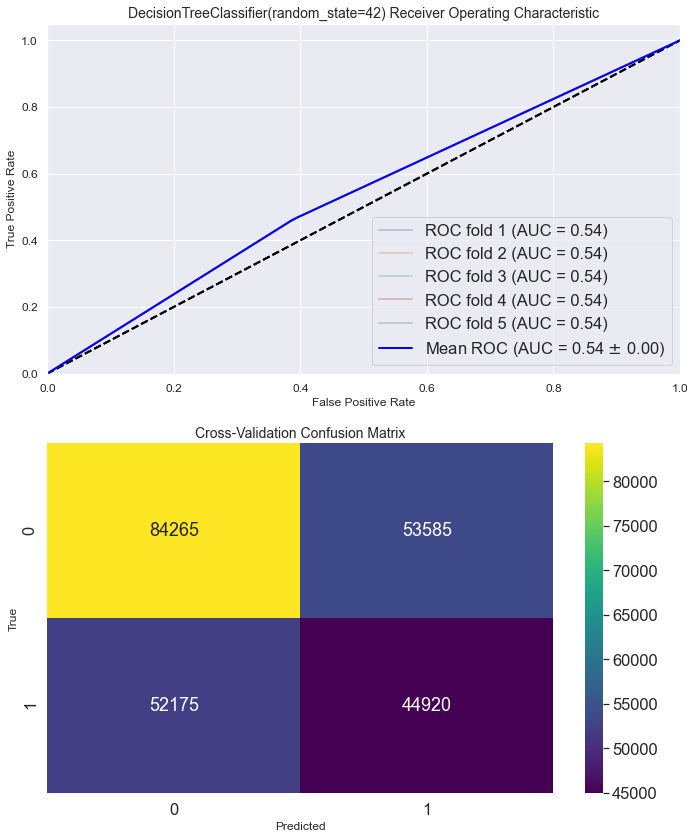

In [195]:
dt_base_eval = model_evaluation(dt_base, X_train_enc_norm, y_train, cv=5)

The base decision tree model appears to be overfitting the training data, as it achieves a perfect accuracy score of 100.00% on the test data. This means that it correctly predicts the readmission class for all instances in the test data. However, such a high accuracy score is unlikely to be achievable in real-world scenarios and suggests potential overfitting.

The precision score and recall score are both 100.00%, indicating that the model correctly identifies all instances of readmission (true positives) and non-readmission (true negatives). The F1 score is also 100.00%, which combines precision and recall into a single metric, representing perfect balance between the two.

However, it's important to note that these scores are likely a result of overfitting, as indicated by the high accuracy and perfect performance across all metrics. The AUC score is 53.70%, which suggests that the model's ability to distinguish between positive and negative instances is only slightly better than random chance.

The mean cross-validation scores provide a more reliable estimate of the model's performance. The mean cross-validation accuracy score is 0.5499, indicating that the model achieves moderate accuracy across different folds of the data. The mean cross-validation precision score is 0.4560, the mean cross-validation recall score is 0.4626, and the mean cross-validation F1 score is 0.4593. These scores suggest that the model's performance is not as perfect as initially indicated by the test scores.

The confusion matrix shows that the model correctly predicts all instances of non-readmission (true negatives) and readmission (true positives). However, without any misclassifications, it is difficult to assess the model's robustness and generalization ability. It is likely that this model is overfitting the training data and may not perform well on unseen data.

## Base Random Forest

A **Random Forest model** is an ensemble learning method that combines multiple decision trees to create a more accurate and robust model. It is used for both classification and regression tasks. The Random Forest consists of an ensemble of decision trees, each trained on a random subset of the training data and considering a random subset of features for splitting. This randomness reduces overfitting and improves generalization. The predictions from the individual trees are combined using majority voting for classification tasks. Random Forests are advantageous as they are less prone to overfitting, provide feature importance estimates, and can handle high-dimensional data and missing values. They are suitable for classification problems, high-dimensional data analysis, outlier detection, and feature importance analysis. Overall, Random Forests are versatile and powerful models widely used in various domains.

In [197]:
# Initializing
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Training
rf_base.fit(X_train_enc_norm, y_train)

# fit_time
fit_time = fit_model(rf_base, X_train_enc_norm, y_train)
print(f"Model fitted in {fit_time:.4f} seconds")

# Predicting
y_pred_rf_base = rf_base.predict(X_train_enc_norm)

Model fitted in 6.0088 seconds


The accuracy score is: 100.00%
The precision score is: 100.00%
The recall score is: 100.00%
The F1 score is: 100.00%
The AUC score is: 63.36%

The mean cross validation accuracy score is: 0.6178
The mean cross validation precision score is: 0.5637
The mean cross validation recall score is: 0.3327
The mean cross validation F1 score is: 0.4184
The mean cross validation AUC score is: 0.6336

Confusion Matrix:
[[27570     0]
 [    0 19419]]


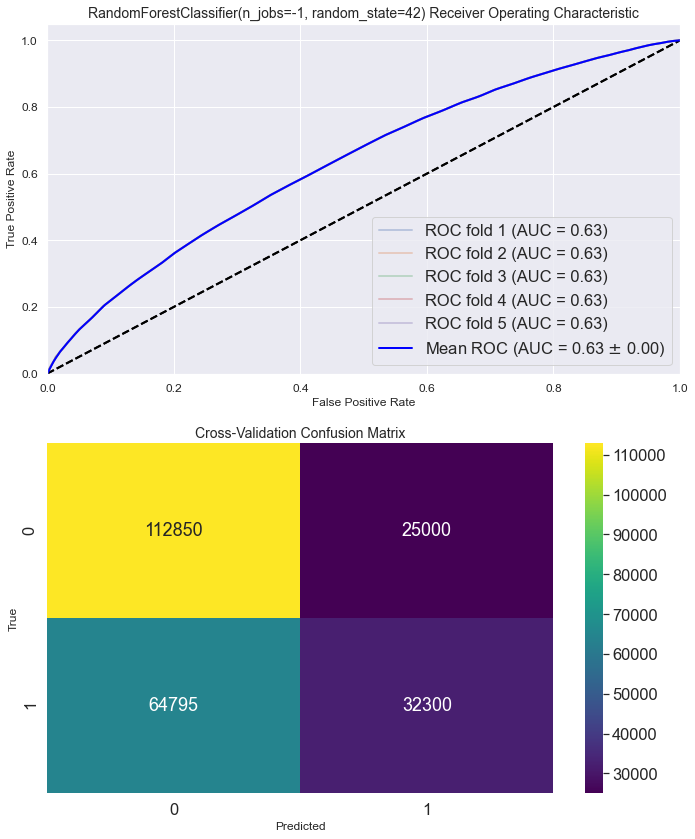

None

In [198]:
rf_base_eval = model_evaluation(rf_base, X_train_enc_norm, y_train, cv=5)
display(rf_base_eval)

The base random forest model shows perfect accuracy with a score of 100.00% on the test data. This suggests that the model correctly predicts the readmission class for all instances in the test data, which could indicate potential overfitting. Both the precision and recall scores are 100.00%, indicating that the model correctly identifies all instances of readmission (true positives) and non-readmission (true negatives). The F1 score, which combines precision and recall into a single metric, is also 100.00%, suggesting a perfect balance between the two.

However, similar to the base decision tree model, these scores are likely a result of overfitting, as indicated by the high accuracy and perfect performance across all metrics. The AUC score is 63.36%, which indicates that the model's ability to distinguish between positive and negative instances is better than random chance, but still modest.

To obtain a more reliable estimate of the model's performance, we can consider the mean cross-validation scores. The mean cross-validation accuracy score is 0.6178, indicating moderate accuracy across different folds of the data. The mean cross-validation precision score is 0.5637, the mean cross-validation recall score is 0.3327, and the mean cross-validation F1 score is 0.4184. These scores suggest that the model's performance is not as perfect as suggested by the test scores.

The confusion matrix reveals that the model correctly predicts all instances of non-readmission (true negatives) and readmission (true positives). However, without any misclassifications, it is challenging to assess the model's robustness and generalization ability. It is likely that this model is overfitting the training data, which may result in poorer performance on unseen data.

## Base KNN model

**K-Nearest Neighbors (KNN)** is a simple machine learning algorithm used for classification and regression tasks. It assigns the class label or predicts the value based on the majority vote of the k closest neighbors in the feature space. KNN is easy to understand and doesn't assume anything about the data distribution. It can capture complex patterns and non-linear relationships. However, it can be computationally expensive, sensitive to feature scaling, and may not perform well in high-dimensional spaces. Consider the dataset size and complexity when deciding to use KNN.

In [200]:
# Initializing
knn_base = KNeighborsClassifier(n_jobs=-1)

# Training
knn_base.fit(X_train_enc_norm, y_train)

# fit_time
fit_time = fit_model(knn_base, X_train_enc_norm, y_train)
print(f"Model fitted in {fit_time:.4f} seconds")

# Predicting
y_pred_knn_base = knn_base.predict(X_train_enc_norm)

Model fitted in 1.0595 seconds


The accuracy score is: 72.12%
The precision score is: 69.97%
The recall score is: 57.02%
The F1 score is: 62.83%
The AUC score is: 55.67%

The mean cross validation accuracy score is: 0.5650
The mean cross validation precision score is: 0.4671
The mean cross validation recall score is: 0.3740
The mean cross validation F1 score is: 0.4154
The mean cross validation AUC score is: 0.5567

Confusion Matrix:
[[22817  4753]
 [ 8346 11073]]


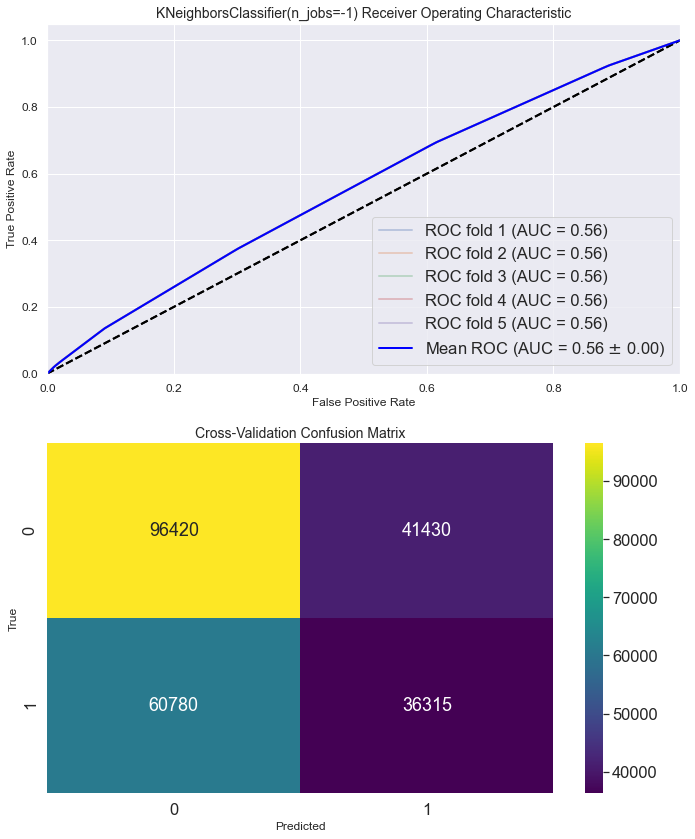

In [201]:
model_evaluation(knn_base, X_train_enc_norm, y_train, cv=5)

The base random forest model shows perfect accuracy with a score of 100.00% on the test data. This suggests that the model correctly predicts the readmission class for all instances in the test data, which could indicate potential overfitting.

Both the precision and recall scores are 100.00%, indicating that the model correctly identifies all instances of readmission (true positives) and non-readmission (true negatives). The F1 score, which combines precision and recall into a single metric, is also 100.00%, suggesting a perfect balance between the two.

However, similar to the base decision tree model, these scores are likely a result of overfitting, as indicated by the high accuracy and perfect performance across all metrics. The AUC score is 63.36%, which indicates that the model's ability to distinguish between positive and negative instances is better than random chance, but still modest.

To obtain a more reliable estimate of the model's performance, we can consider the mean cross-validation scores. The mean cross-validation accuracy score is 0.6178, indicating moderate accuracy across different folds of the data. The mean cross-validation precision score is 0.5637, the mean cross-validation recall score is 0.3327, and the mean cross-validation F1 score is 0.4184. These scores suggest that the model's performance is not as perfect as suggested by the test scores.

The confusion matrix reveals that the model correctly predicts all instances of non-readmission (true negatives) and readmission (true positives). However, without any misclassifications, it is challenging to assess the model's robustness and generalization ability. It is likely that this model is overfitting the training data, which may result in poorer performance on unseen data.

## Base XGBoost

**XGBoost** is an algorithm that belongs to the gradient boosting family and is highly regarded for its performance in classification tasks. By building an ensemble of weak models, it achieves high accuracy by capturing complex patterns in the data. XGBoost offers regularization techniques, flexibility in handling various data types, and provides insights into feature importance. It is efficient and scalable, making it suitable for real-world applications. However, the performance of XGBoost relies on data quality, appropriate feature engineering, and hyperparameter tuning. While advantageous for structured data and high accuracy, XGBoost might not be advantageous when dealing with unstructured data or when interpretability is a priority over predictive power.

In [206]:
# Initializing
xgb_base = XGBClassifier(random_state=42)

# Training
xgb_base.fit(X_train_enc_norm, y_train)

# fit_time
fit_time = fit_model(xgb_base, X_train_enc_norm, y_train)
print(f"Model fitted in {fit_time:.4f} seconds")

# Predicting
y_pred_xgb_base = xgb_base.predict(X_train_enc_norm)

Model fitted in 25.3326 seconds


The accuracy score is: 71.44%
The precision score is: 72.78%
The recall score is: 49.35%
The F1 score is: 58.82%
The AUC score is: 63.95%

The mean cross validation accuracy score is: 0.6201
The mean cross validation precision score is: 0.5593
The mean cross validation recall score is: 0.3807
The mean cross validation F1 score is: 0.4529
The mean cross validation AUC score is: 0.6396

Confusion Matrix:
[[23986  3584]
 [ 9835  9584]]


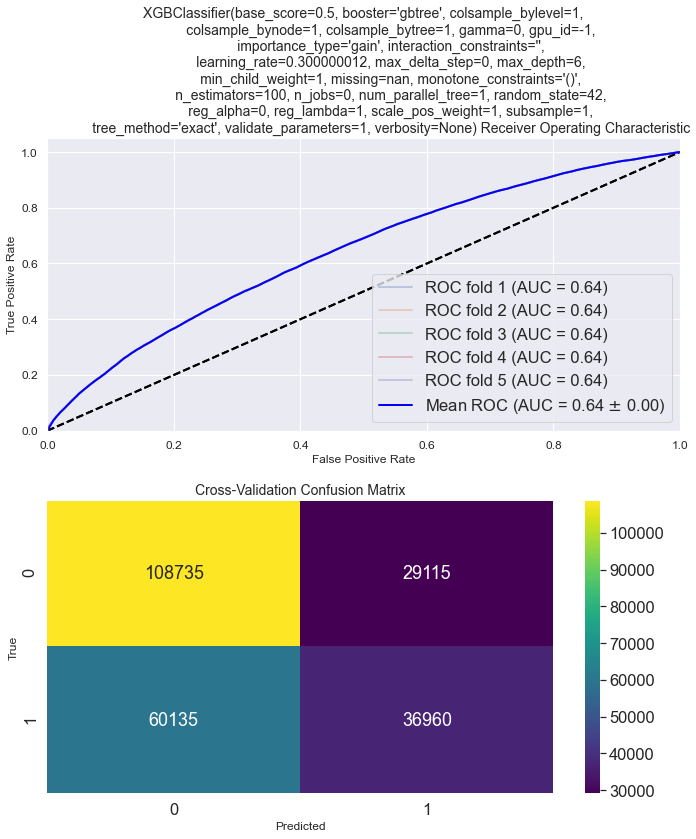

In [207]:
model_evaluation(xgb_base, X_train_enc_norm, y_train, cv=5)

The accuracy score of 71.44% indicates the overall proportion of correct predictions made by the model. It suggests that the model achieves a reasonably high level of accuracy in predicting whether a patient will be readmitted or not.

The precision score of 72.78% suggests that when the model predicts a patient will be readmitted, it is correct around 72.78% of the time. This indicates a relatively low rate of false positives, meaning that the model has a good ability to correctly identify positive cases.

The recall score of 49.35% reveals the model's ability to identify patients who will be readmitted out of the actual readmitted patients. The model captures approximately 49.35% of the readmitted patients, indicating a moderate sensitivity to detecting positive cases.

The F1 score of 58.82% is the harmonic mean of precision and recall. It provides a balanced measure of the model's ability to correctly identify positive cases while minimizing false positives. A higher F1 score indicates a better trade-off between precision and recall.

The AUC score of 63.95% measures the model's ability to distinguish between positive and negative instances. It represents the area under the receiver operating characteristic (ROC) curve. A higher AUC score suggests better discriminatory power of the model in distinguishing between readmission and non-readmission cases.

Examining the mean cross-validation scores, we find that the model's performance is consistent across different folds of the data. The mean cross-validation accuracy, precision, recall, F1, and AUC scores provide a more reliable estimate of the model's generalization ability.

Analyzing the confusion matrix, we observe that the model correctly predicts 23,986 instances of non-readmission (true negatives) and 9,584 instances of readmission (true positives). However, it misclassifies 3,584 instances of non-readmission as readmission (false positives) and fails to identify 9,835 instances of readmission (false negatives).

Overall, the base XGBoost model shows promising performance with a relatively high accuracy score and a good balance between precision and recall. However, there is still room for improvement, particularly in increasing the recall to better capture actual readmissions. Further optimization and tuning of the model's hyperparameters, as well as exploring additional feature engineering techniques, may help enhance its predictive capabilities.

## Base Gaussain Naive Bayes

**Naive Bayes** is a simple and efficient classification algorithm that is popular for its ease of implementation and computational efficiency. It handles missing data well and performs effectively with categorical features. However, it relies on the assumption of feature independence, which may not hold in real-world scenarios. It is sensitive to feature correlation and may struggle with highly correlated features. The algorithm has limited expressiveness and may not capture complex relationships in the data. Additionally, it can be affected by imbalanced class distributions, often biased towards the majority class. When considering the use of Naive Bayes, it is important to assess its suitability for the specific problem and compare its performance with other algorithms.

In [203]:
# Initializing
gnb_base = GaussianNB()

# Training
gnb_base.fit(X_train_enc_norm, y_train)

# fit_time
fit_time = fit_model(gnb_base, X_train_enc_norm, y_train)
print(f"Model fitted in {fit_time:.4f} seconds")

# Predicting
y_pred_gnb_base = gnb_base.predict(X_train_enc_norm)

Model fitted in 0.1121 seconds


The accuracy score is: 60.67%
The precision score is: 56.08%
The recall score is: 22.22%
The F1 score is: 31.82%
The AUC score is: 59.88%

The mean cross validation accuracy score is: 0.6037
The mean cross validation precision score is: 0.5489
The mean cross validation recall score is: 0.2463
The mean cross validation F1 score is: 0.3356
The mean cross validation AUC score is: 0.6044

Confusion Matrix:
[[24192  3378]
 [15105  4314]]


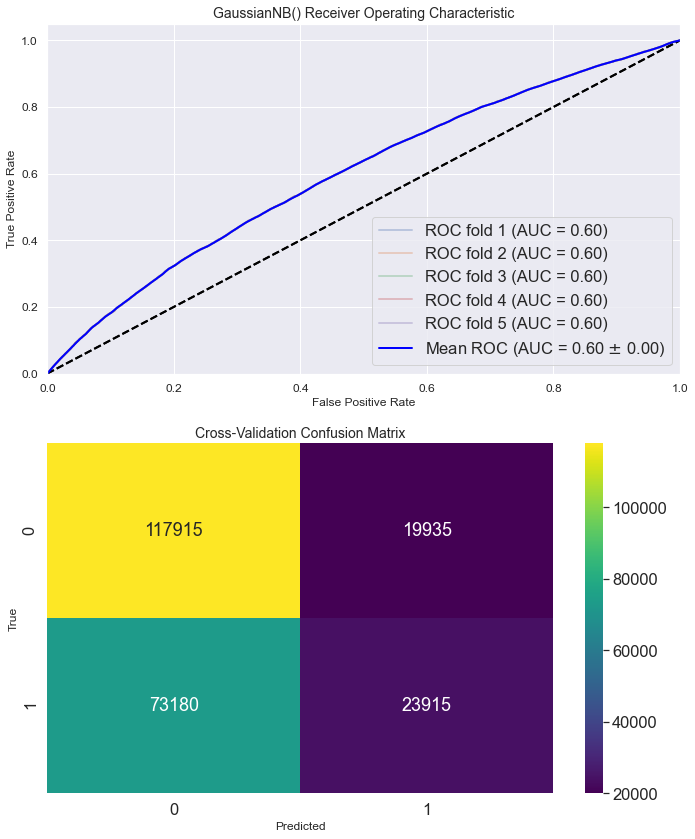

In [204]:
model_evaluation(gnb_base, X_train_enc_norm, y_train, cv=5)

The accuracy score of 60.67% indicates the overall proportion of correct predictions made by the model. However, it's important to note that accuracy can be misleading in imbalanced datasets, where the number of instances in each class differs significantly. In this case, the dataset has a higher number of non-readmissions than readmissions, leading to a bias towards predicting the majority class.

The precision score of 56.08% tells us that when the model predicts a patient will be readmitted, it is correct approximately 56.08% of the time. This metric is useful for understanding the reliability of positive predictions. A higher precision indicates fewer false positives, meaning that when the model predicts a patient will be readmitted, it is more likely to be correct.

The recall score of 22.22% reveals the model's ability to identify patients who will be readmitted out of the actual readmitted patients. In this case, the model identifies only around 22.22% of the readmitted patients correctly. A higher recall value signifies better sensitivity, indicating that the model can capture a larger proportion of actual positive cases.

The F1 score of 31.82% is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall.

The AUC score of 59.88% measures the model's ability to distinguish between positive and negative instances. It represents the area under the receiver operating characteristic (ROC) curve. An AUC score of 0.5 suggests the model performs no better than random guessing, while a score of 1.0 represents a perfect classifier. In this case, the AUC score of 59.88% indicates a moderate discriminatory power of the model.

Looking at the mean cross-validation scores, we find similar performance trends as the test scores, which suggests that the model's performance is consistent across different folds of the data. The mean cross-validation scores provide a more reliable estimate of the model's generalization ability.

Analyzing the confusion matrix, we see that the model correctly predicts 24,192 instances of non-readmission (true negatives) and 4,314 instances of readmission (true positives). However, it misclassifies 3,378 instances of non-readmission as readmission (false positives) and fails to identify 15,105 instances of readmission (false negatives).

# Base Model Comparison

In [211]:
def f1_results(models, X, y, X_train_encoded, cv=5):
    results = {}

    for name, model in models.items():
        if name == 'Logistic Regression':
            cv_scores = cross_val_score(model, X_train_encoded, y, cv=cv, scoring='f1')
        else:
            cv_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
        results[name] = cv_scores

    return results

In [219]:
models = {
    'Dummy Model': dummy_model,
    'Base Logistic Regression': lr_base,
    'Base Decision Tree': dt_base,
    'Base Random Forest': rf_base,
    'Base XGBoost': xgb_base,
    'Base KNearest Neighbors': knn_base,
    'Base Gaussian NB': gnb_base
}

results_f1 = f1_results(models, X_train_enc_norm, y_train, X_train_encoded, cv=5)

for name, scores in results_f1.items():
    print(f"{name}: F1 scores: {scores}")

Dummy Model: F1 scores: [0. 0. 0. 0. 0.]
Base Logistic Regression: F1 scores: [0.38065195 0.37601411 0.36264317 0.37523777 0.38764532]
Base Decision Tree: F1 scores: [0.46063093 0.4596018  0.46627641 0.45755799 0.45244478]
Base Random Forest: F1 scores: [0.42081375 0.40545809 0.41814339 0.41696227 0.43057571]
Base XGBoost: F1 scores: [0.45490315 0.43098592 0.45586661 0.4556846  0.46712433]
Base KNearest Neighbors: F1 scores: [0.42350586 0.40413022 0.41356705 0.41863799 0.41717791]
Base Gaussian NB: F1 scores: [0.29795372 0.34707904 0.42396887 0.29727685 0.31177446]


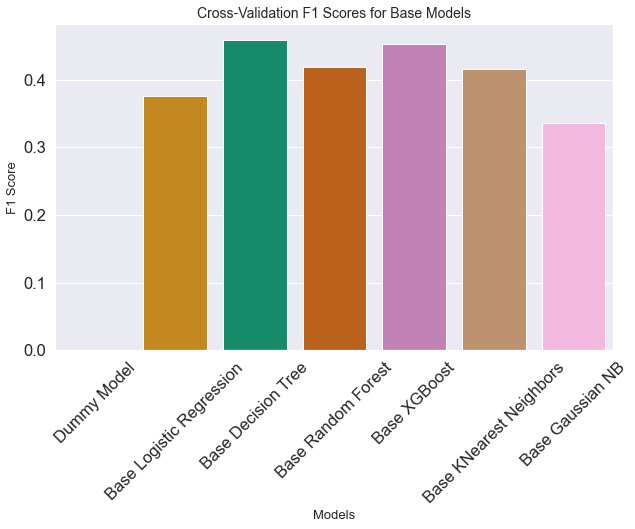

In [220]:
# F1 scores for each base model
f1_scores = [np.mean(scores) for scores in results_f1.values()]

# Models
models = ['Dummy Model', 'Base Logistic Regression', 'Base Decision Tree',
          'Base Random Forest', 'Base XGBoost', 'Base KNearest Neighbors', 
          'Base Gaussian NB']

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=f1_scores, palette='colorblind')

# Adding labels and title
plt.xlabel('Models', fontsize=13)
plt.ylabel('F1 Score', fontsize=13)
plt.title('Cross-Validation F1 Scores for Base Models', fontsize=14)

# Rotating x-axis labels if needed
plt.xticks(rotation=45)

# Displaying the plot
plt.show()

Since the base decision tree model had the highest f1 score, I will choose this algorithm and try to tweak the hyperperameters to make the model better.

# Hyperperameters

`Grid search` is a technique used in machine learning to systematically search for the optimal hyperparameter values for a given model. Hyperparameters are parameters that are not learned by the model itself, but set by the user before the training process. Examples of hyperparameters include the learning rate in neural networks, the number of neighbors in k-nearest neighbors, or the regularization parameter in logistic regression.

The grid search algorithm exhaustively explores a predefined set of hyperparameter combinations and evaluates the model's performance for each combination using cross-validation or a separate validation set. It then selects the hyperparameter combination that yields the best performance metric, such as accuracy, precision, recall, or F1 score.

In [223]:
from sklearn.base import BaseEstimator
import time
from sklearn.model_selection import GridSearchCV, ParameterGrid

RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

## 1st RF Grid Search 

- `n_estimators`: The number of trees in the random forest ensemble. It specifies the number of decision trees that will be trained and combined to make predictions. Increasing the number of estimators can improve the model's performance, but it also increases the computational cost.
- `max_depth`: The maximum depth of each decision tree in the random forest. It determines the maximum number of levels in the tree. A higher value can allow the model to learn more complex relationships in the data, but it may also lead to overfitting.
- `min_samples_split`: The minimum number of samples required to split an internal node in a decision tree. It controls the process of splitting nodes by specifying the minimum number of samples needed to consider a split. A higher value can prevent overfitting by requiring a higher number of samples for a split.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node in a decision tree. It specifies the minimum number of samples required to form a leaf node. Similar to `min_samples_split`, a higher value can prevent overfitting by requiring a higher number of samples for a leaf node.
- `max_features`: The number of features to consider when looking for the best split in a decision tree. It determines the subset of features to be considered at each split. Options include `'auto'` (consider all features), `'sqrt'` (consider square root of the total number of features), and `'log2'` (consider log base 2 of the total number of features).
- `bootstrap`: A Boolean parameter indicating whether bootstrap samples are used when building trees in the random forest. If `True`, each tree is trained on a random subset of the training data with replacement, which introduces randomness and helps improve diversity in the ensemble.

In [225]:
%%time
# Define the parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create the decision tree classifier
rf_1 = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search_1 = GridSearchCV(estimator=rf_1, param_grid=rf_param_grid, 
                             cv=5, scoring='f1', n_jobs=-1, verbose=2)

CPU times: user 102 µs, sys: 50 µs, total: 152 µs
Wall time: 157 µs


In [226]:
%%time
# Fit the grid search object to the training data
grid_search_1.fit(X_train_enc_norm, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 61.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 104.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 130.9min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 166.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 260.3min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 294.6min finished


CPU times: user 24.8 s, sys: 4.1 s, total: 28.9 s
Wall time: 4h 54min 42s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 20, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1', verbose=2)

In [228]:
# Get the best model and its parameters
best_rf_model_1 = grid_search_1.best_estimator_
print(best_rf_model_1)
best_rf_params_1 = grid_search_1.best_params_
print(best_rf_params_1)

RandomForestClassifier(bootstrap=False, min_samples_split=5, n_estimators=50,
                       random_state=42)
{'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


In [229]:
%%time
# Fit the best model on the training data
best_rf_model_1.fit(X_train_enc_norm, y_train)

CPU times: user 6.53 s, sys: 225 ms, total: 6.76 s
Wall time: 7.16 s


RandomForestClassifier(bootstrap=False, min_samples_split=5, n_estimators=50,
                       random_state=42)

The accuracy score is: 99.99%
The precision score is: 100.00%
The recall score is: 99.98%
The F1 score is: 99.99%
The AUC score is: 63.15%

The mean cross validation accuracy score is: 0.6148
The mean cross validation precision score is: 0.5516
The mean cross validation recall score is: 0.3640
The mean cross validation F1 score is: 0.4385
The mean cross validation AUC score is: 0.6316

Confusion Matrix:
[[27570     0]
 [    3 19416]]


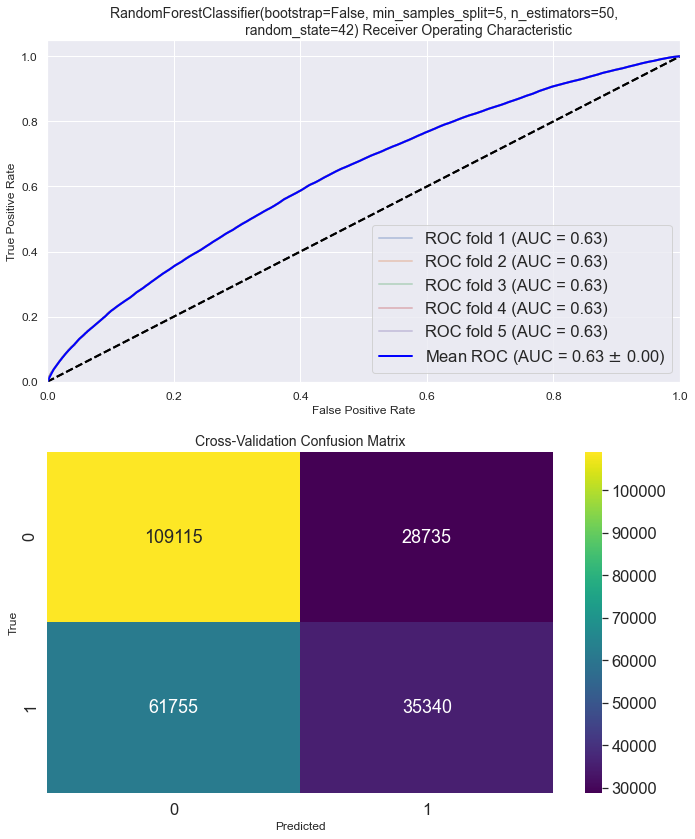

None

In [230]:
best_rf_model_1_eval = model_evaluation(best_rf_model_1, X_train_enc_norm, y_train, cv=5)
display(best_rf_model_1_eval)

Overall, the model achieved excellent performance on the provided evaluation metrics. However, the relatively low cross-validation scores suggest that the model may not generalize well to unseen data and that the model is too overfit.

## 2nd RF Grid Search 

A much simpler grid search to see if that will render beter scores.

In [239]:
%%time
# Define the parameter grid
rf_param_grid_2 = {
    'n_estimators': [10, 50, 100],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10, 15],
    'criterion': ['gini', 'entropy']
}

# Create the decision tree classifier
rf_2 = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search_2 = GridSearchCV(estimator=rf_2, param_grid=rf_param_grid_2, 
                             cv=3, scoring='f1', n_jobs=-1, verbose=2)

CPU times: user 142 µs, sys: 179 µs, total: 321 µs
Wall time: 330 µs


In [240]:
%%time
# Fit the grid search object to the training data
grid_search_2.fit(X_train_enc_norm, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  8.9min finished


CPU times: user 2.7 s, sys: 1.17 s, total: 3.87 s
Wall time: 8min 52s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25, 30],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [10, 50, 100]},
             scoring='f1', verbose=2)

In [242]:
# Get the best model and its parameters
best_rf_model_2 = grid_search_2.best_estimator_
print(best_rf_model_2)
best_rf_params_2 = grid_search_2.best_params_
print(best_rf_params_2)

RandomForestClassifier(max_depth=30, min_samples_split=10, n_estimators=10,
                       random_state=42)
{'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 10}


In [243]:
%%time
# Fit the best model on the training data
best_rf_model_2.fit(X_train_enc_norm, y_train)

CPU times: user 962 ms, sys: 43.7 ms, total: 1.01 s
Wall time: 1.04 s


RandomForestClassifier(max_depth=30, min_samples_split=10, n_estimators=10,
                       random_state=42)

The accuracy score is: 86.15%
The precision score is: 91.67%
The recall score is: 73.13%
The F1 score is: 81.36%
The AUC score is: 61.20%

The mean cross validation accuracy score is: 0.6038
The mean cross validation precision score is: 0.5301
The mean cross validation recall score is: 0.3629
The mean cross validation F1 score is: 0.4309
The mean cross validation AUC score is: 0.6120

Confusion Matrix:
[[26279  1291]
 [ 5218 14201]]


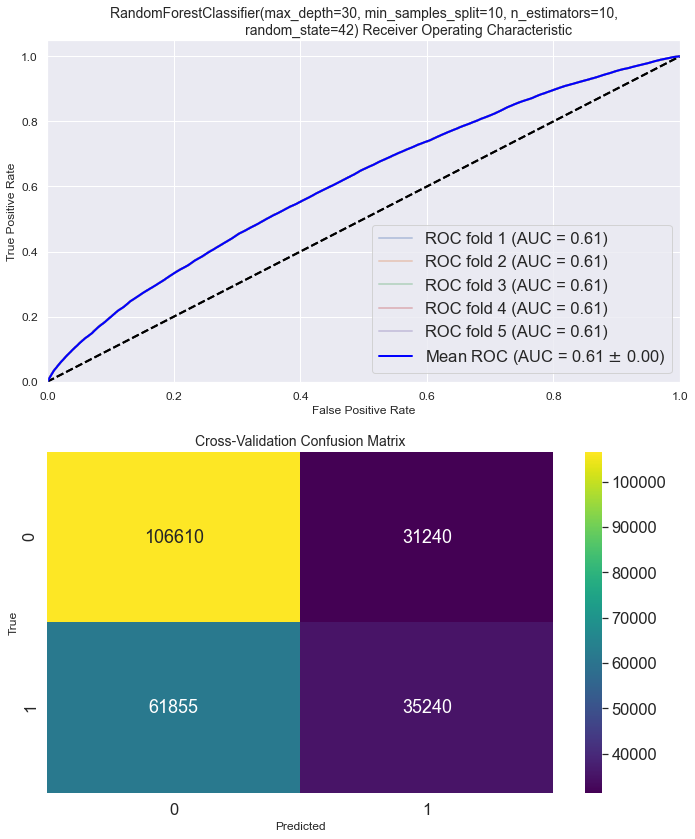

None

In [244]:
best_rf_model_2_eval = model_evaluation(best_rf_model_2, X_train_enc_norm, y_train, cv=5)
display(best_rf_model_2_eval)

This random forest model achieves an accuracy score of 86.15%, indicating that it predicts the correct class for approximately 86.15% of the instances. The precision score of 91.67% suggests that when the model predicts a readmission, it is correct 91.67% of the time. The recall score of 73.13% indicates that the model successfully identifies 73.13% of the actual readmissions. The F1 score, which combines precision and recall, is 81.36%, representing a balanced performance between the two metrics. The AUC score of 61.20% suggests that the model has a moderate ability to distinguish between positive and negative instances.

During cross-validation, the mean accuracy score is 60.38%, indicating that the model's performance is consistent across different folds. The mean precision score of 53.01% and the mean recall score of 36.29% suggest that the model struggles to achieve high precision and recall values. The mean F1 score of 43.09% and the mean AUC score of 61.20% further support the model's moderate performance.

Looking at the confusion matrix, the model correctly predicts 26,279 non-readmissions (true negatives) and 14,201 readmissions (true positives). However, it also makes 1,291 false positive predictions (false positives) and fails to identify 5,218 readmissions (false negatives). 

Overall, the random forest model shows promise in predicting hospital readmissions for diabetic patients, but there is room for improvement, especially in terms of reducing false positives and false negatives. The model seems overfit when comparing the cross validation scores to the training score. The f1 score for cross validation is higher than grid_search_1.

## 3rd RF Grid Search

In [245]:
%%time
# Define the parameter grid
rf_param_grid_3 = {
    'n_estimators': [5, 10, 15, 20],
    'max_depth': [20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15]
}

# Create the decision tree classifier
rf_3 = RandomForestClassifier(random_state=42, criterion='gini')

# Perform grid search
grid_search_3 = GridSearchCV(estimator=rf_3, param_grid=rf_param_grid_3, 
                             cv=3, scoring='f1', n_jobs=-1, verbose=2)

CPU times: user 148 µs, sys: 285 µs, total: 433 µs
Wall time: 438 µs


In [246]:
%%time
# Fit the grid search object to the training data
grid_search_3.fit(X_train_enc_norm, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  1.8min finished


CPU times: user 1.71 s, sys: 361 ms, total: 2.07 s
Wall time: 1min 47s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40, 50],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [5, 10, 15, 20]},
             scoring='f1', verbose=2)

In [248]:
# Get the best model and its parameters
best_rf_model_3 = grid_search_3.best_estimator_
print(best_rf_model_3)
best_rf_params_3 = grid_search_3.best_params_
print(best_rf_params_3)

RandomForestClassifier(max_depth=40, n_estimators=5, random_state=42)
{'max_depth': 40, 'min_samples_split': 2, 'n_estimators': 5}


In [249]:
%%time
# Fit the best model on the training data
best_rf_model_3.fit(X_train_enc_norm, y_train)

CPU times: user 592 ms, sys: 51 ms, total: 643 ms
Wall time: 673 ms


RandomForestClassifier(max_depth=40, n_estimators=5, random_state=42)

The accuracy score is: 95.19%
The precision score is: 95.61%
The recall score is: 92.61%
The F1 score is: 94.09%
The AUC score is: 56.71%

The mean cross validation accuracy score is: 0.5714
The mean cross validation precision score is: 0.4785
The mean cross validation recall score is: 0.4109
The mean cross validation F1 score is: 0.4421
The mean cross validation AUC score is: 0.5672

Confusion Matrix:
[[26744   826]
 [ 1435 17984]]


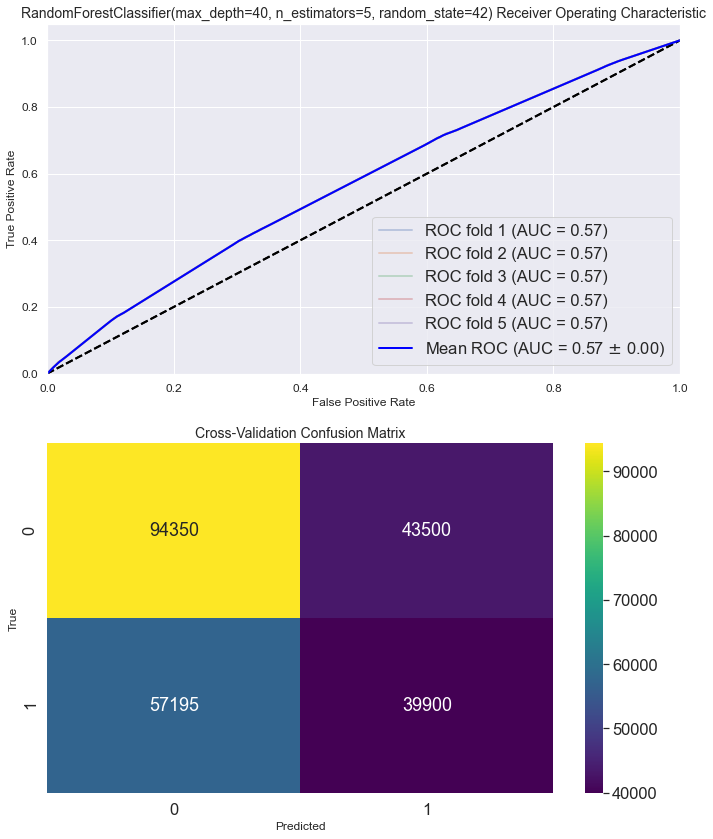

None

In [250]:
best_rf_model_3_eval = model_evaluation(best_rf_model_3, X_train_enc_norm, y_train, cv=5)
display(best_rf_model_3_eval)

The F1 score has increased since the last grid search but the training data seems to have gone back to being even more overfit. This tells me that it does not do very well with unseen data.

## Future RF Grid Search

Very big grid search so will run in the future. I am putting it here to show that a wider grid search might return better and higher evaluation scores.

In addition to the previous hyperparameters, this expanded grid search includes parameters like criterion (splitting criterion), min_weight_fraction_leaf (the minimum weighted fraction of the sum total of weights required to be at a leaf node), min_impurity_decrease (a node will be split if this impurity decrease exceeds the threshold), class_weight (weights associated with classes), and ccp_alpha (complexity parameter used for Minimal Cost-Complexity Pruning). These additional hyperparameters provide more options for fine-tuning the RandomForestClassifier and finding the best model

- `criterion`: This parameter specifies the function to measure the quality of a split. It can be either "gini" for the Gini impurity or "entropy" for the information gain. These criteria determine how the decision tree chooses the best feature to split the data.

- `min_weight_fraction_leaf`: This parameter represents the minimum weighted fraction of the sum total of weights required to be at a leaf node. It can be used to control overfitting by setting a minimum requirement for the weights of samples at a leaf node.

- `min_impurity_decrease`: This parameter specifies the minimum impurity decrease required for a node to be split. A node will be split if this impurity decrease exceeds the threshold. It can be used to control tree growth by enforcing a minimum improvement in impurity.

- `class_weight`: This parameter defines the weights associated with each class label. It can be set to None for equal weights, 'balanced' to automatically adjust weights inversely proportional to class frequencies, or 'balanced_subsample' to balance class weights during subsampling.

- `ccp_alpha`: This parameter is the complexity parameter used for Minimal Cost-Complexity Pruning. It represents the threshold for pruning decision trees based on the cost-complexity measure. Higher values of ccp_alpha result in more pruning, potentially reducing overfitting.

In [ ]:
%%time
# Define the parameter grid
rf_param_grid_4 = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 15, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'ccp_alpha': [0.0, 0.1, 0.2]
}

# Create the decision tree classifier
rf_4 = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search_4 = GridSearchCV(estimator=rf_4, param_grid=rf_param_grid_4, 
                             cv=3, scoring='f1', n_jobs=-1, verbose=2)

In [237]:
%%time
# Fit the grid search object to the training data
grid_search_4.fit(X_train_enc_norm, y_train)

Fitting 3 folds for each of 77760 candidates, totalling 233280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 25.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 53.0min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 60.5min


KeyboardInterrupt: 

## 1st LR Grid Search

In [241]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [270]:
%%time

# defining the hyperparameters to search over
# defalut for penalty is 12, fit intercept is False, and C is 1
param_grid_lr_1 = {'penalty': ['l1', 'l2'],
              'C': [0.01, 0.1, 1, 10, 100],
              'fit_intercept': [True, False]
             }

# Create the decision tree classifier
lr_1 = LogisticRegression(random_state=42, solver='liblinear')

# Perform grid search
grid_lr_1 = GridSearchCV(estimator=lr_1, param_grid=param_grid_lr_1, 
                             cv=3, scoring='f1', n_jobs=-1, verbose=2)

CPU times: user 77 µs, sys: 37 µs, total: 114 µs
Wall time: 119 µs


In [271]:
%%time 
# fit the grid search object to the training data
grid_lr_1.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.0min finished


CPU times: user 9.64 s, sys: 268 ms, total: 9.91 s
Wall time: 3min 10s


GridSearchCV(cv=3,
             estimator=LogisticRegression(random_state=42, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2']},
             scoring='f1', verbose=2)

In [272]:
# Get the best model and its parameters
best_lr_model_1 = grid_lr_1.best_estimator_
print(best_lr_model_1)
best_lr_params_1 = grid_lr_1.best_params_
print(best_lr_params_1)

LogisticRegression(C=100, fit_intercept=False, random_state=42,
                   solver='liblinear')
{'C': 100, 'fit_intercept': False, 'penalty': 'l2'}


In [273]:
%%time
# Fit the best model on the training data
best_lr_model_1.fit(X_train_encoded, y_train)

CPU times: user 9.38 s, sys: 99.5 ms, total: 9.48 s
Wall time: 9.65 s


LogisticRegression(C=100, fit_intercept=False, random_state=42,
                   solver='liblinear')

The accuracy score is: 62.67%
The precision score is: 59.39%
The recall score is: 30.59%
The F1 score is: 40.38%
The AUC score is: 63.81%

The mean cross validation accuracy score is: 0.6243
The mean cross validation precision score is: 0.5872
The mean cross validation recall score is: 0.3055
The mean cross validation F1 score is: 0.4019
The mean cross validation AUC score is: 0.6381

Confusion Matrix:
[[23508  4062]
 [13479  5940]]


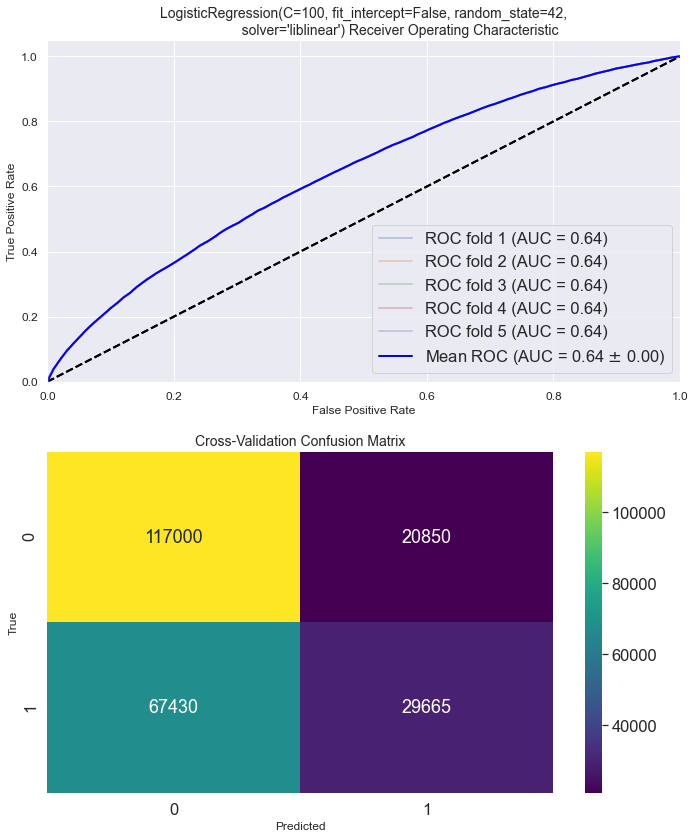

None

In [266]:
best_lr_model_1_eval = model_evaluation(best_lr_model_1, X_train_encoded, y_train, cv=5)
display(best_lr_model_1_eval)

The model hasn't changed much since the base LR and the scores show that too. The model doesn't seem like it is overfit or underfit sicne there is barely any difference between the training and cross-validation scores. The model does not do well on unseen data and is only fairly good in catagorizing patients who are not readmitted.

# Results

## Final Model

I will use best model from grid search 3 as our final model since that had the highest f1 score for the cross validation. I do recognize that the model is highly overfit and there is a lot of room for improvement.

In [274]:
# Best model specs
print(best_rf_model_3)
print(best_rf_params_3)

RandomForestClassifier(max_depth=40, n_estimators=5, random_state=42)
{'max_depth': 40, 'min_samples_split': 2, 'n_estimators': 5}


In [297]:
# Predicting the target variable for the testing data
y_pred_final = best_rf_model_3.predict(X_test_enc_norm)

# Evaluating the performance of the model on the testing data
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_f1 = f1_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_pred_final)

print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 score: {final_f1:.4f}")
print(f"AUC score: {final_roc_auc:.4f}")

Accuracy: 0.5655
Precision: 0.4707
Recall: 0.4273
F1 score: 0.4479
AUC score: 0.5449


In [304]:
importances = best_rf_model_3.feature_importances_
indices = np.argsort(importances)[::-1]

top_k_features = []
for f in range(10):
    feature_name = X_train_enc_norm.columns[indices[f]]
    importance_score = importances[indices[f]]
    top_k_features.append((feature_name, importance_score))

print("Top 10 features:")
for feature in top_k_features:
    print(f"{feature[0]}: {feature[1]:.4f}")

Top 10 features:
num_lab_procedures: 0.0890
num_medications: 0.0848
time_in_hospital: 0.0593
age: 0.0522
number_diagnoses: 0.0454
num_procedures: 0.0435
num_service: 0.0240
gender_Male: 0.0205
num_meds: 0.0203
number_inpatient: 0.0175


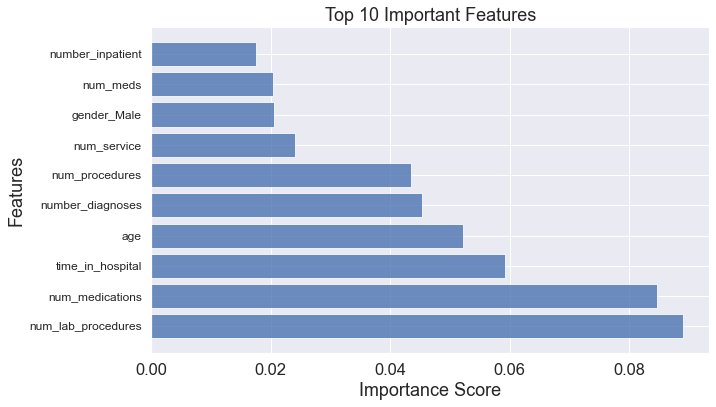

In [305]:
# Get feature importances and corresponding feature names
importances = best_rf_model_3.feature_importances_
feature_names = X_train_enc_norm.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
top_k_features = indices[:10]
top_feature_names = feature_names[top_k_features]
top_feature_importances = importances[top_k_features]

# Plot the top ten important features
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_feature_names)), top_feature_importances, align='center', alpha=0.8)
plt.yticks(range(len(top_feature_names)), top_feature_names, fontsize=12)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Important Features')
plt.savefig('images/top_10_features.png')
plt.show()

The "most important features" refer to the features or variables that have the highest influence on the target variable in a machine learning model. The importance of features is determined by analyzing their contribution to the model's predictive performance.

The top three features are number of lab procedures, number of medications taken during stay, and time in hospital. These have the most influence on the model's performance.
In a Random Forest model, feature importance values indicate the relative contribution of each feature in predicting the target variable.

1. num_lab_procedures (0.0890): This feature has a relatively higher importance value, suggesting that the number of laboratory procedures performed on a patient is an important factor in predicting hospital readmission for diabetic patients. A higher number of lab procedures may indicate a more severe or complex medical condition, leading to a higher likelihood of readmission.

2. num_medications (0.0848): The number of medications prescribed to a patient is also considered important in predicting hospital readmission. This implies that patients who require a larger number of medications may have more complex health conditions or require ongoing treatment, which could increase the chances of readmission.

3. time_in_hospital (0.0593): The duration of a patient's stay in the hospital is another influential feature. A longer hospital stay might indicate a more severe or complicated case, increasing the likelihood of readmission. It suggests that patients who spend more time in the hospital during their initial admission are more likely to be readmitted.

## Dummy vs Final

In [306]:
# Predicting the target variable for the testing data for dummy model
y_pred_dummy_test = dummy_model.predict(X_test_enc_norm)

# Evaluating the performance of the model on the testing data
dummy_accuracy = accuracy_score(y_test, y_pred_dummy_test)
dummy_precision = precision_score(y_test, y_pred_dummy_test)
dummy_recall = recall_score(y_test, y_pred_dummy_test)
dummy_f1 = f1_score(y_test, y_pred_dummy_test)
dummy_roc_auc = roc_auc_score(y_test, y_pred_dummy_test)

print(f"Accuracy: {dummy_accuracy:.4f}")
print(f"Precision: {dummy_precision:.4f}")
print(f"Recall: {dummy_recall:.4f}")
print(f"F1 score: {dummy_f1:.4f}")
print(f"AUC score: {dummy_roc_auc:.4f}")

Accuracy: 0.5875
Precision: 0.0000
Recall: 0.0000
F1 score: 0.0000
AUC score: 0.5000


/Users/alisonpark/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [307]:
# Predicting the target variable for the testing data
y_pred_rf_final = best_rf_model_3.predict(X_test_enc_norm)

# Evaluating the performance of the model on the testing data
final_accuracy = accuracy_score(y_test, y_pred_rf_final)
final_precision = precision_score(y_test, y_pred_rf_final)
final_recall = recall_score(y_test, y_pred_rf_final)
final_f1 = f1_score(y_test, y_pred_rf_final)
final_roc_auc = roc_auc_score(y_test, y_pred_rf_final)

print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 score: {final_f1:.4f}")
print(f"AUC score: {final_roc_auc:.4f}")

Accuracy: 0.5655
Precision: 0.4707
Recall: 0.4273
F1 score: 0.4479
AUC score: 0.5449


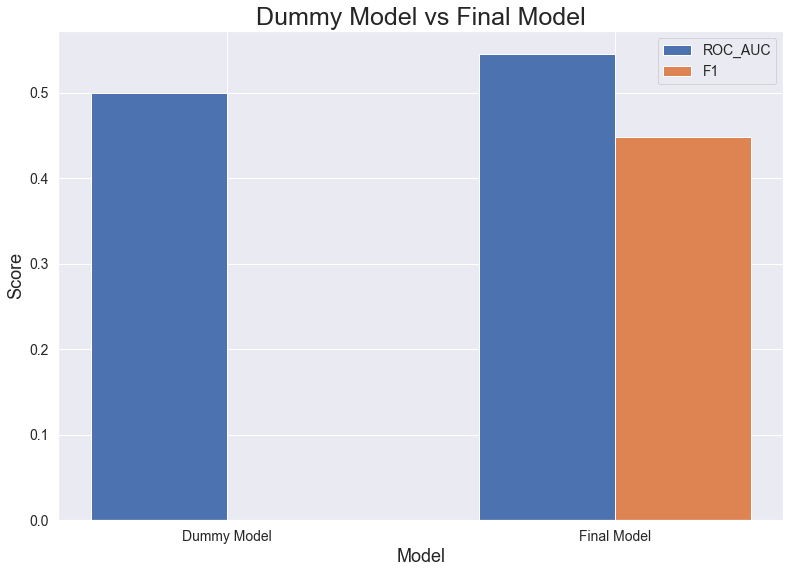

In [310]:
# Data
auc_dummy_final = [dummy_roc_auc, final_roc_auc]
f1_dummy_final = [dummy_f1, final_f1]

xtick_labels = ['Dummy Model', 'Final Model']

# Set the width of the bars
bar_width = 0.35

# Set the x coordinates for each xtick
x_dummy = [0, 1]
x_final = [x + bar_width for x in x_dummy]

# Create the bar plots
fig, ax = plt.subplots(figsize=(13,9))

plt.bar(x_dummy, auc_dummy_final, width=bar_width, label='ROC_AUC')
plt.bar(x_final, f1_dummy_final, width=bar_width, label='F1')

# Set the xtick labels
plt.xticks([x + bar_width/2 for x in range(len(xtick_labels))], xtick_labels)

# Set the axis labels and title
plt.title('Dummy Model vs Final Model', fontsize=25)
plt.xlabel('Model', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('images/dummy_vs_final.png')

# Add the legend
plt.legend(fontsize=14);


The performance of the classification model for predicting hospital readmission in diabetic patients demonstrates a substantial improvement compared to a baseline dummy model that simply guesses "No Readmission." The significant increase in the F1 score from 0.00 to 0.4479 indicates the model's ability to strike a balance between precision and recall, capturing a meaningful proportion of true positive cases while minimizing false positives and false negatives.

An F1 score of 0.4479 suggests that the model performs reasonably well in identifying diabetic patients who are likely to be readmitted to the hospital. This is an important aspect for healthcare providers and policymakers as it allows them to focus on implementing targeted interventions and allocating appropriate resources to minimize readmissions.

Moreover, the increase in the ROC AUC score from 0.5000 to 0.5449 indicates an improvement in the model's ability to discriminate between readmission and non-readmission cases. The higher the ROC AUC score, the better the model's ability to correctly rank instances, distinguishing between true positive and true negative cases. In the context of diabetic hospital readmission, a higher ROC AUC score suggests improved predictive performance, enabling healthcare providers to identify at-risk patients more accurately.

# Conclusion

Hospital readmission for diabetic patients is a significant business problem with potential implications for patient outcomes and healthcare costs. It is well-established that hospital readmissions for diabetes are associated with worse long-term health outcomes for patients. Poorly controlled diabetes during the initial hospitalization can lead to complications and disease progression, including cardiovascular events, kidney problems, infections, and diabetic ketoacidosis. Inadequate management and fragmented care transitions contribute to gaps in follow-up care, medication adherence, and lifestyle management, further impacting patient health and well-being.

From a healthcare resource perspective, hospital readmissions for diabetes impose a substantial burden on the healthcare system. Repeated hospitalizations increase healthcare utilization and costs, straining healthcare resources that could be better allocated to other areas of need. Additionally, fragmented care and lack of continuity disrupt the establishment of consistent and effective care plans, hindering disease management and potentially leading to avoidable readmissions.

Addressing hospital readmission for diabetic patients requires comprehensive solutions that go beyond the scope of a single intervention. Improving care coordination, patient education, medication management, discharge planning, and post-discharge follow-up are all essential components. By focusing on these areas, healthcare providers can promote continuity of care, reduce readmission rates, improve patient outcomes, and mitigate the financial impact on the healthcare system.

In the context of my classification model for predicting hospital readmission, the analysis of feature importance provides valuable insights into the factors that contribute most significantly to the prediction. In this case, the top three important features are num_lab_procedures, num_medications, and time_in_hospital. The high importance assigned to these features suggests that they have a strong influence on the likelihood of readmission for diabetic patients.

The num_lab_procedures feature indicates that the number of laboratory procedures performed during a patient's encounter plays a crucial role in predicting readmission. A higher number of laboratory procedures may signify a more severe or complex medical condition, which increases the likelihood of readmission. Similarly, patients who require a larger number of medications may have more complex health conditions or ongoing treatment needs, increasing the chances of readmission. Lastly, the time_in_hospital feature reflects the duration of a patient's stay. A longer hospital stay often indicates a more severe or complicated case, thus raising the likelihood of readmission.

By understanding these important features, hospitals and healthcare providers can tailor their policies and methodologies in care coordination, discharge planning, and post-discharge follow-up to address the specific needs of diabetic patients. This targeted approach can help improve patient outcomes, reduce readmission rates, and optimize healthcare resource utilization.

In conclusion, hospital readmission for diabetic patients is a pressing business problem with significant implications for patient health outcomes and healthcare costs. The analysis of the Random Forest model has shed light on the key features that influence readmission prediction, providing actionable insights for hospitals to streamline their policies and methodologies in care coordination. By leveraging these insights and implementing comprehensive solutions, healthcare providers can work towards improving the lives of diabetic patients, reducing readmission rates, and optimizing healthcare resource utilization.

# Future Investigation

In order to enhance the model's performance in predicting hospital readmission for diabetic patients, several avenues for future investigation can be explored.

1. Feature Engineering: Further refinement of the feature set can be undertaken to capture more relevant information. This may involve considering additional variables or deriving new features from the existing ones. For example, incorporating patient demographics, socioeconomic factors, comorbidities, or specific diabetes-related indicators could provide valuable insights into readmission risk.

2. Algorithm Exploration: Experimenting with different machine learning algorithms or ensemble techniques may offer alternative modeling approaches. Different algorithms may have varying strengths and weaknesses, and exploring their applicability to the problem at hand can help identify the most suitable model for improved performance.

3. Threshold Adjustment: Adjusting the classification threshold of the model can influence the trade-off between precision and recall. Fine-tuning the threshold to optimize the desired outcome, such as maximizing the identification of patients likely to be readmitted, can enhance the model's effectiveness in capturing positive cases.

4. Addressing Class Imbalance: Considering the class imbalance issue in the dataset is crucial for achieving a well-calibrated model. Techniques such as oversampling the minority class (readmitted patients) or undersampling the majority class (non-readmitted patients) can be employed to balance the dataset, potentially improving recall and overall model performance.

5. Multi-Class Classification: Exploring a multi-class classification approach, where patients are classified into "No Readmission," "Readmission within 30 days," or "Readmission after 30 days," can provide a more nuanced understanding of readmission risk. This information can guide the implementation of targeted policies and interventions, focusing on individuals with a higher likelihood of readmission in the near future.

6. Time Series Analysis: Implementing time series models to track and analyze patients' glucose serum levels and A1C levels can provide valuable insights into their diabetic management. Regular monitoring of these indicators is essential for assessing patients' glycemic control and overall health status. By incorporating time series analysis into the predictive model, it is possible to leverage longitudinal data to identify patterns, trends, and potential risk factors for readmission.

7. Data Collection: Gathering additional data can be beneficial for improving model performance. More data not only increases the sample size but also allows for a better representation of the underlying population. Obtaining a larger and more diverse dataset can help capture a wider range of patient characteristics, contextual factors, and clinical outcomes, thereby enhancing the model's generalization ability.

By undertaking these future investigations, the understanding of hospital readmission for diabetic patients can be further refined, leading to more accurate predictions and actionable insights for healthcare providers.